<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_7_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.7, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<09:59,  1.67episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:06<36:01,  2.17s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:06<27:46,  1.67s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:12<47:38,  2.87s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:13<36:03,  2.17s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:18<53:02,  3.20s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:19<39:45,  2.40s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:24<55:14,  3.34s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:25<41:27,  2.51s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:31<56:54,  3.45s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.03325198218226433|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6214 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.017613500763767446 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.009402792509519213 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.06095133340640947 || eq_WSEE: 0.10557475616596732 || Reward: -0.43 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0798375351912743 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.03920568308232473, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:42<1:17:42,  4.72s/episode]

Loss: 0.01684008352458477|| Global step: 600 || Episode: 12 || Reward: 0.59 || Distance: 0.5722 ||
wsee: 0.09619380605425996, eqwsee: 0.13152993615391398, reward: 0.5890095072603925


  1%|1         | 13/1000 [00:44<1:05:48,  4.00s/episode]

Loss: 0.006948426831513643|| Global step: 650 || Episode: 13 || Reward: -0.55 || Distance: 0.5037 ||
wsee: 0.1353377358699228, eqwsee: 0.13109976637185683, reward: -0.554919705233616
|| Test Run No: 1100 || WSEE: 0.014844595431722963 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.004212086781407171 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.05376146170180236 || eq_WSEE: 0.10557475616596732 || Reward: -0.50 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07559792979295159 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.033709230955480333, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:51<1:21:42,  4.97s/episode]

Loss: 0.009967942722141743|| Global step: 700 || Episode: 14 || Reward: 0.24 || Distance: 0.9782 ||
wsee: 0.09277713617968324, eqwsee: 0.13152993615391398, reward: 0.23941611837065557


  2%|1         | 15/1000 [00:54<1:08:10,  4.15s/episode]

Loss: 0.0006862588925287127|| Global step: 750 || Episode: 15 || Reward: 0.27 || Distance: 0.7081 ||
wsee: 0.11377073133359955, eqwsee: 0.08896563362710563, reward: 0.2668785420654265
|| Test Run No: 1100 || WSEE: 0.015734477583931927 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.003818687331884265 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.047147875236190614 || eq_WSEE: 0.10557475616596732 || Reward: -0.57 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07147281465295692 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.030956449002278657, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [01:01<1:22:57,  5.06s/episode]

Loss: 0.0038174865767359734|| Global step: 800 || Episode: 16 || Reward: 0.91 || Distance: 0.5072 ||
wsee: 0.09090207874968187, eqwsee: 0.13152993615391398, reward: 0.9068799881585242


  2%|1         | 17/1000 [01:03<1:09:38,  4.25s/episode]

Loss: 0.008016448467969894|| Global step: 850 || Episode: 17 || Reward: -0.51 || Distance: 0.8680 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.5051274266150296
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.004402055524234715 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.04287636871117088 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06763441253118455 || eq_WSEE: 0.13084527637398705 || Reward: -0.75 ||
wsee:0.02932591367897774, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [01:11<1:24:40,  5.17s/episode]

Loss: 0.0006821465212851763|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6085 ||
wsee: 0.08928587189258612, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [01:13<1:10:48,  4.33s/episode]

Loss: 0.002265132497996092|| Global step: 950 || Episode: 19 || Reward: -0.40 || Distance: 0.7359 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.4028908957419729
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.007047037408745829 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.04080952319863672 || eq_WSEE: 0.10557475616596732 || Reward: -0.65 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06574059257120245 || eq_WSEE: 0.13084527637398705 || Reward: -0.77 ||
wsee:0.028790400478818538, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:20<1:26:05,  5.27s/episode]

Loss: 0.0017949325265362859|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6806 ||
wsee: 0.08762913820365982, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:23<1:11:44,  4.40s/episode]

Loss: 0.0008188196807168424|| Global step: 1050 || Episode: 21 || Reward: 1.06 || Distance: 0.2428 ||
wsee: 0.1349806844689383, eqwsee: 0.10375368536381287, reward: 1.0638719947103719
|| Test Run No: 1100 || WSEE: 0.016044686505336758 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.010398251668130565 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.035922987491721944 || eq_WSEE: 0.10557475616596732 || Reward: -0.71 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.061219760778712114 || eq_WSEE: 0.13084527637398705 || Reward: -0.83 ||
wsee:0.027362493750805985, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:30<1:26:42,  5.32s/episode]

Loss: 0.003179847728461027|| Global step: 1100 || Episode: 22 || Reward: 1.46 || Distance: 1.0456 ||
wsee: 0.08379053001017177, eqwsee: 0.13152993615391398, reward: 1.4638247589906013


  2%|2         | 23/1000 [01:33<1:12:34,  4.46s/episode]

Loss: 0.002401992678642273|| Global step: 1150 || Episode: 23 || Reward: 1.11 || Distance: 0.6573 ||
wsee: 0.14706489335513015, eqwsee: 0.12460080593306919, reward: 1.1063597698614611
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.014352241398272259 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.033841777731651014 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05763351257559416 || eq_WSEE: 0.13084527637398705 || Reward: -0.88 ||
wsee:0.02603920771699475, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:40<1:27:08,  5.36s/episode]

Loss: 0.0017878899816423655|| Global step: 1200 || Episode: 24 || Reward: 0.13 || Distance: 0.6575 ||
wsee: 0.08037732229959886, eqwsee: 0.13152993615391398, reward: 0.1255988800061475


  2%|2         | 25/1000 [01:43<1:12:54,  4.49s/episode]

Loss: 0.0014209055807441473|| Global step: 1250 || Episode: 25 || Reward: -0.05 || Distance: 0.9619 ||
wsee: 0.10373449982603862, eqwsee: 0.09376202016680894, reward: -0.05389645296562828
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.01435611099548072 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.03383992156303324 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.057631325616184066 || eq_WSEE: 0.13084527637398705 || Reward: -0.88 ||
wsee:0.02603832014444788, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:50<1:27:31,  5.39s/episode]

Loss: 0.0010255509987473488|| Global step: 1300 || Episode: 26 || Reward: 0.11 || Distance: 1.2123 ||
wsee: 0.08037504884857292, eqwsee: 0.13152993615391398, reward: 0.10696856016786732


  3%|2         | 27/1000 [01:53<1:13:18,  4.52s/episode]

Loss: 0.0013150410959497094|| Global step: 1350 || Episode: 27 || Reward: -5.76 || Distance: 0.5865 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.757867765290752
|| Test Run No: 1100 || WSEE: 0.01652130278828811 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.014672303548936155 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.034109391910589204 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05715066512860323 || eq_WSEE: 0.13084527637398705 || Reward: -0.89 ||
wsee:0.025873300952377234, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [02:00<1:27:22,  5.39s/episode]

Loss: 0.001167404931038618|| Global step: 1400 || Episode: 28 || Reward: 0.22 || Distance: 0.4768 ||
wsee: 0.08010276825705659, eqwsee: 0.13152993615391398, reward: 0.22360506392232343


  3%|2         | 29/1000 [02:02<1:13:18,  4.53s/episode]

Loss: 0.0018342824187129736|| Global step: 1450 || Episode: 29 || Reward: -4.62 || Distance: 0.7772 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.622309512490868
|| Test Run No: 1100 || WSEE: 0.01951980259506169 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.017485463682863415 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.03206248163300382 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05572215339086897 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.02483888815410361, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [02:10<1:27:51,  5.43s/episode]

Loss: 0.0015845753950998187|| Global step: 1500 || Episode: 30 || Reward: -0.81 || Distance: 0.3068 ||
wsee: 0.07821841885876729, eqwsee: 0.13152993615391398, reward: -0.8132874732234612


  3%|3         | 31/1000 [02:13<1:13:50,  4.57s/episode]

Loss: 0.0009626041864976287|| Global step: 1550 || Episode: 31 || Reward: -0.07 || Distance: 0.7781 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: -0.06915860925297979
|| Test Run No: 1100 || WSEE: 0.017220397408876497 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.019931705419089625 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.03099442702734504 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05434069548823247 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.024037929848560357, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [02:20<1:28:17,  5.47s/episode]

Loss: 0.0008656598511151969|| Global step: 1600 || Episode: 32 || Reward: 0.73 || Distance: 0.5938 ||
wsee: 0.07642121091406, eqwsee: 0.13152993615391398, reward: 0.7267803914669523


  3%|3         | 33/1000 [02:23<1:14:25,  4.62s/episode]

Loss: 0.0013431307161226869|| Global step: 1650 || Episode: 33 || Reward: 0.30 || Distance: 0.4010 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.29791707022973657
|| Test Run No: 1100 || WSEE: 0.017851152884166464 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.02158000170931894 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.028672625719614066 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05216312568774415 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.022276227440290643, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [02:30<1:28:51,  5.52s/episode]

Loss: 0.0014507356099784374|| Global step: 1700 || Episode: 34 || Reward: 1.07 || Distance: 0.5450 ||
wsee: 0.07240548771977844, eqwsee: 0.13152993615391398, reward: 1.0658717429320255


  4%|3         | 35/1000 [02:33<1:14:52,  4.66s/episode]

Loss: 0.001535935327410698|| Global step: 1750 || Episode: 35 || Reward: 0.02 || Distance: 0.4622 ||
wsee: 0.17891447652613884, eqwsee: 0.1546985766937026, reward: 0.02124577338589906
|| Test Run No: 1100 || WSEE: 0.01770555628341377 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.021029792254758876 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.027569842321732867 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049648144921300964 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.021170620200716445, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:41<1:30:04,  5.61s/episode]

Loss: 0.001785459229722619|| Global step: 1800 || Episode: 36 || Reward: 1.60 || Distance: 0.5997 ||
wsee: 0.07161885853808327, eqwsee: 0.13152993615391398, reward: 1.6000793100042696


  4%|3         | 37/1000 [02:44<1:16:07,  4.74s/episode]

Loss: 0.001669201417826116|| Global step: 1850 || Episode: 37 || Reward: -0.52 || Distance: 0.5749 ||
wsee: 0.12942636481142852, eqwsee: 0.12942636481142852, reward: -0.5194507198748148
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.023764263325852863 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.028389260897601357 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04389699606280314 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.019673097792693224, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:51<1:30:22,  5.64s/episode]

Loss: 0.0010668598115444183|| Global step: 1900 || Episode: 38 || Reward: 0.00 || Distance: 0.7621 ||
wsee: 0.06773187839789818, eqwsee: 0.13152993615391398, reward: 0.0


  4%|3         | 39/1000 [02:54<1:16:16,  4.76s/episode]

Loss: 0.001427408424206078|| Global step: 1950 || Episode: 39 || Reward: 0.05 || Distance: 0.3542 ||
wsee: 0.1554047449266908, eqwsee: 0.13366216924837832, reward: 0.04682661509656255
|| Test Run No: 1100 || WSEE: 0.018191607530030088 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.02460134229526806 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.0290940790430647 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04146976027793347 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.019583775765524832, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [03:02<1:30:34,  5.66s/episode]

Loss: 0.0010276392567902803|| Global step: 2000 || Episode: 40 || Reward: 1.29 || Distance: 0.5461 ||
wsee: 0.0663180105976274, eqwsee: 0.13152993615391398, reward: 1.2882955767264506


  4%|4         | 41/1000 [03:05<1:16:31,  4.79s/episode]

Loss: 0.0013921689242124557|| Global step: 2050 || Episode: 41 || Reward: -7.06 || Distance: 0.8312 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -7.055852819679833
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.024601924570548273 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.029094612036612674 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0414690856134941 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.019543933451437265, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [03:12<1:30:45,  5.68s/episode]

Loss: 0.0017559342086315155|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.6898 ||
wsee: 0.06631755001815573, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [03:15<1:16:46,  4.81s/episode]

Loss: 0.002129791071638465|| Global step: 2150 || Episode: 43 || Reward: -0.67 || Distance: 0.2230 ||
wsee: 0.1221700499781903, eqwsee: 0.10543505078886685, reward: -0.6686181804938492
|| Test Run No: 1100 || WSEE: 0.01763411668857532 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.024601924570548273 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.029094612036612674 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0414690856134941 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.019578206603263544, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [03:23<1:31:06,  5.72s/episode]

Loss: 0.0015480844303965569|| Global step: 2200 || Episode: 44 || Reward: 1.14 || Distance: 0.4021 ||
wsee: 0.06631755001815573, eqwsee: 0.13152993615391398, reward: 1.142297611880724


  4%|4         | 45/1000 [03:26<1:17:15,  4.85s/episode]

Loss: 0.0019543298985809088|| Global step: 2250 || Episode: 45 || Reward: -0.42 || Distance: 0.7258 ||
wsee: 0.10066895774593937, eqwsee: 0.09938214209364687, reward: -0.42107030018383396
|| Test Run No: 1100 || WSEE: 0.01879095657276751 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.024601924570548273 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.029094612036612674 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0414690856134941 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.019589775002105465, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [03:34<1:32:06,  5.79s/episode]

Loss: 0.0016991280717775226|| Global step: 2300 || Episode: 46 || Reward: 1.52 || Distance: 0.2994 ||
wsee: 0.06631755001815573, eqwsee: 0.13152993615391398, reward: 1.5171340556715651


  5%|4         | 47/1000 [03:37<1:18:14,  4.93s/episode]

Loss: 0.001041053095832467|| Global step: 2350 || Episode: 47 || Reward: 0.51 || Distance: 0.5762 ||
wsee: 0.15395331106345908, eqwsee: 0.12716993041365515, reward: 0.5133092448652421
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.023695843546812062 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.027949300299905475 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041571561921128646 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.019393619269888637, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [03:45<1:32:06,  5.81s/episode]

Loss: 0.0011289312969893217|| Global step: 2400 || Episode: 48 || Reward: 0.04 || Distance: 0.7858 ||
wsee: 0.06615501913850404, eqwsee: 0.13152993615391398, reward: 0.04321266121016072


  5%|4         | 49/1000 [03:47<1:18:00,  4.92s/episode]

Loss: 0.0014555525267496705|| Global step: 2450 || Episode: 49 || Reward: -5.12 || Distance: 0.2592 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -5.121122096965943
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.022453688106737094 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.02628030722072786 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04159582616895844 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.01905742901657107, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [03:55<1:32:07,  5.82s/episode]

Loss: 0.001783238141797483|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3840 ||
wsee: 0.06588165149784612, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [03:58<1:18:02,  4.93s/episode]

Loss: 0.0016663556452840567|| Global step: 2550 || Episode: 51 || Reward: -0.25 || Distance: 0.7219 ||
wsee: 0.10738817046969609, eqwsee: 0.09371570435552588, reward: -0.24702095513331063
|| Test Run No: 1100 || WSEE: 0.015084305052964328 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.02177607202304595 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.025277335414270578 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041457191969073055 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.01908910275860222, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [04:06<1:31:53,  5.82s/episode]

Loss: 0.0022298034746199846|| Global step: 2600 || Episode: 52 || Reward: 0.51 || Distance: 0.3102 ||
wsee: 0.06565547720116101, eqwsee: 0.13152993615391398, reward: 0.5135426875757905


  5%|5         | 53/1000 [04:09<1:18:21,  4.96s/episode]

Loss: 0.002896727528423071|| Global step: 2650 || Episode: 53 || Reward: -4.38 || Distance: 0.2270 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -4.383565781427574
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.021058626875216924 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.024150067081043867 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041144685992709054 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.018802683212356012, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [04:17<1:32:12,  5.85s/episode]

Loss: 0.0029496741481125355|| Global step: 2700 || Episode: 54 || Reward: -5.17 || Distance: 0.1772 ||
wsee: 0.06534268929574821, eqwsee: 0.13152993615391398, reward: -5.173886807693772


  6%|5         | 55/1000 [04:20<1:18:44,  5.00s/episode]

Loss: 0.0016534484457224607|| Global step: 2750 || Episode: 55 || Reward: 0.36 || Distance: 0.0987 ||
wsee: 0.1477218645320816, eqwsee: 0.1195833502440462, reward: 0.3573249815358106
|| Test Run No: 1100 || WSEE: 0.019467891294072306 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.020646259466963565 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.023383419788722482 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.040564292796537844 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018859459110954258, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [04:28<1:32:14,  5.86s/episode]

Loss: 0.002755665685981512|| Global step: 2800 || Episode: 56 || Reward: 1.31 || Distance: 0.3442 ||
wsee: 0.06495904331260381, eqwsee: 0.13152993615391398, reward: 1.3145196632908158


  6%|5         | 57/1000 [04:31<1:18:38,  5.00s/episode]

Loss: 0.002307092072442174|| Global step: 2850 || Episode: 57 || Reward: -4.55 || Distance: 0.1729 ||
wsee: 7.309871567986143e-05, eqwsee: 0.09568350753601491, reward: -4.545734039077144
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02027274456760391 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.02271752593871287 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.040252958065627155 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01857843293385594, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [04:39<1:32:24,  5.89s/episode]

Loss: 0.001940692774951458|| Global step: 2900 || Episode: 58 || Reward: -3.83 || Distance: 0.3680 ||
wsee: 0.06472109523112246, eqwsee: 0.13152993615391398, reward: -3.833091611355211


  6%|5         | 59/1000 [04:42<1:18:51,  5.03s/episode]

Loss: 0.001903793541714549|| Global step: 2950 || Episode: 59 || Reward: 0.37 || Distance: 0.8531 ||
wsee: 0.1736286815401038, eqwsee: 0.14337031954840265, reward: 0.36927748476701017
|| Test Run No: 1100 || WSEE: 0.015251859790832333 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.019976453237141353 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.022151100406483475 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039914941407028545 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01863981258486418, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [04:50<1:32:54,  5.93s/episode]

Loss: 0.002178911818191409|| Global step: 3000 || Episode: 60 || Reward: 0.59 || Distance: 0.5448 ||
wsee: 0.06448595389152573, eqwsee: 0.13152993615391398, reward: 0.5868988840797319


  6%|6         | 61/1000 [04:53<1:19:22,  5.07s/episode]

Loss: 0.0033716890029609203|| Global step: 3050 || Episode: 61 || Reward: 1.16 || Distance: 0.4638 ||
wsee: 0.18155718399371018, eqwsee: 0.14523213734839777, reward: 1.1592624380233678
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01977542526910129 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.021665083720971826 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039712556653493464 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018425287799015967, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [05:01<1:33:24,  5.97s/episode]

Loss: 0.003504325170069933|| Global step: 3100 || Episode: 62 || Reward: -4.29 || Distance: 0.2537 ||
wsee: 0.06431058826005057, eqwsee: 0.13152993615391398, reward: -4.285594102801499


  6%|6         | 63/1000 [05:04<1:19:56,  5.12s/episode]

Loss: 0.0020412136800587177|| Global step: 3150 || Episode: 63 || Reward: -6.06 || Distance: 0.1882 ||
wsee: 0.00018690031799214527, eqwsee: 0.13208198076632058, reward: -6.0581463360747225
|| Test Run No: 1100 || WSEE: 0.015326490534739959 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.019658482998114422 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.021306397502699904 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03956271430573515 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01853137228377665, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [05:12<1:33:46,  6.01s/episode]

Loss: 0.00277401739731431|| Global step: 3200 || Episode: 64 || Reward: -0.34 || Distance: 0.4693 ||
wsee: 0.06417403334846358, eqwsee: 0.13152993615391398, reward: -0.34401191670923237


  6%|6         | 65/1000 [05:15<1:20:21,  5.16s/episode]

Loss: 0.0014089063042774796|| Global step: 3250 || Episode: 65 || Reward: 0.49 || Distance: 0.3022 ||
wsee: 0.1587274068270972, eqwsee: 0.12165755228267655, reward: 0.4903183541046936
|| Test Run No: 1100 || WSEE: 0.017075693476844716 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.01961082818756691 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02113660788186169 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03947264792114588 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018531000895284908, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [05:23<1:34:00,  6.04s/episode]

Loss: 0.0017356453463435173|| Global step: 3300 || Episode: 66 || Reward: 0.97 || Distance: 0.4091 ||
wsee: 0.06409938179129225, eqwsee: 0.13152993615391398, reward: 0.9693882704551207


  7%|6         | 67/1000 [05:27<1:20:50,  5.20s/episode]

Loss: 0.00245532114058733|| Global step: 3350 || Episode: 67 || Reward: 1.04 || Distance: 0.3828 ||
wsee: 0.16239583858064982, eqwsee: 0.12686051062707315, reward: 1.042103093175405
|| Test Run No: 1100 || WSEE: 0.018759548212807786 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.019579845904233763 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.021050438115319876 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03944355631211697 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018540937323375303, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [05:35<1:34:32,  6.09s/episode]

Loss: 0.0023980350233614445|| Global step: 3400 || Episode: 68 || Reward: 1.96 || Distance: 0.2729 ||
wsee: 0.06407067952293748, eqwsee: 0.13152993615391398, reward: 1.9578626843953066


  7%|6         | 69/1000 [05:38<1:21:07,  5.23s/episode]

Loss: 0.001990940887480974|| Global step: 3450 || Episode: 69 || Reward: 0.25 || Distance: 0.3130 ||
wsee: 0.15769730750847077, eqwsee: 0.13495539352471292, reward: 0.25491389600552616
|| Test Run No: 1100 || WSEE: 0.01568353911865153 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.019568482546185813 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02100111211760959 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03943014423770676 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01850625532924206, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [05:46<1:34:45,  6.11s/episode]

Loss: 0.0022472012788057327|| Global step: 3500 || Episode: 70 || Reward: 0.81 || Distance: 0.5650 ||
wsee: 0.06405097727848254, eqwsee: 0.13152993615391398, reward: 0.8090480424182094


  7%|7         | 71/1000 [05:49<1:21:07,  5.24s/episode]

Loss: 0.0012757307849824429|| Global step: 3550 || Episode: 71 || Reward: 0.03 || Distance: 0.4364 ||
wsee: 0.13935757586255137, eqwsee: 0.1217394096666866, reward: 0.03226034358976039
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.019563268237498495 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020959319298109545 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039415298720511374 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018350768479300256, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [05:58<1:34:31,  6.11s/episode]

Loss: 0.0022192359901964664|| Global step: 3600 || Episode: 72 || Reward: -5.74 || Distance: 0.2337 ||
wsee: 0.06402965931077889, eqwsee: 0.13152993615391398, reward: -5.739533349995315


  7%|7         | 73/1000 [06:01<1:21:54,  5.30s/episode]

Loss: 0.0022655255161225796|| Global step: 3650 || Episode: 73 || Reward: -1.11 || Distance: 0.5680 ||
wsee: 0.15477732330612687, eqwsee: 0.15288602961823075, reward: -1.1078442332621015
|| Test Run No: 1100 || WSEE: 0.019091528060199068 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.01956385469204316 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02094894454041536 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03941140983088389 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018535467942215535, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [06:09<1:35:45,  6.21s/episode]

Loss: 0.0038667842745780945|| Global step: 3700 || Episode: 74 || Reward: 0.82 || Distance: 0.2894 ||
wsee: 0.06402415425172482, eqwsee: 0.13152993615391398, reward: 0.8244352401676107


  8%|7         | 75/1000 [06:13<1:22:10,  5.33s/episode]

Loss: 0.0021430039778351784|| Global step: 3750 || Episode: 75 || Reward: 0.28 || Distance: 0.6638 ||
wsee: 0.1110903263723254, eqwsee: 0.09627257334639852, reward: 0.27930706810609063
|| Test Run No: 1100 || WSEE: 0.019451852197163746 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.019563642420405543 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020945894622072053 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03941028466157393 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018538804117495603, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [06:21<1:35:40,  6.21s/episode]

Loss: 0.0019325620960444212|| Global step: 3800 || Episode: 76 || Reward: 1.69 || Distance: 0.1422 ||
wsee: 0.06402286592772323, eqwsee: 0.13152993615391398, reward: 1.6915621260001776


  8%|7         | 77/1000 [06:24<1:21:59,  5.33s/episode]

Loss: 0.0026203636080026627|| Global step: 3850 || Episode: 77 || Reward: 1.84 || Distance: 0.1181 ||
wsee: 0.19820966650499156, eqwsee: 0.15128695705743034, reward: 1.8405123106793382
|| Test Run No: 1100 || WSEE: 0.017113742793985965 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.01956334633390235 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020934005557032457 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039403306499834624 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018514083095741627, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [06:32<1:35:10,  6.19s/episode]

Loss: 0.002850556280463934|| Global step: 3900 || Episode: 78 || Reward: 1.22 || Distance: 0.2862 ||
wsee: 0.06401600080862649, eqwsee: 0.13152993615391398, reward: 1.2221551816915148


  8%|7         | 79/1000 [06:36<1:22:04,  5.35s/episode]

Loss: 0.0028306329622864723|| Global step: 3950 || Episode: 79 || Reward: 0.36 || Distance: 0.1079 ||
wsee: 0.14201831742299076, eqwsee: 0.11141469645881293, reward: 0.35666183977744426
|| Test Run No: 1100 || WSEE: 0.017183381653110417 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.01956429289473463 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02092838562777362 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03940135287178156 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018514258672559517, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [06:44<1:34:45,  6.18s/episode]

Loss: 0.0016160961240530014|| Global step: 4000 || Episode: 80 || Reward: 1.26 || Distance: 0.2764 ||
wsee: 0.06401293524623822, eqwsee: 0.13152993615391398, reward: 1.2649222173139525


  8%|8         | 81/1000 [06:47<1:21:54,  5.35s/episode]

Loss: 0.002967533189803362|| Global step: 4050 || Episode: 81 || Reward: -1.08 || Distance: 0.2377 ||
wsee: 0.11794215942149092, eqwsee: 0.11480777355807266, reward: -1.0788016194399628
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.019564976314221626 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020918440490196165 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03939537004399656 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018346476055041944, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [06:55<1:34:41,  6.19s/episode]

Loss: 0.0022744054440408945|| Global step: 4100 || Episode: 82 || Reward: -6.56 || Distance: 0.1705 ||
wsee: 0.06400691914864956, eqwsee: 0.13152993615391398, reward: -6.559983392384153


  8%|8         | 83/1000 [06:59<1:21:44,  5.35s/episode]

Loss: 0.0031528975814580917|| Global step: 4150 || Episode: 83 || Reward: -5.31 || Distance: 0.3168 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -5.308529037761446
|| Test Run No: 1100 || WSEE: 0.016272162839030734 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.019563988213023235 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020912573599484435 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03939340887857313 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01850349000341012, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [07:07<1:35:10,  6.23s/episode]

Loss: 0.002095915377140045|| Global step: 4200 || Episode: 84 || Reward: 0.25 || Distance: 0.2847 ||
wsee: 0.06400480698602447, eqwsee: 0.13152993615391398, reward: 0.24520594420816644


  8%|8         | 85/1000 [07:11<1:22:14,  5.39s/episode]

Loss: 0.0031043286435306072|| Global step: 4250 || Episode: 85 || Reward: 1.23 || Distance: 0.1922 ||
wsee: 0.11347582007333314, eqwsee: 0.09230989531623571, reward: 1.2318086698751036
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.019565091506740503 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02090835415274327 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03939194530247823 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01834560749239866, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [07:19<1:35:25,  6.26s/episode]

Loss: 0.0014820662327110767|| Global step: 4300 || Episode: 86 || Reward: -5.52 || Distance: 0.2250 ||
wsee: 0.06400228431439076, eqwsee: 0.13152993615391398, reward: -5.523567763868559


  9%|8         | 87/1000 [07:22<1:22:27,  5.42s/episode]

Loss: 0.0029528646264225245|| Global step: 4350 || Episode: 87 || Reward: -5.01 || Distance: 0.0864 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -5.008946744283837
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.019564148319836494 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02090428624442206 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03939219833201295 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018345452502029017, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [07:31<1:35:50,  6.31s/episode]

Loss: 0.002808066550642252|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.3151 ||
wsee: 0.06400162718264003, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [07:34<1:23:18,  5.49s/episode]

Loss: 0.0023962869308888912|| Global step: 4450 || Episode: 89 || Reward: 0.86 || Distance: 0.4164 ||
wsee: 0.13985395002814713, eqwsee: 0.13078292750269094, reward: 0.8559841723589525
|| Test Run No: 1100 || WSEE: 0.018027257980402396 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.019556967210441534 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020881668738139344 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0393857410612824 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018518573611962144, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [07:43<1:36:32,  6.37s/episode]

Loss: 0.0026911962777376175|| Global step: 4500 || Episode: 90 || Reward: 1.55 || Distance: 0.2457 ||
wsee: 0.06399349640027652, eqwsee: 0.13152993615391398, reward: 1.5512769760032634


  9%|9         | 91/1000 [07:46<1:24:00,  5.55s/episode]

Loss: 0.0036110689397901297|| Global step: 4550 || Episode: 91 || Reward: 0.89 || Distance: 0.2067 ||
wsee: 0.2151398158417223, eqwsee: 0.17312453190109664, reward: 0.8904813617561151
|| Test Run No: 1100 || WSEE: 0.01595489875335775 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.0195559907050137 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020880780701790357 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03938623323048303 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018497882530361432, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [07:55<1:37:54,  6.47s/episode]

Loss: 0.0022284123115241528|| Global step: 4600 || Episode: 92 || Reward: 0.93 || Distance: 0.6606 ||
wsee: 0.06399392955054922, eqwsee: 0.13152993615391398, reward: 0.9296421124493484


  9%|9         | 93/1000 [07:59<1:24:45,  5.61s/episode]

Loss: 0.0023195091634988785|| Global step: 4650 || Episode: 93 || Reward: -7.55 || Distance: 0.3060 ||
wsee: 0.00020050932690897746, eqwsee: 0.16126954815004813, reward: -7.548573488645743
|| Test Run No: 1100 || WSEE: 0.016449993832364 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.019550302014139497 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02086832881473266 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03938135350636955 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01850168353746216, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [08:07<1:38:04,  6.50s/episode]

Loss: 0.00423333840444684|| Global step: 4700 || Episode: 94 || Reward: -0.82 || Distance: 0.2343 ||
wsee: 0.06398982700806985, eqwsee: 0.13152993615391398, reward: -0.818257068122302


 10%|9         | 95/1000 [08:11<1:24:59,  5.63s/episode]

Loss: 0.0055622924119234085|| Global step: 4750 || Episode: 95 || Reward: 0.17 || Distance: 0.1586 ||
wsee: 0.13303391640390194, eqwsee: 0.11205650903237177, reward: 0.17137057818091836
|| Test Run No: 1100 || WSEE: 0.01767449297383876 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.019526865994725286 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020826214513663878 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03935503868692206 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01850787149006876, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [08:20<1:39:33,  6.61s/episode]

Loss: 0.0027241765055805445|| Global step: 4800 || Episode: 96 || Reward: 1.24 || Distance: 0.4038 ||
wsee: 0.06396296649132853, eqwsee: 0.13152993615391398, reward: 1.242849606582151


 10%|9         | 97/1000 [08:23<1:26:03,  5.72s/episode]

Loss: 0.0049226428382098675|| Global step: 4850 || Episode: 97 || Reward: -1.13 || Distance: 0.3404 ||
wsee: 0.12981529510361248, eqwsee: 0.1438770677374375, reward: -1.1286977641249012
|| Test Run No: 1100 || WSEE: 0.014655253697417086 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.019522120972733002 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020815510861381854 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03934873069743904 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018475982112284003, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [08:32<1:38:38,  6.56s/episode]

Loss: 0.0027746218256652355|| Global step: 4900 || Episode: 98 || Reward: -0.19 || Distance: 0.5301 ||
wsee: 0.06395359176876879, eqwsee: 0.13152993615391398, reward: -0.18680045766207917


 10%|9         | 99/1000 [08:35<1:25:46,  5.71s/episode]

Loss: 0.0038076003547757864|| Global step: 4950 || Episode: 99 || Reward: 0.18 || Distance: 0.3483 ||
wsee: 0.11694991233739571, eqwsee: 0.10245243408924709, reward: 0.18143287611442638
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.019367491282233636 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02035287427620704 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03910050877861871 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01826792891443132, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [08:44<1:38:24,  6.56s/episode]

Loss: 0.0036082309670746326|| Global step: 5000 || Episode: 100 || Reward: -6.85 || Distance: 0.1870 ||
wsee: 0.0636025559928835, eqwsee: 0.13152993615391398, reward: -6.851556249399373


 10%|#         | 101/1000 [08:48<1:25:31,  5.71s/episode]

Loss: 0.004029139876365662|| Global step: 5050 || Episode: 101 || Reward: -0.14 || Distance: 0.5607 ||
wsee: 0.09542901216654318, eqwsee: 0.0903939833962715, reward: -0.14351285988088747
|| Test Run No: 1100 || WSEE: 0.017070043797044927 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.01934008316463988 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020189400329341425 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03907666618096841 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.018417207948106747, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [08:56<1:38:43,  6.60s/episode]

Loss: 0.0021060577128082514|| Global step: 5100 || Episode: 102 || Reward: 1.53 || Distance: 0.2884 ||
wsee: 0.0635116413623589, eqwsee: 0.13152993615391398, reward: 1.5254714769410664


 10%|#         | 103/1000 [09:00<1:25:58,  5.75s/episode]

Loss: 0.003079838352277875|| Global step: 5150 || Episode: 103 || Reward: -6.14 || Distance: 0.3155 ||
wsee: 0.00033249118809100493, eqwsee: 0.13455395481375648, reward: -6.143055985219114
|| Test Run No: 1100 || WSEE: 0.018283164914449118 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.019306470336000067 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020129429171592085 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03906636135943417 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01842514378988035, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [09:09<1:38:55,  6.62s/episode]

Loss: 0.0037154911551624537|| Global step: 5200 || Episode: 104 || Reward: 0.20 || Distance: 0.2726 ||
wsee: 0.06349774160882911, eqwsee: 0.13152993615391398, reward: 0.1986230371670865


 10%|#         | 105/1000 [09:13<1:26:00,  5.77s/episode]

Loss: 0.002667050575837493|| Global step: 5250 || Episode: 105 || Reward: -5.48 || Distance: 0.1738 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -5.481989435855263
|| Test Run No: 1100 || WSEE: 0.01599733476072184 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.018936585186848067 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020576090723754832 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03966521891660677 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018505068396078746, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [09:21<1:38:42,  6.62s/episode]

Loss: 0.002795573091134429|| Global step: 5300 || Episode: 106 || Reward: -0.17 || Distance: 0.1532 ||
wsee: 0.06409593148015139, eqwsee: 0.13152993615391398, reward: -0.17034965638513438


 11%|#         | 107/1000 [09:25<1:26:04,  5.78s/episode]

Loss: 0.003105622250586748|| Global step: 5350 || Episode: 107 || Reward: -6.94 || Distance: 0.1654 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -6.9410223805208675
|| Test Run No: 1100 || WSEE: 0.016237653895333996 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.018976748520588612 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020838749815843608 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03983869335401793 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018548057681122665, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [09:34<1:38:57,  6.66s/episode]

Loss: 0.003541624406352639|| Global step: 5400 || Episode: 108 || Reward: -0.15 || Distance: 0.4397 ||
wsee: 0.06430044105251295, eqwsee: 0.13152993615391398, reward: -0.15083251104382656


 11%|#         | 109/1000 [09:38<1:25:55,  5.79s/episode]

Loss: 0.0041706254705786705|| Global step: 5450 || Episode: 109 || Reward: 1.12 || Distance: 0.1961 ||
wsee: 0.11998085280941069, eqwsee: 0.09374848365668549, reward: 1.119577637918907
|| Test Run No: 1100 || WSEE: 0.018086800456026345 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.01863519102997233 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020395541618277797 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039797903569311656 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018537275847346657, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [09:46<1:38:41,  6.65s/episode]

Loss: 0.0023483126424252987|| Global step: 5500 || Episode: 110 || Reward: 1.17 || Distance: 0.3306 ||
wsee: 0.06424948249610311, eqwsee: 0.13152993615391398, reward: 1.1727870591882854


 11%|#1        | 111/1000 [09:50<1:26:06,  5.81s/episode]

Loss: 0.003981671296060085|| Global step: 5550 || Episode: 111 || Reward: 0.56 || Distance: 0.4873 ||
wsee: 0.13183475059087105, eqwsee: 0.1133930359662023, reward: 0.556308297995415
|| Test Run No: 1100 || WSEE: 0.014461592420543509 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 0.018872219234684483 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.02086087112954923 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04000618084851944 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01855145427144054, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [09:59<1:38:58,  6.69s/episode]

Loss: 0.0028695608489215374|| Global step: 5600 || Episode: 112 || Reward: 0.19 || Distance: 0.7644 ||
wsee: 0.0644568487429761, eqwsee: 0.13152993615391398, reward: 0.18690583395857763


 11%|#1        | 113/1000 [10:03<1:26:33,  5.86s/episode]

Loss: 0.003474871162325144|| Global step: 5650 || Episode: 113 || Reward: 1.07 || Distance: 0.2389 ||
wsee: 0.10611412217728798, eqwsee: 0.08060645463185492, reward: 1.0703507999975166
|| Test Run No: 1100 || WSEE: 0.01757029343453322 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.018979494236735162 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.021184258991167826 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04011467886799258 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01861547118642087, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [10:11<1:39:21,  6.73s/episode]

Loss: 0.002036814810708165|| Global step: 5700 || Episode: 114 || Reward: 0.97 || Distance: 0.1374 ||
wsee: 0.06460532683781076, eqwsee: 0.13152993615391398, reward: 0.9733409105250521


 12%|#1        | 115/1000 [10:15<1:26:55,  5.89s/episode]

Loss: 0.0031776358373463154|| Global step: 5750 || Episode: 115 || Reward: 0.16 || Distance: 0.6984 ||
wsee: 0.15499278443716163, eqwsee: 0.13499431860432443, reward: 0.1591263881920198
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.018625943509971047 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.019999242811915393 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03972927425755861 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018469807795236617, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [10:24<1:40:23,  6.81s/episode]

Loss: 0.0031491282861679792|| Global step: 5800 || Episode: 116 || Reward: 0.21 || Distance: 0.4224 ||
wsee: 0.06408604581054847, eqwsee: 0.13152993615391398, reward: 0.20893194483358185


 12%|#1        | 117/1000 [10:28<1:28:02,  5.98s/episode]

Loss: 0.003404890652745962|| Global step: 5850 || Episode: 117 || Reward: 0.06 || Distance: 0.3016 ||
wsee: 0.09747965886656056, eqwsee: 0.08652146543575229, reward: 0.05850675147143673
|| Test Run No: 1100 || WSEE: 0.01952231030496963 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.01895176599735248 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.0219067251916569 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0407855867461625 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018772574705702497, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [10:37<1:41:20,  6.89s/episode]

Loss: 0.003177173202857375|| Global step: 5900 || Episode: 118 || Reward: 0.63 || Distance: 0.3195 ||
wsee: 0.06526302565295805, eqwsee: 0.13152993615391398, reward: 0.6287666419416609


 12%|#1        | 119/1000 [10:41<1:28:23,  6.02s/episode]

Loss: 0.002906959503889084|| Global step: 5950 || Episode: 119 || Reward: -5.89 || Distance: 0.2358 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -5.894366555174967
|| Test Run No: 1100 || WSEE: 0.01603879882013861 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.02187698766646934 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.03233266131787266 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.048334918982796474 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.021547405068736397, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [10:50<1:41:25,  6.91s/episode]

Loss: 0.003007924184203148|| Global step: 6000 || Episode: 120 || Reward: 0.39 || Distance: 0.3630 ||
wsee: 0.073277192474552, eqwsee: 0.13152993615391398, reward: 0.394778352040845


 12%|#2        | 121/1000 [10:54<1:28:35,  6.05s/episode]

Loss: 0.0026290370151400566|| Global step: 6050 || Episode: 121 || Reward: 0.38 || Distance: 0.3900 ||
wsee: 0.11067926771618825, eqwsee: 0.1068064543895102, reward: 0.38075860810561646
|| Test Run No: 1100 || WSEE: 0.016019773520428944 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.022907527727125294 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.03353861007441092 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049116283360596334 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.02219109169244374, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [11:03<1:41:23,  6.93s/episode]

Loss: 0.003000814002007246|| Global step: 6100 || Episode: 122 || Reward: 0.80 || Distance: 0.3743 ||
wsee: 0.0739786046875692, eqwsee: 0.13152993615391398, reward: 0.8043153546558184


 12%|#2        | 123/1000 [11:08<1:28:51,  6.08s/episode]

Loss: 0.002281692810356617|| Global step: 6150 || Episode: 123 || Reward: -0.06 || Distance: 0.2029 ||
wsee: 0.1583131166518172, eqwsee: 0.14704602472359213, reward: -0.056685494093840605
|| Test Run No: 1100 || WSEE: 0.017890422775292743 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.022977232429725925 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.033753326284971685 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049338588882625906 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.022352888444937748, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [11:17<1:42:22,  7.01s/episode]

Loss: 0.003874733578413725|| Global step: 6200 || Episode: 124 || Reward: 0.93 || Distance: 0.2831 ||
wsee: 0.07420961921920238, eqwsee: 0.13152993615391398, reward: 0.9302545107250111


 12%|#2        | 125/1000 [11:21<1:30:04,  6.18s/episode]

Loss: 0.0028707049787044525|| Global step: 6250 || Episode: 125 || Reward: -1.14 || Distance: 0.3229 ||
wsee: 0.11704998597334917, eqwsee: 0.1266206041293283, reward: -1.1373491742366855
|| Test Run No: 1100 || WSEE: 0.0160847102998814 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.037072336437502795 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.06015680835719051 || eq_WSEE: 0.10557475616596732 || Reward: -0.46 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07594443330987775 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.03648178449155436, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [11:30<1:43:04,  7.08s/episode]

Loss: 0.0020330981351435184|| Global step: 6300 || Episode: 126 || Reward: 0.66 || Distance: 0.0957 ||
wsee: 0.09512802272454361, eqwsee: 0.13152993615391398, reward: 0.6575049163731411


 13%|#2        | 127/1000 [11:34<1:30:15,  6.20s/episode]

Loss: 0.0027273704763501883|| Global step: 6350 || Episode: 127 || Reward: 0.37 || Distance: 0.3858 ||
wsee: 0.14868493204939884, eqwsee: 0.12531465515260803, reward: 0.3672486220677823
|| Test Run No: 1100 || WSEE: 0.01782767495808224 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.037876744295874364 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.06127972355934652 || eq_WSEE: 0.10557475616596732 || Reward: -0.45 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07673565348089614 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.03719183307158711, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [11:43<1:42:30,  7.05s/episode]

Loss: 0.0024452717043459415|| Global step: 6400 || Episode: 128 || Reward: 2.01 || Distance: 0.4107 ||
wsee: 0.09576005214214396, eqwsee: 0.13152993615391398, reward: 2.0107275778172524


 13%|#2        | 129/1000 [11:48<1:30:10,  6.21s/episode]

Loss: 0.0031152525916695595|| Global step: 6450 || Episode: 129 || Reward: 1.62 || Distance: 0.2993 ||
wsee: 0.1643862713168136, eqwsee: 0.12772584936887826, reward: 1.6162010575346168
|| Test Run No: 1100 || WSEE: 0.017454202578629154 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.03750071785449967 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.060819361411142484 || eq_WSEE: 0.10557475616596732 || Reward: -0.45 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0760671075062071 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.03677376663919191, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [11:57<1:43:10,  7.12s/episode]

Loss: 0.0025223055854439735|| Global step: 6500 || Episode: 130 || Reward: 1.46 || Distance: 0.4530 ||
wsee: 0.09537389596482113, eqwsee: 0.13152993615391398, reward: 1.46232010862657


 13%|#3        | 131/1000 [12:01<1:30:35,  6.26s/episode]

Loss: 0.002384263090789318|| Global step: 6550 || Episode: 131 || Reward: 1.49 || Distance: 0.2185 ||
wsee: 0.15378056202697626, eqwsee: 0.12009873610401972, reward: 1.4944491657772292
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.03811437804100816 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.06131265068337024 || eq_WSEE: 0.10557475616596732 || Reward: -0.45 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07654187612392989 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.037006541309428, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [12:10<1:42:47,  7.11s/episode]

Loss: 0.00525060947984457|| Global step: 6600 || Episode: 132 || Reward: -5.41 || Distance: 0.2731 ||
wsee: 0.09568211399483931, eqwsee: 0.13152993615391398, reward: -5.4088740398040045


 13%|#3        | 133/1000 [12:14<1:30:31,  6.26s/episode]

Loss: 0.0035026823170483112|| Global step: 6650 || Episode: 133 || Reward: -4.76 || Distance: 0.1408 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -4.760830946159319
|| Test Run No: 1100 || WSEE: 0.015634492749150675 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.039709081262925376 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.06320353056583845 || eq_WSEE: 0.10557475616596732 || Reward: -0.43 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07817240824704798 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.03865131010285227, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [12:24<1:43:03,  7.14s/episode]

Loss: 0.0037341993302106857|| Global step: 6700 || Episode: 134 || Reward: 0.40 || Distance: 0.2727 ||
wsee: 0.09672325434565493, eqwsee: 0.13152993615391398, reward: 0.40079095102636647


 14%|#3        | 135/1000 [12:28<1:30:40,  6.29s/episode]

Loss: 0.002819628920406103|| Global step: 6750 || Episode: 135 || Reward: 0.92 || Distance: 0.3536 ||
wsee: 0.13261552157523515, eqwsee: 0.10596101217868595, reward: 0.9186761661842651
|| Test Run No: 1100 || WSEE: 0.017388962443905122 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.039865629227169054 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.0634171864092359 || eq_WSEE: 0.10557475616596732 || Reward: -0.42 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07837148171022901 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.03879678061036299, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [12:37<1:43:43,  7.20s/episode]

Loss: 0.003162126988172531|| Global step: 6800 || Episode: 136 || Reward: 1.13 || Distance: 0.2926 ||
wsee: 0.09685215266810486, eqwsee: 0.13152993615391398, reward: 1.1331919957146812


 14%|#3        | 137/1000 [12:42<1:31:09,  6.34s/episode]

Loss: 0.002870752476155758|| Global step: 6850 || Episode: 137 || Reward: -3.63 || Distance: 0.3518 ||
wsee: 0.0014709188320600258, eqwsee: 0.11645374864848552, reward: -3.6264363808642948
|| Test Run No: 1100 || WSEE: 0.017504141068329725 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.04225795528874577 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.06636583282588177 || eq_WSEE: 0.10557475616596732 || Reward: -0.39 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08308754184904468 || eq_WSEE: 0.13084527637398705 || Reward: -0.60 ||
wsee:0.04203530907916355, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [12:51<1:43:24,  7.20s/episode]

Loss: 0.0046929046511650085|| Global step: 6900 || Episode: 138 || Reward: 0.60 || Distance: 0.2589 ||
wsee: 0.09958825512085012, eqwsee: 0.13152993615391398, reward: 0.600894023498391


 14%|#3        | 139/1000 [12:55<1:31:00,  6.34s/episode]

Loss: 0.0025280541740357876|| Global step: 6950 || Episode: 139 || Reward: 0.19 || Distance: 0.2119 ||
wsee: 0.08656729374060675, eqwsee: 0.07967767598104078, reward: 0.18958551007077862
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04226020800329276 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.06656327248117581 || eq_WSEE: 0.10557475616596732 || Reward: -0.39 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08351574972816403 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.042021576920579395, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [13:05<1:44:45,  7.31s/episode]

Loss: 0.0032590096816420555|| Global step: 7000 || Episode: 140 || Reward: -5.32 || Distance: 0.2740 ||
wsee: 0.09978859469580308, eqwsee: 0.13152993615391398, reward: -5.317480000205809


 14%|#4        | 141/1000 [13:09<1:32:06,  6.43s/episode]

Loss: 0.00299039832316339|| Global step: 7050 || Episode: 141 || Reward: 0.05 || Distance: 0.2447 ||
wsee: 0.06750010022255218, eqwsee: 0.0596140608006554, reward: 0.05408897042564503
|| Test Run No: 1100 || WSEE: 0.0191989197571464 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.042767444738026614 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.06681000845274807 || eq_WSEE: 0.10557475616596732 || Reward: -0.38 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08363048112500507 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.042422192398389943, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [13:18<1:44:20,  7.30s/episode]

Loss: 0.00256368238478899|| Global step: 7100 || Episode: 142 || Reward: 0.70 || Distance: 0.1328 ||
wsee: 0.09992970113988783, eqwsee: 0.13152993615391398, reward: 0.7047937435951772


 14%|#4        | 143/1000 [13:23<1:32:09,  6.45s/episode]

Loss: 0.003326025325804949|| Global step: 7150 || Episode: 143 || Reward: 0.07 || Distance: 0.3845 ||
wsee: 0.13408932056810494, eqwsee: 0.12082249036212048, reward: 0.06539806103229634
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0389270516918111 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.060499763000624124 || eq_WSEE: 0.10557475616596732 || Reward: -0.46 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07586058057638287 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.03662143815192622, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [13:32<1:44:43,  7.34s/episode]

Loss: 0.0034800954163074493|| Global step: 7200 || Episode: 144 || Reward: -3.73 || Distance: 0.1595 ||
wsee: 0.09459941089024755, eqwsee: 0.13152993615391398, reward: -3.730277744936622


 14%|#4        | 145/1000 [13:37<1:32:30,  6.49s/episode]

Loss: 0.0022037620656192303|| Global step: 7250 || Episode: 145 || Reward: 1.52 || Distance: 0.2134 ||
wsee: 0.13663225629797063, eqwsee: 0.10804323163315988, reward: 1.5219785052142734
|| Test Run No: 1100 || WSEE: 0.01826888944719998 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0361356391676783 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.056707064677155916 || eq_WSEE: 0.10557475616596732 || Reward: -0.50 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07238559754416446 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.034225959350363475, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [13:46<1:44:52,  7.37s/episode]

Loss: 0.00245679821819067|| Global step: 7300 || Episode: 146 || Reward: 1.42 || Distance: 0.2448 ||
wsee: 0.09205984645278127, eqwsee: 0.13152993615391398, reward: 1.4208172706463513


 15%|#4        | 147/1000 [13:51<1:32:37,  6.51s/episode]

Loss: 0.0027836323715746403|| Global step: 7350 || Episode: 147 || Reward: 1.03 || Distance: 0.0988 ||
wsee: 0.14181828024488152, eqwsee: 0.10928827558944719, reward: 1.0277632166018584
|| Test Run No: 1100 || WSEE: 0.01885903641288187 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.044499306456345256 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.0644987341056647 || eq_WSEE: 0.10557475616596732 || Reward: -0.41 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07914565290274218 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.04006648989291743, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [14:00<1:45:00,  7.39s/episode]

Loss: 0.002942590741440654|| Global step: 7400 || Episode: 148 || Reward: 1.97 || Distance: 0.2907 ||
wsee: 0.09674746636246383, eqwsee: 0.13152993615391398, reward: 1.965804488408181


 15%|#4        | 149/1000 [14:05<1:32:56,  6.55s/episode]

Loss: 0.0037258961237967014|| Global step: 7450 || Episode: 149 || Reward: 0.68 || Distance: 0.2847 ||
wsee: 0.2390691189584086, eqwsee: 0.18824242066067803, reward: 0.6787516103675952
|| Test Run No: 1100 || WSEE: 0.01773587384488399 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.04177233520527084 || eq_WSEE: 0.15875344714719553 || Reward: -1.15 ||
|| Test Run No: 1140 || WSEE: 0.06369604007561974 || eq_WSEE: 0.10557475616596732 || Reward: -0.42 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08143514081176752 || eq_WSEE: 0.13084527637398705 || Reward: -0.62 ||
wsee:0.040934387096846846, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [14:14<1:45:07,  7.42s/episode]

Loss: 0.003166908398270607|| Global step: 7500 || Episode: 150 || Reward: 1.46 || Distance: 0.2381 ||
wsee: 0.09826882789413921, eqwsee: 0.13152993615391398, reward: 1.4631943556557314


 15%|#5        | 151/1000 [14:19<1:32:43,  6.55s/episode]

Loss: 0.0021417969837784767|| Global step: 7550 || Episode: 151 || Reward: 1.05 || Distance: 0.3581 ||
wsee: 0.12360551355715603, eqwsee: 0.09488279119230687, reward: 1.0489865952318038
|| Test Run No: 1100 || WSEE: 0.017563479139007108 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.03561891309377401 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.056439833043307616 || eq_WSEE: 0.10557475616596732 || Reward: -0.50 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0763558948996235 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.0356277656251281, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [14:28<1:45:06,  7.44s/episode]

Loss: 0.0034548412077128887|| Global step: 7600 || Episode: 152 || Reward: 1.40 || Distance: 0.1522 ||
wsee: 0.09443699772631302, eqwsee: 0.13152993615391398, reward: 1.403264270797962


 15%|#5        | 153/1000 [14:33<1:33:09,  6.60s/episode]

Loss: 0.0031641991809010506|| Global step: 7650 || Episode: 153 || Reward: -5.40 || Distance: 0.0592 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -5.398836036750823
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.039393456408087654 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.0648787876212428 || eq_WSEE: 0.10557475616596732 || Reward: -0.40 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08336075843687721 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.042284166981191404, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [14:42<1:45:19,  7.47s/episode]

Loss: 0.0037548509426414967|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.4016 ||
wsee: 0.09997205574947247, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [14:47<1:33:16,  6.62s/episode]

Loss: 0.005146443843841553|| Global step: 7750 || Episode: 155 || Reward: 0.35 || Distance: 0.3014 ||
wsee: 0.14792248534492589, eqwsee: 0.12108352547142147, reward: 0.3546039846427408
|| Test Run No: 1100 || WSEE: 0.06346019292456771 || eq_WSEE: 0.10417327110291066 || Reward: -0.10 ||
|| Test Run No: 1120 || WSEE: 0.09228395414383549 || eq_WSEE: 0.15875344714719553 || Reward: -0.75 ||
|| Test Run No: 1140 || WSEE: 0.1035575422969261 || eq_WSEE: 0.10557475616596732 || Reward: -0.01 ||
|| Test Run No: 1160 || WSEE: 0.08149422434539319 || eq_WSEE: 0.10639065246086721 || Reward: -0.25 ||
|| Test Run No: 1180 || WSEE: 0.11712290653631743 || eq_WSEE: 0.13084527637398705 || Reward: -0.23 ||
wsee:0.08437930111966764, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [14:57<1:45:35,  7.51s/episode]

Loss: 0.004390372429043055|| Global step: 7800 || Episode: 156 || Reward: 0.97 || Distance: 0.3831 ||
wsee: 0.13221022240822333, eqwsee: 0.13152993615391398, reward: 0.9739861678091314


 16%|#5        | 157/1000 [15:01<1:33:42,  6.67s/episode]

Loss: 0.0031293362844735384|| Global step: 7850 || Episode: 157 || Reward: -5.08 || Distance: 0.1359 ||
wsee: 0.00012898846274289724, eqwsee: 0.13331824740891934, reward: -5.084529782373633
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.07822076247563638 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.09697968198628361 || eq_WSEE: 0.10557475616596732 || Reward: -0.08 ||
|| Test Run No: 1160 || WSEE: 0.021239144931142907 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10685453963274023 || eq_WSEE: 0.13084527637398705 || Reward: -0.35 ||
wsee:0.06999891526232373, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [15:11<1:45:53,  7.55s/episode]

Loss: 0.002318721264600754|| Global step: 7900 || Episode: 158 || Reward: -5.84 || Distance: 0.1021 ||
wsee: 0.12196829914002255, eqwsee: 0.13152993615391398, reward: -5.837491019444696


 16%|#5        | 159/1000 [15:16<1:33:45,  6.69s/episode]

Loss: 0.003817442338913679|| Global step: 7950 || Episode: 159 || Reward: -4.19 || Distance: 0.2251 ||
wsee: 0.02017285839599208, eqwsee: 0.12025972556187904, reward: -4.188167259424339
|| Test Run No: 1100 || WSEE: 0.1324064532664791 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.14464337201133093 || eq_WSEE: 0.15875344714719553 || Reward: -0.25 ||
|| Test Run No: 1140 || WSEE: 0.12566407007173397 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12551535792340635 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14092922120092763 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14264634325933334, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [15:25<1:45:28,  7.53s/episode]

Loss: 0.002584453672170639|| Global step: 8000 || Episode: 160 || Reward: -5.28 || Distance: 0.1691 ||
wsee: 0.1556417135792331, eqwsee: 0.13152993615391398, reward: -5.277665756610643


 16%|#6        | 161/1000 [15:30<1:33:22,  6.68s/episode]

Loss: 0.0018336097709834576|| Global step: 8050 || Episode: 161 || Reward: 1.26 || Distance: 0.1897 ||
wsee: 0.12926596224745646, eqwsee: 0.10194385547852836, reward: 1.2582924357111045
|| Test Run No: 1100 || WSEE: 0.10015396750006532 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.14302190988836844 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12512089546206118 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12491526171537362 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.1401364502254396 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14138367410888864, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [15:39<1:45:09,  7.53s/episode]

Loss: 0.0038732336834073067|| Global step: 8100 || Episode: 162 || Reward: 1.67 || Distance: 0.2220 ||
wsee: 0.15500512001559996, eqwsee: 0.13152993615391398, reward: 1.6668347628320819


 16%|#6        | 163/1000 [15:44<1:33:20,  6.69s/episode]

Loss: 0.003139528911560774|| Global step: 8150 || Episode: 163 || Reward: 1.93 || Distance: 0.3369 ||
wsee: 0.15798473319878475, eqwsee: 0.1193921110252658, reward: 1.931010020870615
|| Test Run No: 1100 || WSEE: 0.13284125105218297 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.14576898565453786 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.1260624194997789 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1259081643658152 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1415915477331754 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.14325584803919314, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [15:54<1:45:24,  7.57s/episode]

Loss: 0.004523678682744503|| Global step: 8200 || Episode: 164 || Reward: -4.93 || Distance: 0.2561 ||
wsee: 0.15612392573835637, eqwsee: 0.13152993615391398, reward: -4.931928497595269


 16%|#6        | 165/1000 [15:58<1:33:55,  6.75s/episode]

Loss: 0.003044047160074115|| Global step: 8250 || Episode: 165 || Reward: -3.79 || Distance: 0.1900 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -3.791782677299767
|| Test Run No: 1100 || WSEE: 0.09754512348090397 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.14642823907930225 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12629281788217156 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12616320764704722 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14199551352451115 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.14326591887843773, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [16:08<1:46:23,  7.65s/episode]

Loss: 0.004950107075273991|| Global step: 8300 || Episode: 166 || Reward: 1.90 || Distance: 0.3311 ||
wsee: 0.15641580179677472, eqwsee: 0.13152993615391398, reward: 1.9032034773828765


 17%|#6        | 167/1000 [16:13<1:34:56,  6.84s/episode]

Loss: 0.002746515441685915|| Global step: 8350 || Episode: 167 || Reward: 0.65 || Distance: 0.4290 ||
wsee: 0.10218626018156796, eqwsee: 0.08603068002953343, reward: 0.6520930750526837
|| Test Run No: 1100 || WSEE: 0.09368113137043806 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.13944923347224647 || eq_WSEE: 0.15875344714719553 || Reward: -0.30 ||
|| Test Run No: 1140 || WSEE: 0.12395874396286206 || eq_WSEE: 0.10557475616596732 || Reward: 0.18 ||
|| Test Run No: 1160 || WSEE: 0.12361248724317364 || eq_WSEE: 0.10639065246086721 || Reward: 0.17 ||
|| Test Run No: 1180 || WSEE: 0.1385507529958414 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.13971456881984243, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [16:23<1:47:26,  7.75s/episode]

Loss: 0.003101198934018612|| Global step: 8400 || Episode: 168 || Reward: 1.42 || Distance: 0.3522 ||
wsee: 0.15374638365485385, eqwsee: 0.13152993615391398, reward: 1.4169826018569787


 17%|#6        | 169/1000 [16:28<1:35:39,  6.91s/episode]

Loss: 0.003359826048836112|| Global step: 8450 || Episode: 169 || Reward: -4.86 || Distance: 0.1442 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -4.860226925053219
|| Test Run No: 1100 || WSEE: 0.12920640390473323 || eq_WSEE: 0.10417327110291066 || Reward: -0.25 ||
|| Test Run No: 1120 || WSEE: 0.13619429498702781 || eq_WSEE: 0.15875344714719553 || Reward: -0.34 ||
|| Test Run No: 1140 || WSEE: 0.1227670581679521 || eq_WSEE: 0.10557475616596732 || Reward: 0.17 ||
|| Test Run No: 1160 || WSEE: 0.1223908314201125 || eq_WSEE: 0.10639065246086721 || Reward: 0.16 ||
|| Test Run No: 1180 || WSEE: 0.1370287523899329 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.1379218673141765, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [16:38<1:48:26,  7.84s/episode]

Loss: 0.004875207785516977|| Global step: 8500 || Episode: 170 || Reward: -5.22 || Distance: 0.1470 ||
wsee: 0.1524806780221695, eqwsee: 0.13152993615391398, reward: -5.224130811224845


 17%|#7        | 171/1000 [16:43<1:35:53,  6.94s/episode]

Loss: 0.0020929398015141487|| Global step: 8550 || Episode: 171 || Reward: -5.04 || Distance: 0.1114 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -5.04255412686865
|| Test Run No: 1100 || WSEE: 0.09055790845003381 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.127610646178573 || eq_WSEE: 0.15875344714719553 || Reward: -0.42 ||
|| Test Run No: 1140 || WSEE: 0.11959785396958866 || eq_WSEE: 0.10557475616596732 || Reward: 0.14 ||
|| Test Run No: 1160 || WSEE: 0.11910996988380244 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.1330010888276383 || eq_WSEE: 0.13084527637398705 || Reward: -0.01 ||
wsee:0.13235310544308632, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [16:53<1:47:38,  7.80s/episode]

Loss: 0.0026225782930850983|| Global step: 8600 || Episode: 172 || Reward: 0.64 || Distance: 0.2463 ||
wsee: 0.14912037563511357, eqwsee: 0.13152993615391398, reward: 0.636739079757064


 17%|#7        | 173/1000 [16:58<1:35:34,  6.93s/episode]

Loss: 0.002372484654188156|| Global step: 8650 || Episode: 173 || Reward: -0.38 || Distance: 0.3023 ||
wsee: 0.15340728701641682, eqwsee: 0.1438335862080987, reward: -0.37731245340555697
|| Test Run No: 1100 || WSEE: 0.07372102251635276 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.13312704788481275 || eq_WSEE: 0.15875344714719553 || Reward: -0.37 ||
|| Test Run No: 1140 || WSEE: 0.12168241972334812 || eq_WSEE: 0.10557475616596732 || Reward: 0.16 ||
|| Test Run No: 1160 || WSEE: 0.12131768369199512 || eq_WSEE: 0.10639065246086721 || Reward: 0.15 ||
|| Test Run No: 1180 || WSEE: 0.13572090712432064 || eq_WSEE: 0.13084527637398705 || Reward: 0.02 ||
wsee:0.1357633225419253, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [17:07<1:47:19,  7.80s/episode]

Loss: 0.0039020844269543886|| Global step: 8700 || Episode: 174 || Reward: 0.46 || Distance: 0.4172 ||
wsee: 0.15138553199447305, eqwsee: 0.13152993615391398, reward: 0.4558960663124968


 18%|#7        | 175/1000 [17:12<1:35:36,  6.95s/episode]

Loss: 0.002200369955971837|| Global step: 8750 || Episode: 175 || Reward: 1.37 || Distance: 0.4060 ||
wsee: 0.0959179709454893, eqwsee: 0.07271622855893983, reward: 1.370721362746013
|| Test Run No: 1100 || WSEE: 0.08636445301016718 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.13129700886137666 || eq_WSEE: 0.15875344714719553 || Reward: -0.39 ||
|| Test Run No: 1140 || WSEE: 0.12100914127811783 || eq_WSEE: 0.10557475616596732 || Reward: 0.16 ||
|| Test Run No: 1160 || WSEE: 0.12062441458570777 || eq_WSEE: 0.10639065246086721 || Reward: 0.15 ||
|| Test Run No: 1180 || WSEE: 0.13486737634917778 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.13480822318874164, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [17:22<1:47:47,  7.85s/episode]

Loss: 0.0022054577711969614|| Global step: 8800 || Episode: 176 || Reward: 2.20 || Distance: 0.1858 ||
wsee: 0.150676487426662, eqwsee: 0.13152993615391398, reward: 2.1984224931732506


 18%|#7        | 177/1000 [17:27<1:36:05,  7.00s/episode]

Loss: 0.004553973209112883|| Global step: 8850 || Episode: 177 || Reward: 1.08 || Distance: 0.3286 ||
wsee: 0.08543607396035499, eqwsee: 0.0656670224731152, reward: 1.0775376597872732
|| Test Run No: 1100 || WSEE: 0.10129949346677036 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1460361021715459 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12629347719401032 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12626782068585934 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1426048885507502 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.14365598808257596, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [17:37<1:48:08,  7.89s/episode]

Loss: 0.003205966902896762|| Global step: 8900 || Episode: 178 || Reward: 1.03 || Distance: 0.3068 ||
wsee: 0.15664889649829752, eqwsee: 0.13152993615391398, reward: 1.034870085899203


 18%|#7        | 179/1000 [17:42<1:36:25,  7.05s/episode]

Loss: 0.004593431018292904|| Global step: 8950 || Episode: 179 || Reward: -5.50 || Distance: 0.1410 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -5.499063201836994
|| Test Run No: 1100 || WSEE: 0.13303424262549277 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.14499583939961896 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.12624574694578147 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1257096726826105 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1415776007880848 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.144311111683225, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [17:52<1:48:14,  7.92s/episode]

Loss: 0.00227813096717|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.2100 ||
wsee: 0.15607548176703206, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [17:57<1:36:33,  7.07s/episode]

Loss: 0.002526694443076849|| Global step: 9050 || Episode: 181 || Reward: 1.22 || Distance: 0.3256 ||
wsee: 0.10359664900932852, eqwsee: 0.08837355831320659, reward: 1.2241087965730348
|| Test Run No: 1100 || WSEE: 0.08802560620583116 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1447645842162163 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.1261779195496425 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12568556227258318 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14155893899858055 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.14385376868593816, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [18:08<1:49:05,  8.00s/episode]

Loss: 0.0032752659171819687|| Global step: 9100 || Episode: 182 || Reward: 0.79 || Distance: 0.1921 ||
wsee: 0.15605060207645843, eqwsee: 0.13152993615391398, reward: 0.7924137019582382


 18%|#8        | 183/1000 [18:13<1:37:44,  7.18s/episode]

Loss: 0.004302273504436016|| Global step: 9150 || Episode: 183 || Reward: -3.83 || Distance: 0.2355 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -3.8316911638576077
|| Test Run No: 1100 || WSEE: 0.1329425513752798 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.1447117231233172 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.1261589391565459 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12564514677934444 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.14148317738058636 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.14424598893063542, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [18:23<1:49:13,  8.03s/episode]

Loss: 0.0039930325001478195|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.2366 ||
wsee: 0.15599936934690958, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [18:28<1:37:43,  7.19s/episode]

Loss: 0.003848083084449172|| Global step: 9250 || Episode: 185 || Reward: 0.90 || Distance: 0.2533 ||
wsee: 0.13618703672136181, eqwsee: 0.1093679537656583, reward: 0.9012522112930845
|| Test Run No: 1100 || WSEE: 0.07973670136059739 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1445313422358827 || eq_WSEE: 0.15875344714719553 || Reward: -0.23 ||
|| Test Run No: 1140 || WSEE: 0.1261050521443343 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.1255818865871792 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14138591254938235 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.1436319300988981, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [18:39<1:50:39,  8.16s/episode]

Loss: 0.002844858216121793|| Global step: 9300 || Episode: 186 || Reward: 0.90 || Distance: 0.3929 ||
wsee: 0.1559266240949272, eqwsee: 0.13152993615391398, reward: 0.9027861385612244


 19%|#8        | 187/1000 [18:44<1:38:45,  7.29s/episode]

Loss: 0.0026371944695711136|| Global step: 9350 || Episode: 187 || Reward: 0.89 || Distance: 0.3284 ||
wsee: 0.14121209290853567, eqwsee: 0.11472161726222613, reward: 0.8926219922421917
|| Test Run No: 1100 || WSEE: 0.13276261198982817 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.14413549420549748 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.12598426064221918 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12544902450734313 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.1411916591307483 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.1439965388117112, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [18:54<1:50:32,  8.17s/episode]

Loss: 0.002138875424861908|| Global step: 9400 || Episode: 188 || Reward: -5.49 || Distance: 0.1533 ||
wsee: 0.15577941968100045, eqwsee: 0.13152993615391398, reward: -5.4922802684952075


 19%|#8        | 189/1000 [18:59<1:38:32,  7.29s/episode]

Loss: 0.005827966146171093|| Global step: 9450 || Episode: 189 || Reward: 0.89 || Distance: 0.1885 ||
wsee: 0.10341108988713561, eqwsee: 0.0854466930093406, reward: 0.8883787138121497
|| Test Run No: 1100 || WSEE: 0.08435114153807675 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.14363353457155278 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.12583211051061294 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12528580867212266 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14096666696023927 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14331912506158867, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [19:09<1:49:22,  8.10s/episode]

Loss: 0.003581844735890627|| Global step: 9500 || Episode: 190 || Reward: 0.89 || Distance: 0.2067 ||
wsee: 0.15560735232784018, eqwsee: 0.13152993615391398, reward: 0.8940037267129081


 19%|#9        | 191/1000 [19:15<1:37:49,  7.26s/episode]

Loss: 0.0031468102242797613|| Global step: 9550 || Episode: 191 || Reward: -4.15 || Distance: 0.3437 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.148261826686653
|| Test Run No: 1100 || WSEE: 0.10915485618303107 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.14394074704465362 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.12592022290154697 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.1253623807864528 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14105992156921496 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14366794686983408, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [19:25<1:49:17,  8.12s/episode]

Loss: 0.0029061525128781796|| Global step: 9600 || Episode: 192 || Reward: 0.61 || Distance: 0.1708 ||
wsee: 0.1556899405201793, eqwsee: 0.13152993615391398, reward: 0.6129839394187753


 19%|#9        | 193/1000 [19:30<1:37:50,  7.27s/episode]

Loss: 0.002794438973069191|| Global step: 9650 || Episode: 193 || Reward: -4.43 || Distance: 0.1493 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -4.433293164222687
|| Test Run No: 1100 || WSEE: 0.09881802144237234 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1440789034740223 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.12596307526109707 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12540686974046336 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14112944614319461 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14362523067585087, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [19:40<1:48:56,  8.11s/episode]

Loss: 0.0037440091837197542|| Global step: 9700 || Episode: 194 || Reward: 0.72 || Distance: 0.2198 ||
wsee: 0.1557437992045796, eqwsee: 0.13152993615391398, reward: 0.7208971126645525


 20%|#9        | 195/1000 [19:45<1:37:25,  7.26s/episode]

Loss: 0.003710523247718811|| Global step: 9750 || Episode: 195 || Reward: 1.14 || Distance: 0.2622 ||
wsee: 0.13277588748179636, eqwsee: 0.11290926101019262, reward: 1.1373724813926473
|| Test Run No: 1100 || WSEE: 0.08335962605863743 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.14425760931775897 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.1260099673329181 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12542544588680565 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14110846900080531 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14347436348541673, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [19:55<1:48:43,  8.11s/episode]

Loss: 0.0026271750684827566|| Global step: 9800 || Episode: 196 || Reward: 1.02 || Distance: 0.2746 ||
wsee: 0.15574208386210484, eqwsee: 0.13152993615391398, reward: 1.018860229886581


 20%|#9        | 197/1000 [20:01<1:37:39,  7.30s/episode]

Loss: 0.0016533361049368978|| Global step: 9850 || Episode: 197 || Reward: 1.23 || Distance: 0.2672 ||
wsee: 0.13944883306722344, eqwsee: 0.10909326771655171, reward: 1.2290625869893164
|| Test Run No: 1100 || WSEE: 0.08970001673762384 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.14082180098817867 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12492012149923397 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12411196594200676 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.13901632753172877 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.14188716264327905, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [20:11<1:48:56,  8.15s/episode]

Loss: 0.0024241716600954533|| Global step: 9900 || Episode: 198 || Reward: 1.83 || Distance: 0.2414 ||
wsee: 0.15420708440676273, eqwsee: 0.13152993615391398, reward: 1.8323564645134998


 20%|#9        | 199/1000 [20:16<1:37:55,  7.34s/episode]

Loss: 0.003691403428092599|| Global step: 9950 || Episode: 199 || Reward: 1.63 || Distance: 0.3047 ||
wsee: 0.21402184992011233, eqwsee: 0.1759747793818985, reward: 1.626634962112455
|| Test Run No: 1100 || WSEE: 0.07784345580654797 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.14116160482023038 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12503268705145765 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12426671815803234 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.13929544632078505 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.1419742991621928, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [20:27<1:49:43,  8.23s/episode]

Loss: 0.0031780011486262083|| Global step: 10000 || Episode: 200 || Reward: 0.44 || Distance: 0.2525 ||
wsee: 0.15440696763253198, eqwsee: 0.13152993615391398, reward: 0.4358143065719589


 20%|##        | 201/1000 [20:32<1:38:40,  7.41s/episode]

Loss: 0.003993492107838392|| Global step: 10050 || Episode: 201 || Reward: -3.63 || Distance: 0.2294 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -3.626583354670941
|| Test Run No: 1100 || WSEE: 0.09124043679846784 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.14095610907697742 || eq_WSEE: 0.15875344714719553 || Reward: -0.27 ||
|| Test Run No: 1140 || WSEE: 0.12496842457985877 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12421577922952483 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.1392039128388321 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.14203799364990002, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [20:42<1:49:55,  8.26s/episode]

Loss: 0.003769525559619069|| Global step: 10100 || Episode: 202 || Reward: 0.59 || Distance: 0.2033 ||
wsee: 0.15433513424219142, eqwsee: 0.13152993615391398, reward: 0.5860703816617516


 20%|##        | 203/1000 [20:48<1:38:34,  7.42s/episode]

Loss: 0.003963687922805548|| Global step: 10150 || Episode: 203 || Reward: -3.03 || Distance: 0.2136 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -3.0317032232856875
|| Test Run No: 1100 || WSEE: 0.09335610707926817 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.13848473791995913 || eq_WSEE: 0.15875344714719553 || Reward: -0.30 ||
|| Test Run No: 1140 || WSEE: 0.1241812719904512 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.12330568870403026 || eq_WSEE: 0.10639065246086721 || Reward: 0.17 ||
|| Test Run No: 1180 || WSEE: 0.1378299832139688 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.1409702612595727, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [20:58<1:49:59,  8.29s/episode]

Loss: 0.0025209980085492134|| Global step: 10200 || Episode: 204 || Reward: 0.08 || Distance: 0.0861 ||
wsee: 0.15330231887126947, eqwsee: 0.13152993615391398, reward: 0.07844318222341679


 20%|##        | 205/1000 [21:04<1:38:45,  7.45s/episode]

Loss: 0.004678008146584034|| Global step: 10250 || Episode: 205 || Reward: 1.68 || Distance: 0.1688 ||
wsee: 0.20036150866428223, eqwsee: 0.1624468121755209, reward: 1.6835888125531207
|| Test Run No: 1100 || WSEE: 0.12731328147306387 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.12822223340893774 || eq_WSEE: 0.15875344714719553 || Reward: -0.39 ||
|| Test Run No: 1140 || WSEE: 0.12078543861321485 || eq_WSEE: 0.10557475616596732 || Reward: 0.15 ||
|| Test Run No: 1160 || WSEE: 0.11969389483098264 || eq_WSEE: 0.10639065246086721 || Reward: 0.14 ||
|| Test Run No: 1180 || WSEE: 0.13276005458139523 || eq_WSEE: 0.13084527637398705 || Reward: -0.01 ||
wsee:0.13710933404230155, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [21:14<1:50:43,  8.37s/episode]

Loss: 0.003067228477448225|| Global step: 10300 || Episode: 206 || Reward: -2.70 || Distance: 0.2946 ||
wsee: 0.1493086011054574, eqwsee: 0.13152993615391398, reward: -2.702741422628018


 21%|##        | 207/1000 [21:20<1:39:40,  7.54s/episode]

Loss: 0.0034669646993279457|| Global step: 10350 || Episode: 207 || Reward: 0.83 || Distance: 0.2878 ||
wsee: 0.17548133089712203, eqwsee: 0.1559885536480079, reward: 0.833190265345428
|| Test Run No: 1100 || WSEE: 0.08915797676007597 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1427894291310005 || eq_WSEE: 0.15875344714719553 || Reward: -0.25 ||
|| Test Run No: 1140 || WSEE: 0.1255800134446426 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12501914838432604 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14079634537776423 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14304400533902412, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [21:30<1:51:06,  8.42s/episode]

Loss: 0.0029976051300764084|| Global step: 10400 || Episode: 208 || Reward: 1.03 || Distance: 0.1399 ||
wsee: 0.15542186158970295, eqwsee: 0.13152993615391398, reward: 1.0298364078061248


 21%|##        | 209/1000 [21:36<1:39:48,  7.57s/episode]

Loss: 0.0025849551893770695|| Global step: 10450 || Episode: 209 || Reward: 1.39 || Distance: 0.2385 ||
wsee: 0.1527878458322633, eqwsee: 0.12071660613719319, reward: 1.385397210510449
|| Test Run No: 1100 || WSEE: 0.09901428075581381 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.14796216886229027 || eq_WSEE: 0.15875344714719553 || Reward: -0.20 ||
|| Test Run No: 1140 || WSEE: 0.1271367164421937 || eq_WSEE: 0.10557475616596732 || Reward: 0.22 ||
|| Test Run No: 1160 || WSEE: 0.12668718930720776 || eq_WSEE: 0.10639065246086721 || Reward: 0.21 ||
|| Test Run No: 1180 || WSEE: 0.14326026450812107 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.14515953172819634, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [21:46<1:51:35,  8.48s/episode]

Loss: 0.003490917384624481|| Global step: 10500 || Episode: 210 || Reward: 1.91 || Distance: 0.2067 ||
wsee: 0.15726589594725543, eqwsee: 0.13152993615391398, reward: 1.9057224052608344


 21%|##1       | 211/1000 [21:52<1:40:31,  7.65s/episode]

Loss: 0.0039178235456347466|| Global step: 10550 || Episode: 211 || Reward: -6.01 || Distance: 0.1334 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -6.005235648728844
|| Test Run No: 1100 || WSEE: 0.08763791014457586 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.14334271628234133 || eq_WSEE: 0.15875344714719553 || Reward: -0.25 ||
|| Test Run No: 1140 || WSEE: 0.12572825104618318 || eq_WSEE: 0.10557475616596732 || Reward: 0.20 ||
|| Test Run No: 1160 || WSEE: 0.12513202626719072 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14089627887650186 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.14312418232876592, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [22:03<1:52:12,  8.54s/episode]

Loss: 0.003295344300568104|| Global step: 10600 || Episode: 212 || Reward: 0.79 || Distance: 0.5404 ||
wsee: 0.15550966840412697, eqwsee: 0.13152993615391398, reward: 0.7887580684832253


 21%|##1       | 213/1000 [22:08<1:40:37,  7.67s/episode]

Loss: 0.0029957268852740526|| Global step: 10650 || Episode: 213 || Reward: 1.08 || Distance: 0.1939 ||
wsee: 0.13230182627905607, eqwsee: 0.11240789577447549, reward: 1.0773396194489775
|| Test Run No: 1100 || WSEE: 0.1328423972944135 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 0.1444908698871568 || eq_WSEE: 0.15875344714719553 || Reward: -0.24 ||
|| Test Run No: 1140 || WSEE: 0.12608507708858652 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.12552467016831154 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.14149420876627325 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.14405433607964796, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [22:19<1:51:38,  8.52s/episode]

Loss: 0.005189934745430946|| Global step: 10700 || Episode: 214 || Reward: -4.19 || Distance: 0.3289 ||
wsee: 0.15595339927190455, eqwsee: 0.13152993615391398, reward: -4.187208239957895


 22%|##1       | 215/1000 [22:25<1:40:13,  7.66s/episode]

Loss: 0.00391435669735074|| Global step: 10750 || Episode: 215 || Reward: 2.09 || Distance: 0.4835 ||
wsee: 0.1587551899022021, eqwsee: 0.12440176567673004, reward: 2.0875014032178463
|| Test Run No: 1100 || WSEE: 0.08842085241393809 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.16248165587590377 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13126892619811578 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13131186211262463 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.15116891801854415 || eq_WSEE: 0.13084527637398705 || Reward: 0.19 ||
wsee:0.15096362258946885, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##1       | 216/1000 [22:35<1:52:03,  8.58s/episode]

Loss: 0.0035335952416062355|| Global step: 10800 || Episode: 216 || Reward: 1.16 || Distance: 0.4010 ||
wsee: 0.16270904804353725, eqwsee: 0.13152993615391398, reward: 1.1568584513354438


 22%|##1       | 217/1000 [22:41<1:40:51,  7.73s/episode]

Loss: 0.0033688354305922985|| Global step: 10850 || Episode: 217 || Reward: 0.95 || Distance: 0.3377 ||
wsee: 0.11695029483342105, eqwsee: 0.0947835325971672, reward: 0.9470077954541434
|| Test Run No: 1100 || WSEE: 0.07856406630271431 || eq_WSEE: 0.10417327110291066 || Reward: -0.01 ||
|| Test Run No: 1120 || WSEE: 0.16310691002723973 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.13142392859744054 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13146935902691612 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.151414217670365 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15106056684617186, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [22:52<1:52:09,  8.61s/episode]

Loss: 0.0024332564789801836|| Global step: 10900 || Episode: 218 || Reward: 0.17 || Distance: 0.7207 ||
wsee: 0.162880114678269, eqwsee: 0.13152993615391398, reward: 0.17350429322216754


 22%|##1       | 219/1000 [22:57<1:40:56,  7.75s/episode]

Loss: 0.0029489605221897364|| Global step: 10950 || Episode: 219 || Reward: 1.94 || Distance: 0.3164 ||
wsee: 0.15694023767951495, eqwsee: 0.11916338826684061, reward: 1.9389650407334025
|| Test Run No: 1100 || WSEE: 0.10830002734012736 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.16370159376661464 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13157433890116046 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13163211466417363 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1516971856309586 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.15157386318202534, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 220/1000 [23:08<1:51:49,  8.60s/episode]

Loss: 0.003261504927650094|| Global step: 11000 || Episode: 220 || Reward: 1.67 || Distance: 0.2071 ||
wsee: 0.16306870607322793, eqwsee: 0.13152993615391398, reward: 1.6740280523572115


 22%|##2       | 221/1000 [23:14<1:41:03,  7.78s/episode]

Loss: 0.0016233075875788927|| Global step: 11050 || Episode: 221 || Reward: 1.99 || Distance: 0.3607 ||
wsee: 0.19502849103891123, eqwsee: 0.15508714737980372, reward: 1.9880456990233575
|| Test Run No: 1100 || WSEE: 0.09156188668923843 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.16377674231745096 || eq_WSEE: 0.15875344714719553 || Reward: -0.03 ||
|| Test Run No: 1140 || WSEE: 0.13158550939020924 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13163925967902476 || eq_WSEE: 0.10639065246086721 || Reward: 0.25 ||
|| Test Run No: 1180 || WSEE: 0.1516676480499811 || eq_WSEE: 0.13084527637398705 || Reward: 0.20 ||
wsee:0.1514018252629698, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 222/1000 [23:25<1:52:53,  8.71s/episode]

Loss: 0.004042881540954113|| Global step: 11100 || Episode: 222 || Reward: 1.45 || Distance: 0.2343 ||
wsee: 0.16306003176585926, eqwsee: 0.13152993615391398, reward: 1.452577403821083


 22%|##2       | 223/1000 [23:31<1:41:50,  7.86s/episode]

Loss: 0.003203451167792082|| Global step: 11150 || Episode: 223 || Reward: 0.93 || Distance: 0.2167 ||
wsee: 0.13633125210594638, eqwsee: 0.1152582368708269, reward: 0.9307673665708337
|| Test Run No: 1100 || WSEE: 0.08863226744540907 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.16605171519336456 || eq_WSEE: 0.15875344714719553 || Reward: -0.00 ||
|| Test Run No: 1140 || WSEE: 0.13214457389429218 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13225023235100486 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15275563689492794 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.15216251458813856, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 224/1000 [23:41<1:53:01,  8.74s/episode]

Loss: 0.004489581100642681|| Global step: 11200 || Episode: 224 || Reward: 0.98 || Distance: 0.3202 ||
wsee: 0.16377140509049837, eqwsee: 0.13152993615391398, reward: 0.9844636966517519


 22%|##2       | 225/1000 [23:47<1:41:57,  7.89s/episode]

Loss: 0.0026805191300809383|| Global step: 11250 || Episode: 225 || Reward: 0.83 || Distance: 0.2127 ||
wsee: 0.08950099983544745, eqwsee: 0.07366986585324131, reward: 0.8261794709694916
|| Test Run No: 1100 || WSEE: 0.11738413058104072 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.17008381118570534 || eq_WSEE: 0.15875344714719553 || Reward: 0.04 ||
|| Test Run No: 1140 || WSEE: 0.13308313267650135 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13327964901407727 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15465815662063115 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.153812348183247, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 226/1000 [23:58<1:52:50,  8.75s/episode]

Loss: 0.004612085409462452|| Global step: 11300 || Episode: 226 || Reward: 1.59 || Distance: 0.4588 ||
wsee: 0.16498264859172654, eqwsee: 0.13152993615391398, reward: 1.5892885634724128


 23%|##2       | 227/1000 [24:04<1:42:00,  7.92s/episode]

Loss: 0.003810374764725566|| Global step: 11350 || Episode: 227 || Reward: 1.73 || Distance: 0.2373 ||
wsee: 0.15427781583646646, eqwsee: 0.12167494506024959, reward: 1.7278622762341462
|| Test Run No: 1100 || WSEE: 0.1400452483292215 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17068835063825982 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.1332179659083569 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1334277940434183 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15493996107490363 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.1542383610901043, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 228/1000 [24:15<1:52:41,  8.76s/episode]

Loss: 0.003130189375951886|| Global step: 11400 || Episode: 228 || Reward: -5.85 || Distance: 0.0866 ||
wsee: 0.16515819497604622, eqwsee: 0.13152993615391398, reward: -5.850623506791083


 23%|##2       | 229/1000 [24:21<1:41:23,  7.89s/episode]

Loss: 0.004861931316554546|| Global step: 11450 || Episode: 229 || Reward: 1.75 || Distance: 0.2622 ||
wsee: 0.1527060943518525, eqwsee: 0.1260310188067621, reward: 1.7518073562324195
|| Test Run No: 1100 || WSEE: 0.1034266479292368 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.17078325978868786 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.13323794353685012 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1334473542176364 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15497296949766265 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15389607801486227, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 230/1000 [24:31<1:52:07,  8.74s/episode]

Loss: 0.0041138241067528725|| Global step: 11500 || Episode: 230 || Reward: 1.68 || Distance: 0.1943 ||
wsee: 0.16518052971174849, eqwsee: 0.13152993615391398, reward: 1.67707148745784


 23%|##3       | 231/1000 [24:37<1:41:27,  7.92s/episode]

Loss: 0.0035632678773254156|| Global step: 11550 || Episode: 231 || Reward: 1.51 || Distance: 0.3042 ||
wsee: 0.12844277828253095, eqwsee: 0.09891900639191681, reward: 1.5069550972569163
|| Test Run No: 1100 || WSEE: 0.0871538852936231 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.17147802874841828 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13341124325402232 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13368239098682122 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15558970819433085 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15407932831216864, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 232/1000 [24:48<1:52:28,  8.79s/episode]

Loss: 0.0038095773197710514|| Global step: 11600 || Episode: 232 || Reward: 0.40 || Distance: 0.4996 ||
wsee: 0.16549276614791653, eqwsee: 0.13152993615391398, reward: 0.3976344039780092


 23%|##3       | 233/1000 [24:54<1:41:38,  7.95s/episode]

Loss: 0.0037827566266059875|| Global step: 11650 || Episode: 233 || Reward: 0.15 || Distance: 0.3978 ||
wsee: 0.09232353005939588, eqwsee: 0.09232353005939588, reward: 0.1523557751002466
|| Test Run No: 1100 || WSEE: 0.14040386401622582 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17217837232530525 || eq_WSEE: 0.15875344714719553 || Reward: 0.07 ||
|| Test Run No: 1140 || WSEE: 0.13355678400376653 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13383101368411218 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15583759885336249 || eq_WSEE: 0.13084527637398705 || Reward: 0.24 ||
wsee:0.15479930494925387, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 234/1000 [25:05<1:52:43,  8.83s/episode]

Loss: 0.0028690570034086704|| Global step: 11700 || Episode: 234 || Reward: -6.31 || Distance: 0.3288 ||
wsee: 0.16565692411382582, eqwsee: 0.13152993615391398, reward: -6.310322221235236


 24%|##3       | 235/1000 [25:11<1:41:57,  8.00s/episode]

Loss: 0.0033363935071974993|| Global step: 11750 || Episode: 235 || Reward: 0.92 || Distance: 0.1580 ||
wsee: 0.09822733252430708, eqwsee: 0.07763278502225465, reward: 0.918239779499817
|| Test Run No: 1100 || WSEE: 0.08486751407246933 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1704810369755683 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.1331746709645613 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13340744466622906 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15494433035254498 || eq_WSEE: 0.13084527637398705 || Reward: 0.23 ||
wsee:0.1536593749632228, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 236/1000 [25:22<1:53:11,  8.89s/episode]

Loss: 0.0041253212839365005|| Global step: 11800 || Episode: 236 || Reward: 0.68 || Distance: 0.6764 ||
wsee: 0.16513359884054724, eqwsee: 0.13152993615391398, reward: 0.6798226410926373


 24%|##3       | 237/1000 [25:28<1:42:19,  8.05s/episode]

Loss: 0.0031188216526061296|| Global step: 11850 || Episode: 237 || Reward: 1.70 || Distance: 0.2019 ||
wsee: 0.1186198042902718, eqwsee: 0.09822328217820347, reward: 1.7021131780436656
|| Test Run No: 1100 || WSEE: 0.1046060027769826 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.17576430061495238 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13430100377196813 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13464918492576966 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1576500039616037 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15556814376401715, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 238/1000 [25:39<1:52:49,  8.88s/episode]

Loss: 0.003973240032792091|| Global step: 11900 || Episode: 238 || Reward: 0.98 || Distance: 0.2927 ||
wsee: 0.16666730864409132, eqwsee: 0.13152993615391398, reward: 0.9837139511265506


 24%|##3       | 239/1000 [25:45<1:41:54,  8.03s/episode]

Loss: 0.0031451135873794556|| Global step: 11950 || Episode: 239 || Reward: 0.61 || Distance: 0.4699 ||
wsee: 0.12772331695558528, eqwsee: 0.11435105846603218, reward: 0.6147683679648913
|| Test Run No: 1100 || WSEE: 0.14123645672150922 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1765011016244027 || eq_WSEE: 0.15875344714719553 || Reward: 0.12 ||
|| Test Run No: 1140 || WSEE: 0.13444096597361016 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1348068898083298 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15802210839752018 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15615301177071159, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 240/1000 [25:56<1:53:03,  8.93s/episode]

Loss: 0.002864206675440073|| Global step: 12000 || Episode: 240 || Reward: -5.32 || Distance: 0.3263 ||
wsee: 0.1668611452782375, eqwsee: 0.13152993615391398, reward: -5.319082266428043


 24%|##4       | 241/1000 [26:02<1:42:12,  8.08s/episode]

Loss: 0.0031098045874387026|| Global step: 12050 || Episode: 241 || Reward: 0.89 || Distance: 0.3698 ||
wsee: 0.13432940607035312, eqwsee: 0.12055256678864162, reward: 0.8858637865707756
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.008847642101497723, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [26:13<1:52:57,  8.94s/episode]

Loss: 0.003457431448623538|| Global step: 12100 || Episode: 242 || Reward: -5.68 || Distance: 0.5752 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.684807720021461


 24%|##4       | 243/1000 [26:19<1:42:11,  8.10s/episode]

Loss: 0.002966958563774824|| Global step: 12150 || Episode: 243 || Reward: 0.37 || Distance: 0.3282 ||
wsee: 0.17051236705909553, eqwsee: 0.13842951438353351, reward: 0.37156381332491517
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010013819832488256, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [26:30<1:53:04,  8.97s/episode]

Loss: 0.0035136318765580654|| Global step: 12200 || Episode: 244 || Reward: -4.90 || Distance: 0.2255 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.897277485152739


 24%|##4       | 245/1000 [26:37<1:42:36,  8.15s/episode]

Loss: 0.0019473604625090957|| Global step: 12250 || Episode: 245 || Reward: -7.26 || Distance: 0.3326 ||
wsee: 0.00032907626702620744, eqwsee: 0.1454410834312328, reward: -7.255600358210324
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010014421009470835, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [26:48<1:53:58,  9.07s/episode]

Loss: 0.0031732760835438967|| Global step: 12300 || Episode: 246 || Reward: -5.98 || Distance: 0.2234 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.983229868144101


 25%|##4       | 247/1000 [26:54<1:43:06,  8.22s/episode]

Loss: 0.0032518629450351|| Global step: 12350 || Episode: 247 || Reward: 0.06 || Distance: 0.5089 ||
wsee: 0.14318069427855862, eqwsee: 0.12767306731308792, reward: 0.06221314794985866
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009654971043643984, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [27:05<1:54:48,  9.16s/episode]

Loss: 0.0026578051038086414|| Global step: 12400 || Episode: 248 || Reward: -4.53 || Distance: 0.1714 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.533949707788146


 25%|##4       | 249/1000 [27:12<1:44:20,  8.34s/episode]

Loss: 0.003139677457511425|| Global step: 12450 || Episode: 249 || Reward: 0.21 || Distance: 0.1900 ||
wsee: 0.12642720272414495, eqwsee: 0.10580049850597681, reward: 0.21402771318631747
|| Test Run No: 1100 || WSEE: 0.015606423818586328 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009694109723561061, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [27:23<1:55:09,  9.21s/episode]

Loss: 0.003720624139532447|| Global step: 12500 || Episode: 250 || Reward: 0.55 || Distance: 0.2379 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5450406668239861


 25%|##5       | 251/1000 [27:29<1:44:30,  8.37s/episode]

Loss: 0.002767181722447276|| Global step: 12550 || Episode: 251 || Reward: 1.22 || Distance: 0.1551 ||
wsee: 0.22180935919701528, eqwsee: 0.1777707255764258, reward: 1.22148971810673
|| Test Run No: 1100 || WSEE: 0.01639356521446755 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009743192939818523, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [27:41<1:55:16,  9.25s/episode]

Loss: 0.003127126954495907|| Global step: 12600 || Episode: 252 || Reward: 0.99 || Distance: 0.1569 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.988412644467638


 25%|##5       | 253/1000 [27:47<1:44:33,  8.40s/episode]

Loss: 0.0037466748617589474|| Global step: 12650 || Episode: 253 || Reward: -0.20 || Distance: 0.2117 ||
wsee: 0.1526708783493424, eqwsee: 0.14039495709082161, reward: -0.20272095516952876
|| Test Run No: 1100 || WSEE: 0.01719149544700727 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010444653736446059, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [27:58<1:55:03,  9.25s/episode]

Loss: 0.003260169643908739|| Global step: 12700 || Episode: 254 || Reward: 1.20 || Distance: 0.2468 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1956498790432948


 26%|##5       | 255/1000 [28:05<1:44:13,  8.39s/episode]

Loss: 0.004437473602592945|| Global step: 12750 || Episode: 255 || Reward: 0.88 || Distance: 0.2257 ||
wsee: 0.1766159730708477, eqwsee: 0.13581260768450565, reward: 0.8796928317767592
|| Test Run No: 1100 || WSEE: 0.017442547696478142 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010039347937132601, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [28:16<1:55:13,  9.29s/episode]

Loss: 0.003120151814073324|| Global step: 12800 || Episode: 256 || Reward: 1.39 || Distance: 0.2817 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3946579819778717


 26%|##5       | 257/1000 [28:23<1:44:23,  8.43s/episode]

Loss: 0.003240849357098341|| Global step: 12850 || Episode: 257 || Reward: 0.06 || Distance: 0.2008 ||
wsee: 0.12791743737773054, eqwsee: 0.10588461111176428, reward: 0.059681624352442286
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009794059064104514, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [28:34<1:55:58,  9.38s/episode]

Loss: 0.003927936311811209|| Global step: 12900 || Episode: 258 || Reward: -4.55 || Distance: 0.1731 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.5498575949493345


 26%|##5       | 259/1000 [28:41<1:45:00,  8.50s/episode]

Loss: 0.003490712493658066|| Global step: 12950 || Episode: 259 || Reward: -0.56 || Distance: 0.5849 ||
wsee: 0.13813967830985785, eqwsee: 0.12354971535589435, reward: -0.5560879417859216
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009632429835601563, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [28:52<1:55:47,  9.39s/episode]

Loss: 0.004261692985892296|| Global step: 13000 || Episode: 260 || Reward: -4.74 || Distance: 0.4626 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.735918003741701


 26%|##6       | 261/1000 [28:59<1:44:59,  8.52s/episode]

Loss: 0.0032498789951205254|| Global step: 13050 || Episode: 261 || Reward: -0.22 || Distance: 0.2099 ||
wsee: 0.19029416530086712, eqwsee: 0.15395853065847603, reward: -0.22381307308702958
|| Test Run No: 1100 || WSEE: 0.017335288512421783 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009583750924965821, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [29:10<1:55:45,  9.41s/episode]

Loss: 0.0028585195541381836|| Global step: 13100 || Episode: 262 || Reward: 1.09 || Distance: 0.1903 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0907513192652738


 26%|##6       | 263/1000 [29:17<1:45:21,  8.58s/episode]

Loss: 0.007308436557650566|| Global step: 13150 || Episode: 263 || Reward: -0.56 || Distance: 0.2916 ||
wsee: 0.14448672937990664, eqwsee: 0.12484488918664194, reward: -0.5591614521534292
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010179428579579106, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [29:28<1:55:53,  9.45s/episode]

Loss: 0.001812528120353818|| Global step: 13200 || Episode: 264 || Reward: -4.56 || Distance: 0.1435 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.564125480741884


 26%|##6       | 265/1000 [29:35<1:45:12,  8.59s/episode]

Loss: 0.0025823444593697786|| Global step: 13250 || Episode: 265 || Reward: -0.11 || Distance: 0.5011 ||
wsee: 0.1420878553689284, eqwsee: 0.12695472560923804, reward: -0.10739382856889251
|| Test Run No: 1100 || WSEE: 0.015222482026822618 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.009939777854885435, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [29:46<1:55:35,  9.45s/episode]

Loss: 0.004215655382722616|| Global step: 13300 || Episode: 266 || Reward: 0.58 || Distance: 0.2880 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5819221490604778


 27%|##6       | 267/1000 [29:53<1:45:04,  8.60s/episode]

Loss: 0.004155450500547886|| Global step: 13350 || Episode: 267 || Reward: 0.40 || Distance: 0.2553 ||
wsee: 0.17125561352232324, eqwsee: 0.14426185472255149, reward: 0.40271106880629615
|| Test Run No: 1100 || WSEE: 0.019042037311952448 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.010243890761177862, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [30:04<1:55:26,  9.46s/episode]

Loss: 0.0020386811811476946|| Global step: 13400 || Episode: 268 || Reward: 0.94 || Distance: 0.0768 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9449985102638903


 27%|##6       | 269/1000 [30:11<1:44:52,  8.61s/episode]

Loss: 0.004309091717004776|| Global step: 13450 || Episode: 269 || Reward: -1.59 || Distance: 0.4728 ||
wsee: 0.12290964488150109, eqwsee: 0.12984638770387963, reward: -1.589612142245807
|| Test Run No: 1100 || WSEE: 0.017326941679500833 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.011705431089690023, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [30:23<1:55:59,  9.53s/episode]

Loss: 0.005450189579278231|| Global step: 13500 || Episode: 270 || Reward: 1.06 || Distance: 0.2982 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.057153730367254


 27%|##7       | 271/1000 [30:29<1:45:31,  8.68s/episode]

Loss: 0.0028974551241844893|| Global step: 13550 || Episode: 271 || Reward: 0.01 || Distance: 0.3689 ||
wsee: 0.08443178277290161, eqwsee: 0.07284470389984232, reward: 0.013511535525709634
|| Test Run No: 1100 || WSEE: 0.01767430386860992 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0003054495095189502 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012251972345533746, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [30:41<1:56:06,  9.57s/episode]

Loss: 0.0035337707959115505|| Global step: 13600 || Episode: 272 || Reward: 1.54 || Distance: 0.2651 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5426637877309453


 27%|##7       | 273/1000 [30:48<1:45:37,  8.72s/episode]

Loss: 0.004220039118081331|| Global step: 13650 || Episode: 273 || Reward: -0.39 || Distance: 0.3997 ||
wsee: 0.162551725716427, eqwsee: 0.15503860439130218, reward: -0.38744717026792874
|| Test Run No: 1100 || WSEE: 0.01653437062678003 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.000451518931922912 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012476193466712575, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [30:59<1:56:07,  9.60s/episode]

Loss: 0.004663131199777126|| Global step: 13700 || Episode: 274 || Reward: 0.84 || Distance: 0.2313 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8443532376246883


 28%|##7       | 275/1000 [31:06<1:45:50,  8.76s/episode]

Loss: 0.004187963902950287|| Global step: 13750 || Episode: 275 || Reward: -0.49 || Distance: 0.4780 ||
wsee: 0.11143251838549625, eqwsee: 0.1087807154838924, reward: -0.48976614924106765
|| Test Run No: 1100 || WSEE: 0.016716723498517935 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.000284102529831584 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012250546619905623, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [31:18<1:56:49,  9.68s/episode]

Loss: 0.003203256521373987|| Global step: 13800 || Episode: 276 || Reward: 0.78 || Distance: 0.2538 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.779636943593158


 28%|##7       | 277/1000 [31:25<1:46:25,  8.83s/episode]

Loss: 0.003056791378185153|| Global step: 13850 || Episode: 277 || Reward: 0.09 || Distance: 0.2642 ||
wsee: 0.16772258737056384, eqwsee: 0.1372067195771099, reward: 0.08992244142628558
|| Test Run No: 1100 || WSEE: 0.016749362460111182 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0002696049744187609 || eq_WSEE: 0.15875344714719553 || Reward: -1.58 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012230809941265488, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [31:37<1:57:07,  9.73s/episode]

Loss: 0.0033167474903166294|| Global step: 13900 || Episode: 278 || Reward: 1.23 || Distance: 0.3790 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2320110892573994


 28%|##7       | 279/1000 [31:44<1:46:27,  8.86s/episode]

Loss: 0.003225689521059394|| Global step: 13950 || Episode: 279 || Reward: -0.82 || Distance: 0.3724 ||
wsee: 0.1820174061833062, eqwsee: 0.168965200940453, reward: -0.8224440242924649
|| Test Run No: 1100 || WSEE: 0.01659610887346514 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.00041021562673456243 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012431953153109068, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [31:55<1:56:43,  9.73s/episode]

Loss: 0.0032663510646671057|| Global step: 14000 || Episode: 280 || Reward: 0.50 || Distance: 0.2924 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4994026655312961


 28%|##8       | 281/1000 [32:02<1:46:36,  8.90s/episode]

Loss: 0.002986025530844927|| Global step: 14050 || Episode: 281 || Reward: 0.17 || Distance: 0.3081 ||
wsee: 0.15754713704314585, eqwsee: 0.14015771308982583, reward: 0.1698926187890703
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.001295734298403841 || eq_WSEE: 0.15875344714719553 || Reward: -1.53 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013379519725581872, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [32:14<1:57:21,  9.81s/episode]

Loss: 0.004207506775856018|| Global step: 14100 || Episode: 282 || Reward: -3.68 || Distance: 0.4892 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.6843244018566685


 28%|##8       | 283/1000 [32:21<1:47:26,  8.99s/episode]

Loss: 0.0038386047817766666|| Global step: 14150 || Episode: 283 || Reward: 0.72 || Distance: 0.1553 ||
wsee: 0.14992532472310718, eqwsee: 0.11892559072304831, reward: 0.7189333525266728
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.00214625128286461 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0011071114948928004 || eq_WSEE: 0.13084527637398705 || Reward: -1.25 ||
wsee:0.01424747696626547, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [32:33<1:57:43,  9.87s/episode]

Loss: 0.0039004674181342125|| Global step: 14200 || Episode: 284 || Reward: -4.84 || Distance: 0.3919 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.839304876252877


 28%|##8       | 285/1000 [32:40<1:47:19,  9.01s/episode]

Loss: 0.0036441220436245203|| Global step: 14250 || Episode: 285 || Reward: -5.51 || Distance: 0.2700 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -5.514606466465127
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.002472074380686967 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0022901219449184547 || eq_WSEE: 0.13084527637398705 || Reward: -1.18 ||
wsee:0.014809716044605806, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [32:52<1:57:47,  9.90s/episode]

Loss: 0.004144097678363323|| Global step: 14300 || Episode: 286 || Reward: -0.78 || Distance: 0.4241 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.7825271315005526


 29%|##8       | 287/1000 [32:59<1:47:26,  9.04s/episode]

Loss: 0.0030883161816745996|| Global step: 14350 || Episode: 287 || Reward: -1.06 || Distance: 0.4406 ||
wsee: 0.13151997363533338, eqwsee: 0.13142733226984962, reward: -1.0574650600377813
|| Test Run No: 1100 || WSEE: 0.017004157555794236 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.002458974997603876 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0021759803334210014 || eq_WSEE: 0.13084527637398705 || Reward: -1.19 ||
wsee:0.014825346433559367, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [33:11<1:57:42,  9.92s/episode]

Loss: 0.0040556564927101135|| Global step: 14400 || Episode: 288 || Reward: 1.09 || Distance: 0.1751 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0894916271547956


 29%|##8       | 289/1000 [33:18<1:47:32,  9.07s/episode]

Loss: 0.0016420450992882252|| Global step: 14450 || Episode: 289 || Reward: 0.75 || Distance: 0.2545 ||
wsee: 0.08692791542257258, eqwsee: 0.07067148582198653, reward: 0.750995991259509
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0028151270213369484 || eq_WSEE: 0.15875344714719553 || Reward: -1.46 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.003211143839249901 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.01521383100587615, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [33:30<1:57:57,  9.97s/episode]

Loss: 0.0053472076542675495|| Global step: 14500 || Episode: 290 || Reward: -6.15 || Distance: 0.1204 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.1480918529177


 29%|##9       | 291/1000 [33:37<1:47:40,  9.11s/episode]

Loss: 0.0034918440505862236|| Global step: 14550 || Episode: 291 || Reward: -5.94 || Distance: 0.3129 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -5.9375391473202335
|| Test Run No: 1100 || WSEE: 0.019452185983456168 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.004365933300291011 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.00686082176905597 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.01849108294146855, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [33:49<1:56:50,  9.90s/episode]

Loss: 0.0023500581737607718|| Global step: 14600 || Episode: 292 || Reward: -0.10 || Distance: 0.1907 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.09786159477579545


 29%|##9       | 293/1000 [33:56<1:46:27,  9.04s/episode]

Loss: 0.0031604915857315063|| Global step: 14650 || Episode: 293 || Reward: -0.40 || Distance: 0.8050 ||
wsee: 0.19444223604453698, eqwsee: 0.17226948734384567, reward: -0.4015285279107914
|| Test Run No: 1100 || WSEE: 0.01797652238527171 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.004830784059424453 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.007809440468311049 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.02044281089989036, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [34:08<1:56:15,  9.88s/episode]

Loss: 0.004673544783145189|| Global step: 14700 || Episode: 294 || Reward: 1.40 || Distance: 0.4700 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3965307286376623


 30%|##9       | 295/1000 [34:15<1:46:27,  9.06s/episode]

Loss: 0.0027982958126813173|| Global step: 14750 || Episode: 295 || Reward: -7.12 || Distance: 0.3069 ||
wsee: 0.00011997625134051762, eqwsee: 0.14251139203897542, reward: -7.119570789381736
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.005385069534740468 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.008864232980634964 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.023709371218155372, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [34:28<1:57:51, 10.05s/episode]

Loss: 0.00424511544406414|| Global step: 14800 || Episode: 296 || Reward: -0.41 || Distance: 0.4443 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.414942465934321


 30%|##9       | 297/1000 [34:35<1:47:53,  9.21s/episode]

Loss: 0.003623345633968711|| Global step: 14850 || Episode: 297 || Reward: 0.70 || Distance: 0.0552 ||
wsee: 0.16159215677141775, eqwsee: 0.12878647169149535, reward: 0.6979143614319435
|| Test Run No: 1100 || WSEE: 0.019295330758987057 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.005486317785973633 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.009065518987816308 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.024289768109509745, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [34:47<1:57:40, 10.06s/episode]

Loss: 0.003990857861936092|| Global step: 14900 || Episode: 298 || Reward: 2.48 || Distance: 0.1712 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.4846119348790436


 30%|##9       | 299/1000 [34:54<1:47:20,  9.19s/episode]

Loss: 0.004089797846972942|| Global step: 14950 || Episode: 299 || Reward: -0.38 || Distance: 0.3419 ||
wsee: 0.18630231960538995, eqwsee: 0.15245544412380457, reward: -0.38463296517656587
|| Test Run No: 1100 || WSEE: 0.01909233221794223 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.005041034356147953 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.008246676543532356 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.021734603778555503, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [35:06<1:57:14, 10.05s/episode]

Loss: 0.003914100117981434|| Global step: 15000 || Episode: 300 || Reward: 1.15 || Distance: 0.2683 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1454927245208752


 30%|###       | 301/1000 [35:13<1:47:04,  9.19s/episode]

Loss: 0.0037159849889576435|| Global step: 15050 || Episode: 301 || Reward: 0.61 || Distance: 0.3065 ||
wsee: 0.17841282250705642, eqwsee: 0.14842995815682827, reward: 0.6090676858538216
|| Test Run No: 1100 || WSEE: 0.01719380758218401 || eq_WSEE: 0.10417327110291066 || Reward: -0.89 ||
|| Test Run No: 1120 || WSEE: 0.005496353779188555 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.009126972801185554 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.024356302165181663, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [35:25<1:57:02, 10.06s/episode]

Loss: 0.0032829497940838337|| Global step: 15100 || Episode: 302 || Reward: -4.15 || Distance: 0.2553 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.153826341686137


 30%|###       | 303/1000 [35:33<1:47:17,  9.24s/episode]

Loss: 0.005871376022696495|| Global step: 15150 || Episode: 303 || Reward: 0.21 || Distance: 0.1447 ||
wsee: 0.17206502844089971, eqwsee: 0.146481306186028, reward: 0.21260494488341253
|| Test Run No: 1100 || WSEE: 0.017527911179717644 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.006117019240710608 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.010068075237019898 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.02719921921987936, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [35:45<1:56:50, 10.07s/episode]

Loss: 0.003356591099873185|| Global step: 15200 || Episode: 304 || Reward: 1.46 || Distance: 0.2652 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4592547993899094


 30%|###       | 305/1000 [35:52<1:46:57,  9.23s/episode]

Loss: 0.002905547618865967|| Global step: 15250 || Episode: 305 || Reward: -0.07 || Distance: 0.3418 ||
wsee: 0.17129698547214414, eqwsee: 0.13987816186276575, reward: -0.07349954001269915
|| Test Run No: 1100 || WSEE: 0.01930463862471987 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0059262153547981825 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.009775122518295667 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.026499807742045477, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [36:04<1:56:58, 10.11s/episode]

Loss: 0.002566673094406724|| Global step: 15300 || Episode: 306 || Reward: 1.79 || Distance: 0.4710 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7903208503245223


 31%|###       | 307/1000 [36:11<1:47:02,  9.27s/episode]

Loss: 0.0036139879375696182|| Global step: 15350 || Episode: 307 || Reward: -6.56 || Distance: 0.2676 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -6.564868928566937
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.005205019539066859 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.008524262921689505 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.022768579887694047, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [36:24<1:57:33, 10.19s/episode]

Loss: 0.003349257167428732|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.1076 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [36:31<1:47:38,  9.35s/episode]

Loss: 0.0032749930396676064|| Global step: 15450 || Episode: 309 || Reward: 0.24 || Distance: 0.3546 ||
wsee: 0.18877413523265654, eqwsee: 0.15684970358649933, reward: 0.23547248172164192
|| Test Run No: 1100 || WSEE: 0.016453005081347206 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.004074889585562917 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.006103207524337349 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.017824273242424277, fpa_wsee: 0.12424997011815597


 31%|###1      | 310/1000 [36:43<1:57:26, 10.21s/episode]

Loss: 0.0035793071147054434|| Global step: 15500 || Episode: 310 || Reward: 0.98 || Distance: 0.3716 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9780555133188684


 31%|###1      | 311/1000 [36:51<1:47:15,  9.34s/episode]

Loss: 0.0027076946571469307|| Global step: 15550 || Episode: 311 || Reward: -4.77 || Distance: 0.1900 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -4.770950604419317
|| Test Run No: 1100 || WSEE: 0.01643178026725948 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.003887497327226546 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0055851593455897375 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.017360878698212966, fpa_wsee: 0.12424997011815597


 31%|###1      | 312/1000 [37:03<1:56:04, 10.12s/episode]

Loss: 0.002251238562166691|| Global step: 15600 || Episode: 312 || Reward: -0.14 || Distance: 0.1957 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.13811087530702248


 31%|###1      | 313/1000 [37:10<1:46:38,  9.31s/episode]

Loss: 0.004513731226325035|| Global step: 15650 || Episode: 313 || Reward: -8.28 || Distance: 0.1676 ||
wsee: 0.0001274255337798909, eqwsee: 0.16569532740425252, reward: -8.278395093523635
|| Test Run No: 1100 || WSEE: 0.0184892156759419 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.003437908555567983 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.004448781021106618 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01635881818708795, fpa_wsee: 0.12424997011815597


 31%|###1      | 314/1000 [37:22<1:56:17, 10.17s/episode]

Loss: 0.007292667403817177|| Global step: 15700 || Episode: 314 || Reward: 0.95 || Distance: 0.0958 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9451626566401523


 32%|###1      | 315/1000 [37:30<1:46:49,  9.36s/episode]

Loss: 0.003368845907971263|| Global step: 15750 || Episode: 315 || Reward: 0.79 || Distance: 0.1286 ||
wsee: 0.19120504806928765, eqwsee: 0.15306058512443263, reward: 0.7856151805298119
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0031146279343645363 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0036014111289769707 || eq_WSEE: 0.13084527637398705 || Reward: -1.12 ||
wsee:0.015604469715713686, fpa_wsee: 0.12424997011815597


 32%|###1      | 316/1000 [37:42<1:56:43, 10.24s/episode]

Loss: 0.002449538791552186|| Global step: 15800 || Episode: 316 || Reward: -4.08 || Distance: 0.2123 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.078907052748631


 32%|###1      | 317/1000 [37:49<1:47:13,  9.42s/episode]

Loss: 0.004792940337210894|| Global step: 15850 || Episode: 317 || Reward: -6.23 || Distance: 0.2766 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -6.22837104863598
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.003148941188325371 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.003707952420855428 || eq_WSEE: 0.13084527637398705 || Reward: -1.12 ||
wsee:0.015658003072922155, fpa_wsee: 0.12424997011815597


 32%|###1      | 318/1000 [38:02<1:57:06, 10.30s/episode]

Loss: 0.002617637626826763|| Global step: 15900 || Episode: 318 || Reward: -5.25 || Distance: 0.3323 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.252324951711619


 32%|###1      | 319/1000 [38:09<1:47:32,  9.48s/episode]

Loss: 0.0033976263366639614|| Global step: 15950 || Episode: 319 || Reward: -7.29 || Distance: 0.3493 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -7.293048823627035
|| Test Run No: 1100 || WSEE: 0.017729781525633186 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.003324265372313743 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.004181226297360422 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.016185405463841954, fpa_wsee: 0.12424997011815597


 32%|###2      | 320/1000 [38:22<1:57:23, 10.36s/episode]

Loss: 0.003083151765167713|| Global step: 16000 || Episode: 320 || Reward: 0.55 || Distance: 0.3955 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5472646316173846


 32%|###2      | 321/1000 [38:29<1:47:48,  9.53s/episode]

Loss: 0.0026456578634679317|| Global step: 16050 || Episode: 321 || Reward: 0.56 || Distance: 0.4150 ||
wsee: 0.12651111218614533, eqwsee: 0.10197329345565556, reward: 0.5596276154277577
|| Test Run No: 1100 || WSEE: 0.017985970416337007 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.003362007038813677 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.004283791055659121 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.016265815030209855, fpa_wsee: 0.12424997011815597


 32%|###2      | 322/1000 [38:42<1:57:37, 10.41s/episode]

Loss: 0.0035326946526765823|| Global step: 16100 || Episode: 322 || Reward: 1.76 || Distance: 0.6760 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7645059524132716


 32%|###2      | 323/1000 [38:50<1:48:20,  9.60s/episode]

Loss: 0.003977286629378796|| Global step: 16150 || Episode: 323 || Reward: -6.68 || Distance: 0.2763 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -6.683018024722284
|| Test Run No: 1100 || WSEE: 0.01612382685479912 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.003385376618372416 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0043141061731483315 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.016196374238193142, fpa_wsee: 0.12424997011815597


 32%|###2      | 324/1000 [39:02<1:57:55, 10.47s/episode]

Loss: 0.005841395817697048|| Global step: 16200 || Episode: 324 || Reward: 0.32 || Distance: 0.4480 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.32336598116609727


 32%|###2      | 325/1000 [39:10<1:48:19,  9.63s/episode]

Loss: 0.0042180465534329414|| Global step: 16250 || Episode: 325 || Reward: 0.27 || Distance: 0.1705 ||
wsee: 0.14011594330517788, eqwsee: 0.10804555317034047, reward: 0.27361013581826604
|| Test Run No: 1100 || WSEE: 0.016026530832357794 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.0033687271467298194 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.004247965872066326 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.016130499643993122, fpa_wsee: 0.12424997011815597


 33%|###2      | 326/1000 [39:22<1:57:58, 10.50s/episode]

Loss: 0.0033737237099558115|| Global step: 16300 || Episode: 326 || Reward: 0.63 || Distance: 0.1965 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.632348917334619


 33%|###2      | 327/1000 [39:30<1:48:23,  9.66s/episode]

Loss: 0.0037247471045702696|| Global step: 16350 || Episode: 327 || Reward: -6.28 || Distance: 0.2203 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -6.275969130583827
|| Test Run No: 1100 || WSEE: 0.018806165622737975 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0030953751635804444 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.003479239893272978 || eq_WSEE: 0.13084527637398705 || Reward: -1.13 ||
wsee:0.015698897125790482, fpa_wsee: 0.12424997011815597


 33%|###2      | 328/1000 [39:42<1:57:33, 10.50s/episode]

Loss: 0.004354855045676231|| Global step: 16400 || Episode: 328 || Reward: 1.19 || Distance: 0.3715 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1928160322427424


 33%|###2      | 329/1000 [39:50<1:48:17,  9.68s/episode]

Loss: 0.00409281998872757|| Global step: 16450 || Episode: 329 || Reward: 0.47 || Distance: 0.3801 ||
wsee: 0.1682863521961415, eqwsee: 0.13272760372369863, reward: 0.47278892322934984
|| Test Run No: 1100 || WSEE: 0.017196324884255525 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.00034404619772490777 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012241650019707409, fpa_wsee: 0.12424997011815597


 33%|###3      | 330/1000 [40:03<1:57:42, 10.54s/episode]

Loss: 0.00573643809184432|| Global step: 16500 || Episode: 330 || Reward: 1.24 || Distance: 0.2213 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2406206646331681


 33%|###3      | 331/1000 [40:10<1:48:14,  9.71s/episode]

Loss: 0.004401012323796749|| Global step: 16550 || Episode: 331 || Reward: 0.01 || Distance: 0.1962 ||
wsee: 0.11141265213062992, eqwsee: 0.10342804688440324, reward: 0.007573994365739578
|| Test Run No: 1100 || WSEE: 0.016145672250008406 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002663923281567922, fpa_wsee: 0.12424997011815597


 33%|###3      | 332/1000 [40:23<1:57:37, 10.56s/episode]

Loss: 0.004922355525195599|| Global step: 16600 || Episode: 332 || Reward: 1.39 || Distance: 0.4500 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.388792971297758


 33%|###3      | 333/1000 [40:31<1:48:16,  9.74s/episode]

Loss: 0.002622748725116253|| Global step: 16650 || Episode: 333 || Reward: 1.15 || Distance: 0.2934 ||
wsee: 0.21105092265448416, eqwsee: 0.16324142847770337, reward: 1.1521716666662998
|| Test Run No: 1100 || WSEE: 0.014492890944950572 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0024322380681146695, fpa_wsee: 0.12424997011815597


 33%|###3      | 334/1000 [40:43<1:57:35, 10.59s/episode]

Loss: 0.0030319723300635815|| Global step: 16700 || Episode: 334 || Reward: 0.03 || Distance: 0.5799 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.026890129673184604


 34%|###3      | 335/1000 [40:51<1:48:09,  9.76s/episode]

Loss: 0.003008140716701746|| Global step: 16750 || Episode: 335 || Reward: -0.49 || Distance: 0.5372 ||
wsee: 0.12301423247557211, eqwsee: 0.12084423517745674, reward: -0.4934787553494864
|| Test Run No: 1100 || WSEE: 0.01758212010083324 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0024116603311630474, fpa_wsee: 0.12424997011815597


 34%|###3      | 336/1000 [41:04<1:57:02, 10.58s/episode]

Loss: 0.004719345830380917|| Global step: 16800 || Episode: 336 || Reward: 0.97 || Distance: 0.2441 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9685652748127302


 34%|###3      | 337/1000 [41:11<1:47:30,  9.73s/episode]

Loss: 0.003810930997133255|| Global step: 16850 || Episode: 337 || Reward: 0.37 || Distance: 0.2745 ||
wsee: 0.195122710562807, eqwsee: 0.1582581783843741, reward: 0.37000777102243587
|| Test Run No: 1100 || WSEE: 0.015948254982691458 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002394478971825628, fpa_wsee: 0.12424997011815597


 34%|###3      | 338/1000 [41:24<1:57:04, 10.61s/episode]

Loss: 0.0030003003776073456|| Global step: 16900 || Episode: 338 || Reward: 1.11 || Distance: 0.4315 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1112473320883238


 34%|###3      | 339/1000 [41:32<1:47:56,  9.80s/episode]

Loss: 0.00412923377007246|| Global step: 16950 || Episode: 339 || Reward: -4.95 || Distance: 0.1386 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -4.949845793604696
|| Test Run No: 1100 || WSEE: 0.017166865514440768 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002406683925899448, fpa_wsee: 0.12424997011815597


 34%|###4      | 340/1000 [41:45<1:57:48, 10.71s/episode]

Loss: 0.0037239259108901024|| Global step: 17000 || Episode: 340 || Reward: -0.27 || Distance: 0.3339 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.26636967675164636


 34%|###4      | 341/1000 [41:53<1:48:47,  9.91s/episode]

Loss: 0.003306813770905137|| Global step: 17050 || Episode: 341 || Reward: 0.30 || Distance: 0.1751 ||
wsee: 0.15752064325900583, eqwsee: 0.13056349940672268, reward: 0.296786004607266
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022402570226104017, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [42:06<1:58:54, 10.84s/episode]

Loss: 0.002271989593282342|| Global step: 17100 || Episode: 342 || Reward: -4.82 || Distance: 0.2801 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.819506541533376


 34%|###4      | 343/1000 [42:14<1:49:21,  9.99s/episode]

Loss: 0.003185981884598732|| Global step: 17150 || Episode: 343 || Reward: -8.44 || Distance: 0.2066 ||
wsee: 0.00010816584571211474, eqwsee: 0.16881396148644967, reward: -8.435289782036875
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002240257786392244, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [42:27<1:58:36, 10.85s/episode]

Loss: 0.0019746427424252033|| Global step: 17200 || Episode: 344 || Reward: -2.91 || Distance: 0.5553 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.913967206878924


 34%|###4      | 345/1000 [42:35<1:49:19, 10.02s/episode]

Loss: 0.0038843778893351555|| Global step: 17250 || Episode: 345 || Reward: 0.15 || Distance: 0.2496 ||
wsee: 0.140705497442617, eqwsee: 0.11596668052121505, reward: 0.1547065211428431
|| Test Run No: 1100 || WSEE: 0.01789515933103837 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002414134420156417, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [42:48<1:59:32, 10.97s/episode]

Loss: 0.0035044150426983833|| Global step: 17300 || Episode: 346 || Reward: 1.17 || Distance: 0.4333 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1694715295187446


 35%|###4      | 347/1000 [42:56<1:50:06, 10.12s/episode]

Loss: 0.0034965677186846733|| Global step: 17350 || Episode: 347 || Reward: -0.53 || Distance: 0.2817 ||
wsee: 0.1576645322058716, eqwsee: 0.14172496958837452, reward: -0.5308535415099815
|| Test Run No: 1100 || WSEE: 0.017369163866094408 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0028136190478310814, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [43:09<1:59:11, 10.97s/episode]

Loss: 0.004012861754745245|| Global step: 17400 || Episode: 348 || Reward: 1.06 || Distance: 0.5303 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0574963533983461


 35%|###4      | 349/1000 [43:17<1:49:51, 10.13s/episode]

Loss: 0.004356584511697292|| Global step: 17450 || Episode: 349 || Reward: -6.08 || Distance: 0.1515 ||
wsee: 0.000374390166612093, eqwsee: 0.12202070486546901, reward: -6.082315734942853
|| Test Run No: 1100 || WSEE: 0.014846053046059628 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0026525341059522606, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [43:30<1:58:57, 10.98s/episode]

Loss: 0.0018963522743433714|| Global step: 17500 || Episode: 350 || Reward: -1.12 || Distance: 0.3422 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.1198566989248853


 35%|###5      | 351/1000 [43:38<1:49:37, 10.14s/episode]

Loss: 0.003728295676410198|| Global step: 17550 || Episode: 351 || Reward: 0.74 || Distance: 0.4076 ||
wsee: 0.16034410209881708, eqwsee: 0.1330342522363284, reward: 0.7429516251849231
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002452554238261762, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [43:52<1:59:20, 11.05s/episode]

Loss: 0.0035811839625239372|| Global step: 17600 || Episode: 352 || Reward: -5.56 || Distance: 0.1471 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.559698691578091


 35%|###5      | 353/1000 [44:00<1:50:06, 10.21s/episode]

Loss: 0.003456600708886981|| Global step: 17650 || Episode: 353 || Reward: 0.96 || Distance: 0.1932 ||
wsee: 0.13053823668077782, eqwsee: 0.10014120861230018, reward: 0.9634137205804549
|| Test Run No: 1100 || WSEE: 0.01952462589308322 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002541520336304208, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [44:13<1:58:33, 11.01s/episode]

Loss: 0.0036032069474458694|| Global step: 17700 || Episode: 354 || Reward: 0.05 || Distance: 0.2433 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.04606344615107291


 36%|###5      | 355/1000 [44:21<1:49:05, 10.15s/episode]

Loss: 0.002743355929851532|| Global step: 17750 || Episode: 355 || Reward: 0.09 || Distance: 0.2406 ||
wsee: 0.1778365634210869, eqwsee: 0.13925313882136758, reward: 0.0859100584303889
|| Test Run No: 1100 || WSEE: 0.01693347494690523 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0023978360929950613, fpa_wsee: 0.12424997011815597


 36%|###5      | 356/1000 [44:34<1:58:42, 11.06s/episode]

Loss: 0.003809654386714101|| Global step: 17800 || Episode: 356 || Reward: 0.53 || Distance: 0.3906 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5296846391969491


 36%|###5      | 357/1000 [44:42<1:49:26, 10.21s/episode]

Loss: 0.0035018743947148323|| Global step: 17850 || Episode: 357 || Reward: -5.29 || Distance: 0.2192 ||
wsee: 0.0006425763295535491, eqwsee: 0.10645401897853049, reward: -5.290572132448852
|| Test Run No: 1100 || WSEE: 0.01798475348227008 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0023997285449665865, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [44:56<1:59:07, 11.13s/episode]

Loss: 0.003583689220249653|| Global step: 17900 || Episode: 358 || Reward: 0.76 || Distance: 0.2912 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7605629210115227


 36%|###5      | 359/1000 [45:04<1:49:59, 10.30s/episode]

Loss: 0.0031282491981983185|| Global step: 17950 || Episode: 359 || Reward: 0.20 || Distance: 0.1504 ||
wsee: 0.15575553056506466, eqwsee: 0.12391964756782252, reward: 0.19625170398265945
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002200664530956838, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [45:17<1:59:10, 11.17s/episode]

Loss: 0.003800617530941963|| Global step: 18000 || Episode: 360 || Reward: -5.50 || Distance: 0.0928 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.49657133065749


 36%|###6      | 361/1000 [45:25<1:49:55, 10.32s/episode]

Loss: 0.003772227792069316|| Global step: 18050 || Episode: 361 || Reward: 0.73 || Distance: 0.5002 ||
wsee: 0.11612297157371287, eqwsee: 0.09642657198939965, reward: 0.7347724463116606
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002134160845027451, fpa_wsee: 0.12424997011815597


 36%|###6      | 362/1000 [45:39<1:58:51, 11.18s/episode]

Loss: 0.0022582635283470154|| Global step: 18100 || Episode: 362 || Reward: -3.84 || Distance: 0.0439 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.8372748423044154


 36%|###6      | 363/1000 [45:47<1:49:31, 10.32s/episode]

Loss: 0.004179727286100388|| Global step: 18150 || Episode: 363 || Reward: -4.65 || Distance: 0.1577 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -4.649237449089628
|| Test Run No: 1100 || WSEE: 0.017102803381565123 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002278535302321646, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [46:00<1:58:01, 11.13s/episode]

Loss: 0.004093855619430542|| Global step: 18200 || Episode: 364 || Reward: -0.07 || Distance: 0.3426 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.06771702527605786


 36%|###6      | 365/1000 [46:08<1:49:06, 10.31s/episode]

Loss: 0.0034437207505106926|| Global step: 18250 || Episode: 365 || Reward: 0.10 || Distance: 0.4072 ||
wsee: 0.09890516962208454, eqwsee: 0.07498927861100133, reward: 0.10059769789395241
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002118914390291905, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [46:22<1:58:35, 11.22s/episode]

Loss: 0.004122618585824966|| Global step: 18300 || Episode: 366 || Reward: -4.43 || Distance: 0.2889 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.431250591126845


 37%|###6      | 367/1000 [46:30<1:49:37, 10.39s/episode]

Loss: 0.0031029891688376665|| Global step: 18350 || Episode: 367 || Reward: -3.87 || Distance: 0.3447 ||
wsee: 0.0004318825487213696, eqwsee: 0.0777948330943821, reward: -3.8681475272830386
|| Test Run No: 1100 || WSEE: 0.018084760065957238 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002234375744516373, fpa_wsee: 0.12424997011815597


 37%|###6      | 368/1000 [46:43<1:58:19, 11.23s/episode]

Loss: 0.0023069505114108324|| Global step: 18400 || Episode: 368 || Reward: 0.89 || Distance: 0.2508 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8859085244709839


 37%|###6      | 369/1000 [46:52<1:49:33, 10.42s/episode]

Loss: 0.0026386817917227745|| Global step: 18450 || Episode: 369 || Reward: -0.69 || Distance: 0.2947 ||
wsee: 0.14988066209135723, eqwsee: 0.14252969993646555, reward: -0.6900798966850754
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020607968083675, fpa_wsee: 0.12424997011815597


 37%|###7      | 370/1000 [47:05<1:58:29, 11.28s/episode]

Loss: 0.004316444508731365|| Global step: 18500 || Episode: 370 || Reward: -4.16 || Distance: 0.4108 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.157561013660157


 37%|###7      | 371/1000 [47:14<1:49:27, 10.44s/episode]

Loss: 0.003100803354755044|| Global step: 18550 || Episode: 371 || Reward: 0.21 || Distance: 0.3735 ||
wsee: 0.1944622836430253, eqwsee: 0.16750340669481822, reward: 0.21309702723327106
|| Test Run No: 1100 || WSEE: 0.016918925622105816 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022076941833589062, fpa_wsee: 0.12424997011815597


 37%|###7      | 372/1000 [47:27<1:58:35, 11.33s/episode]

Loss: 0.004389169625937939|| Global step: 18600 || Episode: 372 || Reward: 1.18 || Distance: 0.3276 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1822206947381093


 37%|###7      | 373/1000 [47:36<1:49:53, 10.52s/episode]

Loss: 0.002590704010799527|| Global step: 18650 || Episode: 373 || Reward: 0.28 || Distance: 0.4352 ||
wsee: 0.19703800332054064, eqwsee: 0.16718088435029227, reward: 0.27799545907775386
|| Test Run No: 1100 || WSEE: 0.017574213536867292 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002216473224133124, fpa_wsee: 0.12424997011815597


 37%|###7      | 374/1000 [47:49<1:58:30, 11.36s/episode]

Loss: 0.0039652562700212|| Global step: 18700 || Episode: 374 || Reward: 1.29 || Distance: 0.2927 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2885520866254385


 38%|###7      | 375/1000 [47:57<1:49:09, 10.48s/episode]

Loss: 0.003232029965147376|| Global step: 18750 || Episode: 375 || Reward: 0.47 || Distance: 0.2680 ||
wsee: 0.19944400676601717, eqwsee: 0.1593133116508774, reward: 0.47427048707760555
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002047688651428501, fpa_wsee: 0.12424997011815597


 38%|###7      | 376/1000 [48:11<1:58:29, 11.39s/episode]

Loss: 0.0037896898575127125|| Global step: 18800 || Episode: 376 || Reward: -5.00 || Distance: 0.2171 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.995094176501493


 38%|###7      | 377/1000 [48:20<1:49:32, 10.55s/episode]

Loss: 0.0022337499540299177|| Global step: 18850 || Episode: 377 || Reward: 0.31 || Distance: 0.1879 ||
wsee: 0.14828038597494325, eqwsee: 0.12334699196177243, reward: 0.3070982353187377
|| Test Run No: 1100 || WSEE: 0.015359330056588055 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021952310711982675, fpa_wsee: 0.12424997011815597


 38%|###7      | 378/1000 [48:33<1:58:26, 11.43s/episode]

Loss: 0.0039339433424174786|| Global step: 18900 || Episode: 378 || Reward: 0.73 || Distance: 0.5724 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7264716525602206


 38%|###7      | 379/1000 [48:42<1:49:41, 10.60s/episode]

Loss: 0.0032273251563310623|| Global step: 18950 || Episode: 379 || Reward: -6.99 || Distance: 0.3788 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -6.988876909726749
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002043232665918607, fpa_wsee: 0.12424997011815597


 38%|###8      | 380/1000 [48:55<1:58:39, 11.48s/episode]

Loss: 0.0046882471069693565|| Global step: 19000 || Episode: 380 || Reward: -6.06 || Distance: 0.3703 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.05956723010338


 38%|###8      | 381/1000 [49:04<1:50:06, 10.67s/episode]

Loss: 0.003681483678519726|| Global step: 19050 || Episode: 381 || Reward: -7.26 || Distance: 0.3041 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -7.2571870919956085
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020430675631950925, fpa_wsee: 0.12424997011815597


 38%|###8      | 382/1000 [49:18<1:58:52, 11.54s/episode]

Loss: 0.004295603837817907|| Global step: 19100 || Episode: 382 || Reward: -5.77 || Distance: 0.2451 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.771659286478937


 38%|###8      | 383/1000 [49:26<1:49:57, 10.69s/episode]

Loss: 0.0035166169982403517|| Global step: 19150 || Episode: 383 || Reward: 0.04 || Distance: 0.2249 ||
wsee: 0.1317596166919618, eqwsee: 0.10818925366770366, reward: 0.035550066535364244
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020611468649623047, fpa_wsee: 0.12424997011815597


 38%|###8      | 384/1000 [49:40<1:58:37, 11.55s/episode]

Loss: 0.002510975580662489|| Global step: 19200 || Episode: 384 || Reward: -6.07 || Distance: 0.2700 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.065689259198226


 38%|###8      | 385/1000 [49:49<1:49:57, 10.73s/episode]

Loss: 0.00301499105989933|| Global step: 19250 || Episode: 385 || Reward: 0.59 || Distance: 0.2044 ||
wsee: 0.18131041357844685, eqwsee: 0.14163731413951222, reward: 0.5917609322433061
|| Test Run No: 1100 || WSEE: 0.018400208654126716 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022857302501880367, fpa_wsee: 0.12424997011815597


 39%|###8      | 386/1000 [50:02<1:58:47, 11.61s/episode]

Loss: 0.0050472067669034|| Global step: 19300 || Episode: 386 || Reward: 1.40 || Distance: 0.3125 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4019161348347606


 39%|###8      | 387/1000 [50:11<1:50:03, 10.77s/episode]

Loss: 0.002999497577548027|| Global step: 19350 || Episode: 387 || Reward: -7.14 || Distance: 0.2431 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -7.1425342756860735
|| Test Run No: 1100 || WSEE: 0.015448855726308722 || eq_WSEE: 0.10417327110291066 || Reward: -0.47 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002255061392170076, fpa_wsee: 0.12424997011815597


 39%|###8      | 388/1000 [50:25<1:58:31, 11.62s/episode]

Loss: 0.003855303395539522|| Global step: 19400 || Episode: 388 || Reward: -0.60 || Distance: 0.4205 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.5996987790864776


 39%|###8      | 389/1000 [50:34<1:49:33, 10.76s/episode]

Loss: 0.003752328921109438|| Global step: 19450 || Episode: 389 || Reward: -3.52 || Distance: 0.5313 ||
wsee: 0.00037267539279963076, eqwsee: 0.07076031717146083, reward: -3.519382088933059
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020740213397359626, fpa_wsee: 0.12424997011815597


 39%|###9      | 390/1000 [50:47<1:58:04, 11.61s/episode]

Loss: 0.0035284762270748615|| Global step: 19500 || Episode: 390 || Reward: -7.35 || Distance: 0.1862 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.3527090219302496


 39%|###9      | 391/1000 [50:56<1:49:24, 10.78s/episode]

Loss: 0.005240146536380053|| Global step: 19550 || Episode: 391 || Reward: -6.60 || Distance: 0.2733 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -6.59745486036356
|| Test Run No: 1100 || WSEE: 0.01929538808567103 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022622043459277733, fpa_wsee: 0.12424997011815597


 39%|###9      | 392/1000 [51:10<1:58:09, 11.66s/episode]

Loss: 0.004067604895681143|| Global step: 19600 || Episode: 392 || Reward: 0.94 || Distance: 0.3202 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9405595378528084


 39%|###9      | 393/1000 [51:19<1:49:39, 10.84s/episode]

Loss: 0.0035335863940417767|| Global step: 19650 || Episode: 393 || Reward: -6.45 || Distance: 0.5105 ||
wsee: 0.0004753800707971565, eqwsee: 0.1294172963732943, reward: -6.447095815124858
|| Test Run No: 1100 || WSEE: 0.018218362257641618 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022773489597142397, fpa_wsee: 0.12424997011815597


 39%|###9      | 394/1000 [51:32<1:58:21, 11.72s/episode]

Loss: 0.004812507890164852|| Global step: 19700 || Episode: 394 || Reward: -0.22 || Distance: 0.1528 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.2163090222444538


 40%|###9      | 395/1000 [51:41<1:49:54, 10.90s/episode]

Loss: 0.003938145935535431|| Global step: 19750 || Episode: 395 || Reward: -0.68 || Distance: 0.2345 ||
wsee: 0.16568743913388453, eqwsee: 0.13683130646590777, reward: -0.6770279706260549
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021003439113724807, fpa_wsee: 0.12424997011815597


 40%|###9      | 396/1000 [51:55<1:58:30, 11.77s/episode]

Loss: 0.0029133916832506657|| Global step: 19800 || Episode: 396 || Reward: -3.10 || Distance: 0.1696 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.0968502431594054


 40%|###9      | 397/1000 [52:04<1:50:12, 10.97s/episode]

Loss: 0.003762169275432825|| Global step: 19850 || Episode: 397 || Reward: 0.44 || Distance: 0.2566 ||
wsee: 0.09589496744979875, eqwsee: 0.07846748700443817, reward: 0.4377715366645606
|| Test Run No: 1100 || WSEE: 0.018211679123697512 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022774789198588604, fpa_wsee: 0.12424997011815597


 40%|###9      | 398/1000 [52:18<1:58:46, 11.84s/episode]

Loss: 0.0033264514058828354|| Global step: 19900 || Episode: 398 || Reward: 1.58 || Distance: 0.3395 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5836180541164342


 40%|###9      | 399/1000 [52:27<1:49:51, 10.97s/episode]

Loss: 0.002433020155876875|| Global step: 19950 || Episode: 399 || Reward: -0.11 || Distance: 0.4284 ||
wsee: 0.10055809997608216, eqwsee: 0.09066094192120373, reward: -0.10516702572067485
|| Test Run No: 1100 || WSEE: 0.0181674638549592 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022770162017597124, fpa_wsee: 0.12424997011815597


 40%|####      | 400/1000 [52:41<1:58:23, 11.84s/episode]

Loss: 0.0035726905334740877|| Global step: 20000 || Episode: 400 || Reward: 0.95 || Distance: 0.1305 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9534775500313838


 40%|####      | 401/1000 [52:50<1:49:55, 11.01s/episode]

Loss: 0.004107647575438023|| Global step: 20050 || Episode: 401 || Reward: -1.04 || Distance: 0.4216 ||
wsee: 0.16864108429714825, eqwsee: 0.16595860597219106, reward: -1.040088845849671
|| Test Run No: 1100 || WSEE: 0.016177734869860766 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022574141373043455, fpa_wsee: 0.12424997011815597


 40%|####      | 402/1000 [53:04<1:58:37, 11.90s/episode]

Loss: 0.004437240306288004|| Global step: 20100 || Episode: 402 || Reward: 0.87 || Distance: 0.4042 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8731875676009366


 40%|####      | 403/1000 [53:13<1:50:19, 11.09s/episode]

Loss: 0.002798616886138916|| Global step: 20150 || Episode: 403 || Reward: -7.41 || Distance: 0.3225 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -7.405450145083804
|| Test Run No: 1100 || WSEE: 0.01791223050107226 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022745781847918157, fpa_wsee: 0.12424997011815597


 40%|####      | 404/1000 [53:27<1:59:16, 12.01s/episode]

Loss: 0.003681752597913146|| Global step: 20200 || Episode: 404 || Reward: -0.75 || Distance: 0.2866 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.7488253388765043


 40%|####      | 405/1000 [53:36<1:50:28, 11.14s/episode]

Loss: 0.003268327098339796|| Global step: 20250 || Episode: 405 || Reward: -5.76 || Distance: 0.3746 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -5.756447307599975
|| Test Run No: 1100 || WSEE: 0.018544930720010407 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022791669412899635, fpa_wsee: 0.12424997011815597


 41%|####      | 406/1000 [53:50<1:58:18, 11.95s/episode]

Loss: 0.0031130341812968254|| Global step: 20300 || Episode: 406 || Reward: 0.77 || Distance: 0.2805 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7721460054713931


 41%|####      | 407/1000 [53:59<1:49:18, 11.06s/episode]

Loss: 0.0035045119002461433|| Global step: 20350 || Episode: 407 || Reward: 0.12 || Distance: 0.3741 ||
wsee: 0.15832076504653583, eqwsee: 0.1379271282896849, reward: 0.12394963433904135
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020990934364951415, fpa_wsee: 0.12424997011815597


 41%|####      | 408/1000 [54:13<1:57:24, 11.90s/episode]

Loss: 0.00396023178473115|| Global step: 20400 || Episode: 408 || Reward: -6.92 || Distance: 0.2616 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.915125652440872


 41%|####      | 409/1000 [54:22<1:49:03, 11.07s/episode]

Loss: 0.0034793023951351643|| Global step: 20450 || Episode: 409 || Reward: -2.26 || Distance: 0.1952 ||
wsee: 0.08058873367595326, eqwsee: 0.11868739040808492, reward: -2.2647582065319463
|| Test Run No: 1100 || WSEE: 0.01722659106714468 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022680223182564717, fpa_wsee: 0.12424997011815597


 41%|####1     | 410/1000 [54:36<1:56:50, 11.88s/episode]

Loss: 0.003057780908420682|| Global step: 20500 || Episode: 410 || Reward: 1.19 || Distance: 0.2731 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1880024774112916


 41%|####1     | 411/1000 [54:45<1:48:09, 11.02s/episode]

Loss: 0.003491242416203022|| Global step: 20550 || Episode: 411 || Reward: 0.81 || Distance: 0.2685 ||
wsee: 0.15606768866256782, eqwsee: 0.12636265501480015, reward: 0.8059012304792411
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002101334995259675, fpa_wsee: 0.12424997011815597


 41%|####1     | 412/1000 [54:59<1:56:52, 11.93s/episode]

Loss: 0.003750558476895094|| Global step: 20600 || Episode: 412 || Reward: -4.86 || Distance: 0.2874 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.86131618733717


 41%|####1     | 413/1000 [55:08<1:48:05, 11.05s/episode]

Loss: 0.002824069233611226|| Global step: 20650 || Episode: 413 || Reward: -0.54 || Distance: 0.4247 ||
wsee: 0.12409160022503748, eqwsee: 0.1011991718870916, reward: -0.5429308305242911
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020980630448509618, fpa_wsee: 0.12424997011815597


 41%|####1     | 414/1000 [55:22<1:56:23, 11.92s/episode]

Loss: 0.002963112900033593|| Global step: 20700 || Episode: 414 || Reward: -4.13 || Distance: 0.2405 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.125824599349908


 42%|####1     | 415/1000 [55:31<1:48:06, 11.09s/episode]

Loss: 0.004328359849750996|| Global step: 20750 || Episode: 415 || Reward: 0.89 || Distance: 0.2641 ||
wsee: 0.11760647331638441, eqwsee: 0.09757300072048439, reward: 0.8931547383378159
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002099453132412375, fpa_wsee: 0.12424997011815597


 42%|####1     | 416/1000 [55:45<1:56:28, 11.97s/episode]

Loss: 0.0029658288694918156|| Global step: 20800 || Episode: 416 || Reward: -4.69 || Distance: 0.1706 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.692449227878165


 42%|####1     | 417/1000 [55:54<1:48:05, 11.12s/episode]

Loss: 0.0041839308105409145|| Global step: 20850 || Episode: 417 || Reward: 0.32 || Distance: 0.3854 ||
wsee: 0.1303121520851543, eqwsee: 0.11138147671585223, reward: 0.32219798874841976
|| Test Run No: 1100 || WSEE: 0.01714139875800694 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002265333855563395, fpa_wsee: 0.12424997011815597


 42%|####1     | 418/1000 [56:08<1:55:55, 11.95s/episode]

Loss: 0.004317959770560265|| Global step: 20900 || Episode: 418 || Reward: 1.73 || Distance: 0.2033 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.725008792513024


 42%|####1     | 419/1000 [56:17<1:47:25, 11.09s/episode]

Loss: 0.004587635397911072|| Global step: 20950 || Episode: 419 || Reward: -6.33 || Distance: 0.1314 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -6.326095512458185
|| Test Run No: 1100 || WSEE: 0.015127008156129804 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022456553908856034, fpa_wsee: 0.12424997011815597


 42%|####2     | 420/1000 [56:31<1:55:22, 11.94s/episode]

Loss: 0.0029416147153824568|| Global step: 21000 || Episode: 420 || Reward: -0.60 || Distance: 0.5576 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.5999274735874568


 42%|####2     | 421/1000 [56:40<1:46:58, 11.09s/episode]

Loss: 0.004677134100347757|| Global step: 21050 || Episode: 421 || Reward: 0.59 || Distance: 0.1853 ||
wsee: 0.114515200915777, eqwsee: 0.09195879225575405, reward: 0.5898645674754925
|| Test Run No: 1100 || WSEE: 0.019065818970725713 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002290580358471901, fpa_wsee: 0.12424997011815597


 42%|####2     | 422/1000 [56:54<1:55:05, 11.95s/episode]

Loss: 0.00381504837423563|| Global step: 21100 || Episode: 422 || Reward: 1.68 || Distance: 0.1518 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6822294674056966


 42%|####2     | 423/1000 [57:04<1:46:55, 11.12s/episode]

Loss: 0.0048121558502316475|| Global step: 21150 || Episode: 423 || Reward: -7.77 || Distance: 0.1793 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741555, reward: -7.773488802891437
|| Test Run No: 1100 || WSEE: 0.01821276832000825 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022866882032620143, fpa_wsee: 0.12424997011815597


 42%|####2     | 424/1000 [57:18<1:55:37, 12.04s/episode]

Loss: 0.0034889597445726395|| Global step: 21200 || Episode: 424 || Reward: 0.45 || Distance: 0.1424 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.44832741533194


 42%|####2     | 425/1000 [57:27<1:47:08, 11.18s/episode]

Loss: 0.0035131447948515415|| Global step: 21250 || Episode: 425 || Reward: 0.93 || Distance: 0.3410 ||
wsee: 0.08802652521341091, eqwsee: 0.06515589978636617, reward: 0.9342825419186657
|| Test Run No: 1100 || WSEE: 0.0191021644184848 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002294871110391362, fpa_wsee: 0.12424997011815597


 43%|####2     | 426/1000 [57:41<1:55:16, 12.05s/episode]

Loss: 0.004079296253621578|| Global step: 21300 || Episode: 426 || Reward: 2.62 || Distance: 0.4839 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.6238610572086882


 43%|####2     | 427/1000 [57:50<1:46:57, 11.20s/episode]

Loss: 0.004515496548265219|| Global step: 21350 || Episode: 427 || Reward: -5.99 || Distance: 0.3745 ||
wsee: 0.00038680056231445327, eqwsee: 0.12010258686463408, reward: -5.985789315115977
|| Test Run No: 1100 || WSEE: 0.019004796404109393 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002292829460278557, fpa_wsee: 0.12424997011815597


 43%|####2     | 428/1000 [58:04<1:55:20, 12.10s/episode]

Loss: 0.003832271322607994|| Global step: 21400 || Episode: 428 || Reward: 1.09 || Distance: 0.2668 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.090914630378156


 43%|####2     | 429/1000 [58:14<1:46:51, 11.23s/episode]

Loss: 0.004725440870970488|| Global step: 21450 || Episode: 429 || Reward: -0.38 || Distance: 0.3939 ||
wsee: 0.17155116885501248, eqwsee: 0.13717578996562185, reward: -0.3809007384111598
|| Test Run No: 1100 || WSEE: 0.01940548922400853 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002298317061480741, fpa_wsee: 0.12424997011815597


 43%|####3     | 430/1000 [58:28<1:55:05, 12.12s/episode]

Loss: 0.004902645945549011|| Global step: 21500 || Episode: 430 || Reward: 0.84 || Distance: 0.4270 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8379211700468054


 43%|####3     | 431/1000 [58:37<1:46:54, 11.27s/episode]

Loss: 0.0024346238933503628|| Global step: 21550 || Episode: 431 || Reward: 0.46 || Distance: 0.3455 ||
wsee: 0.13725423664992512, eqwsee: 0.10620728886993407, reward: 0.45904368070040796
|| Test Run No: 1100 || WSEE: 0.01783464769836312 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022828121961104546, fpa_wsee: 0.12424997011815597


 43%|####3     | 432/1000 [58:51<1:54:40, 12.11s/episode]

Loss: 0.0037811321672052145|| Global step: 21600 || Episode: 432 || Reward: 1.85 || Distance: 0.2959 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8470390609705458


 43%|####3     | 433/1000 [59:00<1:46:01, 11.22s/episode]

Loss: 0.0034244901034981012|| Global step: 21650 || Episode: 433 || Reward: -1.25 || Distance: 0.2133 ||
wsee: 0.11611146213256524, eqwsee: 0.1261239482253695, reward: -1.2517479524360882
|| Test Run No: 1100 || WSEE: 0.016037914874858943 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022669007406647176, fpa_wsee: 0.12424997011815597


 43%|####3     | 434/1000 [59:14<1:54:13, 12.11s/episode]

Loss: 0.0034656375646591187|| Global step: 21700 || Episode: 434 || Reward: 0.10 || Distance: 0.1589 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.09878136799452453


 44%|####3     | 435/1000 [59:24<1:45:48, 11.24s/episode]

Loss: 0.003989517688751221|| Global step: 21750 || Episode: 435 || Reward: -7.22 || Distance: 0.1319 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -7.221211230495594
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021117214576999426, fpa_wsee: 0.12424997011815597


 44%|####3     | 436/1000 [59:38<1:53:34, 12.08s/episode]

Loss: 0.004213296342641115|| Global step: 21800 || Episode: 436 || Reward: -6.50 || Distance: 0.2334 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.499351768079819


 44%|####3     | 437/1000 [59:47<1:44:57, 11.19s/episode]

Loss: 0.004352254327386618|| Global step: 21850 || Episode: 437 || Reward: 0.22 || Distance: 0.4578 ||
wsee: 0.1738717166136132, eqwsee: 0.1502347935190261, reward: 0.21762931194184965
|| Test Run No: 1100 || WSEE: 0.01764564690433613 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002282660438223309, fpa_wsee: 0.12424997011815597


 44%|####3     | 438/1000 [1:00:01<1:52:07, 11.97s/episode]

Loss: 0.00612171133980155|| Global step: 21900 || Episode: 438 || Reward: 1.63 || Distance: 0.3545 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6308540477445825


 44%|####3     | 439/1000 [1:00:10<1:44:00, 11.12s/episode]

Loss: 0.0030689185950905085|| Global step: 21950 || Episode: 439 || Reward: 0.94 || Distance: 0.1048 ||
wsee: 0.11533102453794955, eqwsee: 0.08764643715630718, reward: 0.9440267266685174
|| Test Run No: 1100 || WSEE: 0.01933047632480993 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002303412133243886, fpa_wsee: 0.12424997011815597


 44%|####4     | 440/1000 [1:00:24<1:51:52, 11.99s/episode]

Loss: 0.0044777547009289265|| Global step: 22000 || Episode: 440 || Reward: 1.52 || Distance: 0.2582 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5210116292124256


 44%|####4     | 441/1000 [1:00:33<1:43:50, 11.15s/episode]

Loss: 0.0038660175632685423|| Global step: 22050 || Episode: 441 || Reward: 0.28 || Distance: 0.3810 ||
wsee: 0.19678763945048305, eqwsee: 0.16717572189233082, reward: 0.27964660922905876
|| Test Run No: 1100 || WSEE: 0.01669828386072488 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00227703905766861, fpa_wsee: 0.12424997011815597


 44%|####4     | 442/1000 [1:00:47<1:51:43, 12.01s/episode]

Loss: 0.0036767986603081226|| Global step: 22100 || Episode: 442 || Reward: 0.96 || Distance: 0.2631 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9639426208695239


 44%|####4     | 443/1000 [1:00:56<1:43:33, 11.16s/episode]

Loss: 0.004827827215194702|| Global step: 22150 || Episode: 443 || Reward: 0.13 || Distance: 0.3250 ||
wsee: 0.11734884817050102, eqwsee: 0.10402237377460036, reward: 0.1346841421591361
|| Test Run No: 1100 || WSEE: 0.018705998263308602 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022969688450263878, fpa_wsee: 0.12424997011815597


 44%|####4     | 444/1000 [1:01:10<1:51:16, 12.01s/episode]

Loss: 0.0053047602996230125|| Global step: 22200 || Episode: 444 || Reward: 1.39 || Distance: 0.3212 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3874235275655658


 44%|####4     | 445/1000 [1:01:19<1:43:05, 11.15s/episode]

Loss: 0.003916445653885603|| Global step: 22250 || Episode: 445 || Reward: -8.24 || Distance: 0.0941 ||
wsee: 2.555231079292157e-05, eqwsee: 0.16478037695934752, reward: -8.23774123242772
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021161580506925443, fpa_wsee: 0.12424997011815597


 45%|####4     | 446/1000 [1:01:33<1:51:27, 12.07s/episode]

Loss: 0.004587939009070396|| Global step: 22300 || Episode: 446 || Reward: -6.22 || Distance: 0.5553 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.218165826429567


 45%|####4     | 447/1000 [1:01:43<1:43:09, 11.19s/episode]

Loss: 0.0032790726982057095|| Global step: 22350 || Episode: 447 || Reward: -0.01 || Distance: 0.3244 ||
wsee: 0.09603601249692771, eqwsee: 0.08432502034163945, reward: -0.009304246076442757
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021165816361015787, fpa_wsee: 0.12424997011815597


 45%|####4     | 448/1000 [1:01:57<1:51:10, 12.08s/episode]

Loss: 0.004434764385223389|| Global step: 22400 || Episode: 448 || Reward: -4.79 || Distance: 0.1700 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.789984076227268


 45%|####4     | 449/1000 [1:02:06<1:43:09, 11.23s/episode]

Loss: 0.0037719423417001963|| Global step: 22450 || Episode: 449 || Reward: 0.61 || Distance: 0.4551 ||
wsee: 0.1644179203233535, eqwsee: 0.1385031597933069, reward: 0.6061383627956641
|| Test Run No: 1100 || WSEE: 0.017418554920247496 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022816339835790584, fpa_wsee: 0.12424997011815597


 45%|####5     | 450/1000 [1:02:20<1:50:51, 12.09s/episode]

Loss: 0.003450296353548765|| Global step: 22500 || Episode: 450 || Reward: 0.89 || Distance: 0.3892 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8893656282639243


 45%|####5     | 451/1000 [1:02:29<1:42:42, 11.22s/episode]

Loss: 0.004044025205075741|| Global step: 22550 || Episode: 451 || Reward: 0.56 || Distance: 0.1925 ||
wsee: 0.21881368481299218, eqwsee: 0.1843892115710513, reward: 0.5606995771299987
|| Test Run No: 1100 || WSEE: 0.018437889104619617 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022926250285752385, fpa_wsee: 0.12424997011815597


 45%|####5     | 452/1000 [1:02:44<1:50:41, 12.12s/episode]

Loss: 0.0035814200527966022|| Global step: 22600 || Episode: 452 || Reward: 1.52 || Distance: 0.3132 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.524966850199537


 45%|####5     | 453/1000 [1:02:53<1:42:35, 11.25s/episode]

Loss: 0.0035692418459802866|| Global step: 22650 || Episode: 453 || Reward: -0.54 || Distance: 0.3024 ||
wsee: 0.18452920180918975, eqwsee: 0.16356237955464067, reward: -0.5357011884022268
|| Test Run No: 1100 || WSEE: 0.01763008488310838 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022869215137315308, fpa_wsee: 0.12424997011815597


 45%|####5     | 454/1000 [1:03:07<1:49:31, 12.04s/episode]

Loss: 0.0025858257431536913|| Global step: 22700 || Episode: 454 || Reward: 0.49 || Distance: 0.3508 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4911786162005149


 46%|####5     | 455/1000 [1:03:16<1:41:44, 11.20s/episode]

Loss: 0.0038386958185583353|| Global step: 22750 || Episode: 455 || Reward: 0.54 || Distance: 0.1937 ||
wsee: 0.16061127594882157, eqwsee: 0.12332303338061744, reward: 0.5445259150908577
|| Test Run No: 1100 || WSEE: 0.01827467428777275 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002293657756325373, fpa_wsee: 0.12424997011815597


 46%|####5     | 456/1000 [1:03:30<1:49:45, 12.11s/episode]

Loss: 0.0031076010782271624|| Global step: 22800 || Episode: 456 || Reward: 1.88 || Distance: 0.1384 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8839630948035868


 46%|####5     | 457/1000 [1:03:39<1:41:32, 11.22s/episode]

Loss: 0.003433612175285816|| Global step: 22850 || Episode: 457 || Reward: 0.29 || Distance: 0.4646 ||
wsee: 0.20730814231692918, eqwsee: 0.17974055312586273, reward: 0.28986684315025263
|| Test Run No: 1100 || WSEE: 0.017337585897694584 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022841744605168416, fpa_wsee: 0.12424997011815597


 46%|####5     | 458/1000 [1:03:54<1:49:43, 12.15s/episode]

Loss: 0.0034758225083351135|| Global step: 22900 || Episode: 458 || Reward: 0.83 || Distance: 0.2387 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8320423796438802


 46%|####5     | 459/1000 [1:04:03<1:41:30, 11.26s/episode]

Loss: 0.002641793107613921|| Global step: 22950 || Episode: 459 || Reward: 0.29 || Distance: 0.1085 ||
wsee: 0.12160537660022004, eqwsee: 0.09633106148855397, reward: 0.2930106223408325
|| Test Run No: 1100 || WSEE: 0.015398178670846991 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022646606106397926, fpa_wsee: 0.12424997011815597


 46%|####6     | 460/1000 [1:04:17<1:48:53, 12.10s/episode]

Loss: 0.003528877627104521|| Global step: 23000 || Episode: 460 || Reward: 0.15 || Distance: 0.5080 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.15137003522702364


 46%|####6     | 461/1000 [1:04:26<1:41:04, 11.25s/episode]

Loss: 0.003704431001096964|| Global step: 23050 || Episode: 461 || Reward: -6.79 || Distance: 0.1234 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -6.791465975589851
|| Test Run No: 1100 || WSEE: 0.01654838732662851 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022761227760584204, fpa_wsee: 0.12424997011815597


 46%|####6     | 462/1000 [1:04:40<1:49:19, 12.19s/episode]

Loss: 0.0036432326305657625|| Global step: 23100 || Episode: 462 || Reward: 0.29 || Distance: 0.4219 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2852606728533269


 46%|####6     | 463/1000 [1:04:50<1:41:18, 11.32s/episode]

Loss: 0.003952651750296354|| Global step: 23150 || Episode: 463 || Reward: 0.11 || Distance: 0.3387 ||
wsee: 0.17609035314117624, eqwsee: 0.14063484557224631, reward: 0.10838618444909051
|| Test Run No: 1100 || WSEE: 0.019184356805701092 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0023016136646074065, fpa_wsee: 0.12424997011815597


 46%|####6     | 464/1000 [1:05:04<1:49:10, 12.22s/episode]

Loss: 0.005438614170998335|| Global step: 23200 || Episode: 464 || Reward: 1.95 || Distance: 0.2879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9475482732362663


 46%|####6     | 465/1000 [1:05:13<1:41:01, 11.33s/episode]

Loss: 0.004569527693092823|| Global step: 23250 || Episode: 465 || Reward: 0.23 || Distance: 0.5052 ||
wsee: 0.16871840721469072, eqwsee: 0.13742149497220768, reward: 0.2303660465363837
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021134476617308464, fpa_wsee: 0.12424997011815597


 47%|####6     | 466/1000 [1:05:27<1:48:21, 12.17s/episode]

Loss: 0.00340669066645205|| Global step: 23300 || Episode: 466 || Reward: -5.34 || Distance: 0.1429 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.337061971157302


 47%|####6     | 467/1000 [1:05:37<1:40:22, 11.30s/episode]

Loss: 0.0064273402094841|| Global step: 23350 || Episode: 467 || Reward: -5.14 || Distance: 0.1529 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -5.138845593332537
|| Test Run No: 1100 || WSEE: 0.01938968196371957 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0023049814220871805, fpa_wsee: 0.12424997011815597


 47%|####6     | 468/1000 [1:05:51<1:47:31, 12.13s/episode]

Loss: 0.004499840550124645|| Global step: 23400 || Episode: 468 || Reward: 0.11 || Distance: 0.1705 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.10670521669489619


 47%|####6     | 469/1000 [1:06:00<1:39:32, 11.25s/episode]

Loss: 0.0041113356128335|| Global step: 23450 || Episode: 469 || Reward: 0.49 || Distance: 0.2808 ||
wsee: 0.1950447203732308, eqwsee: 0.15522937396277822, reward: 0.48884755681689296
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021154218583218096, fpa_wsee: 0.12424997011815597


 47%|####6     | 470/1000 [1:06:14<1:46:57, 12.11s/episode]

Loss: 0.0047749620862305164|| Global step: 23500 || Episode: 470 || Reward: -5.88 || Distance: 0.2218 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.8782430892523205


 47%|####7     | 471/1000 [1:06:23<1:38:59, 11.23s/episode]

Loss: 0.004333420656621456|| Global step: 23550 || Episode: 471 || Reward: 1.00 || Distance: 0.4079 ||
wsee: 0.15287195538097129, eqwsee: 0.11616538539567278, reward: 0.9983157716251332
|| Test Run No: 1100 || WSEE: 0.017703580232707784 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022893398752805907, fpa_wsee: 0.12424997011815597


 47%|####7     | 472/1000 [1:06:38<1:46:47, 12.13s/episode]

Loss: 0.00358083238825202|| Global step: 23600 || Episode: 472 || Reward: 1.31 || Distance: 0.2718 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.306696691751146


 47%|####7     | 473/1000 [1:06:47<1:39:00, 11.27s/episode]

Loss: 0.005047758109867573|| Global step: 23650 || Episode: 473 || Reward: 0.43 || Distance: 0.2641 ||
wsee: 0.1606110635453311, eqwsee: 0.1348737408350798, reward: 0.4339105776082227
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021148248796531346, fpa_wsee: 0.12424997011815597


 47%|####7     | 474/1000 [1:07:01<1:46:59, 12.20s/episode]

Loss: 0.0046518584713339806|| Global step: 23700 || Episode: 474 || Reward: -4.78 || Distance: 0.4404 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.7802322874102305


 48%|####7     | 475/1000 [1:07:11<1:39:20, 11.35s/episode]

Loss: 0.0041262367740273476|| Global step: 23750 || Episode: 475 || Reward: -6.52 || Distance: 0.3262 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -6.519126079280545
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002125289068973807, fpa_wsee: 0.12424997011815597


 48%|####7     | 476/1000 [1:07:25<1:47:01, 12.25s/episode]

Loss: 0.004363232292234898|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.1162 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [1:07:34<1:39:02, 11.36s/episode]

Loss: 0.00672066118568182|| Global step: 23850 || Episode: 477 || Reward: -0.16 || Distance: 0.5608 ||
wsee: 0.16848824600568102, eqwsee: 0.14807505335980295, reward: -0.16217397919396268
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021382630037907403, fpa_wsee: 0.12424997011815597


 48%|####7     | 478/1000 [1:07:48<1:46:11, 12.21s/episode]

Loss: 0.005233784671872854|| Global step: 23900 || Episode: 478 || Reward: -4.64 || Distance: 0.3624 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.635068741690267


 48%|####7     | 479/1000 [1:07:58<1:38:17, 11.32s/episode]

Loss: 0.004708243999630213|| Global step: 23950 || Episode: 479 || Reward: 0.51 || Distance: 0.0818 ||
wsee: 0.12880153257869226, eqwsee: 0.10072338797964131, reward: 0.5070676108959256
|| Test Run No: 1100 || WSEE: 0.018036796553275666 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0029651619992548876, fpa_wsee: 0.12424997011815597


 48%|####8     | 480/1000 [1:08:12<1:45:29, 12.17s/episode]

Loss: 0.0032022688537836075|| Global step: 24000 || Episode: 480 || Reward: 1.19 || Distance: 0.3769 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.185774207135246


 48%|####8     | 481/1000 [1:08:21<1:37:27, 11.27s/episode]

Loss: 0.005416369531303644|| Global step: 24050 || Episode: 481 || Reward: 0.60 || Distance: 0.4609 ||
wsee: 0.16340400320897144, eqwsee: 0.13472601010546462, reward: 0.6011754464887732
|| Test Run No: 1100 || WSEE: 0.01904877378998319 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0031758213006987503, fpa_wsee: 0.12424997011815597


 48%|####8     | 482/1000 [1:08:35<1:44:35, 12.11s/episode]

Loss: 0.0031899395398795605|| Global step: 24100 || Episode: 482 || Reward: 1.49 || Distance: 0.2457 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.487351730344404


 48%|####8     | 483/1000 [1:08:44<1:36:46, 11.23s/episode]

Loss: 0.0038832146674394608|| Global step: 24150 || Episode: 483 || Reward: -0.01 || Distance: 0.2004 ||
wsee: 0.12983125604523824, eqwsee: 0.11795950842165587, reward: -0.013277030427210068
|| Test Run No: 1100 || WSEE: 0.01831712251923189 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0031369329729742136, fpa_wsee: 0.12424997011815597


 48%|####8     | 484/1000 [1:08:59<1:44:33, 12.16s/episode]

Loss: 0.005166614428162575|| Global step: 24200 || Episode: 484 || Reward: 1.01 || Distance: 0.3377 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.01441420457094


 48%|####8     | 485/1000 [1:09:08<1:37:06, 11.31s/episode]

Loss: 0.004725291859358549|| Global step: 24250 || Episode: 485 || Reward: 0.56 || Distance: 0.2733 ||
wsee: 0.12935848547061943, eqwsee: 0.1074972753336427, reward: 0.5614617288964427
|| Test Run No: 1100 || WSEE: 0.01851545752392243 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0034680524273616596, fpa_wsee: 0.12424997011815597


 49%|####8     | 486/1000 [1:09:22<1:44:35, 12.21s/episode]

Loss: 0.0037509771063923836|| Global step: 24300 || Episode: 486 || Reward: 2.03 || Distance: 0.2678 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.031103184825458


 49%|####8     | 487/1000 [1:09:31<1:37:02, 11.35s/episode]

Loss: 0.004111184272915125|| Global step: 24350 || Episode: 487 || Reward: -6.41 || Distance: 0.1438 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -6.408180535271823
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0032387875866148053, fpa_wsee: 0.12424997011815597


 49%|####8     | 488/1000 [1:09:46<1:44:30, 12.25s/episode]

Loss: 0.003922187723219395|| Global step: 24400 || Episode: 488 || Reward: -4.76 || Distance: 0.1602 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.763477239031437


 49%|####8     | 489/1000 [1:09:55<1:36:31, 11.33s/episode]

Loss: 0.003837832249701023|| Global step: 24450 || Episode: 489 || Reward: 0.88 || Distance: 0.3689 ||
wsee: 0.19872469797326411, eqwsee: 0.1558486995897364, reward: 0.8832824633795806
|| Test Run No: 1100 || WSEE: 0.0171465562584685 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003319285622078913, fpa_wsee: 0.12424997011815597


 49%|####9     | 490/1000 [1:10:09<1:43:36, 12.19s/episode]

Loss: 0.0028302189894020557|| Global step: 24500 || Episode: 490 || Reward: 1.26 || Distance: 0.3081 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2610378237474598


 49%|####9     | 491/1000 [1:10:19<1:36:12, 11.34s/episode]

Loss: 0.003489000489935279|| Global step: 24550 || Episode: 491 || Reward: 0.18 || Distance: 0.1771 ||
wsee: 0.13734812117741302, eqwsee: 0.1162265810960651, reward: 0.18053233427779147
|| Test Run No: 1100 || WSEE: 0.017211048603747947 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003200923376398046, fpa_wsee: 0.12424997011815597


 49%|####9     | 492/1000 [1:10:33<1:43:39, 12.24s/episode]

Loss: 0.004950821865350008|| Global step: 24600 || Episode: 492 || Reward: 0.91 || Distance: 0.2474 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9080288293760163


 49%|####9     | 493/1000 [1:10:42<1:35:56, 11.35s/episode]

Loss: 0.004194416105747223|| Global step: 24650 || Episode: 493 || Reward: -0.59 || Distance: 0.5026 ||
wsee: 0.16916129069671276, eqwsee: 0.15930401364478294, reward: -0.5892638963670143
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0031252507158955833, fpa_wsee: 0.12424997011815597


 49%|####9     | 494/1000 [1:10:56<1:42:37, 12.17s/episode]

Loss: 0.0034310370683670044|| Global step: 24700 || Episode: 494 || Reward: -5.41 || Distance: 0.2275 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.405826892395438


 50%|####9     | 495/1000 [1:11:05<1:34:54, 11.28s/episode]

Loss: 0.003600102849304676|| Global step: 24750 || Episode: 495 || Reward: 0.36 || Distance: 0.2408 ||
wsee: 0.14611987864212575, eqwsee: 0.12095842044559056, reward: 0.3646144457586861
|| Test Run No: 1100 || WSEE: 0.016674735147998027 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00329690831131821, fpa_wsee: 0.12424997011815597


 50%|####9     | 496/1000 [1:11:20<1:41:46, 12.12s/episode]

Loss: 0.004409763030707836|| Global step: 24800 || Episode: 496 || Reward: 0.86 || Distance: 0.1660 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8588165162420228


 50%|####9     | 497/1000 [1:11:29<1:34:04, 11.22s/episode]

Loss: 0.0046095047146081924|| Global step: 24850 || Episode: 497 || Reward: 0.38 || Distance: 0.1701 ||
wsee: 0.09492733383234703, eqwsee: 0.07454283941322655, reward: 0.3805238478567705
|| Test Run No: 1100 || WSEE: 0.017628159005265927 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003307129163111751, fpa_wsee: 0.12424997011815597


 50%|####9     | 498/1000 [1:11:43<1:41:05, 12.08s/episode]

Loss: 0.004632744938135147|| Global step: 24900 || Episode: 498 || Reward: 1.69 || Distance: 0.3074 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6898693368969662


 50%|####9     | 499/1000 [1:11:52<1:33:38, 11.22s/episode]

Loss: 0.004193989094346762|| Global step: 24950 || Episode: 499 || Reward: 0.77 || Distance: 0.2199 ||
wsee: 0.1622067347401302, eqwsee: 0.1281592905628322, reward: 0.7739993947201921
|| Test Run No: 1100 || WSEE: 0.016152965058839834 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0033897648616773414, fpa_wsee: 0.12424997011815597


 50%|#####     | 500/1000 [1:12:06<1:41:11, 12.14s/episode]

Loss: 0.0031268554739654064|| Global step: 25000 || Episode: 500 || Reward: 0.49 || Distance: 0.4995 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.48864768222223576


 50%|#####     | 501/1000 [1:12:16<1:33:54, 11.29s/episode]

Loss: 0.0032544657588005066|| Global step: 25050 || Episode: 501 || Reward: -6.25 || Distance: 0.2328 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -6.253797359812808
|| Test Run No: 1100 || WSEE: 0.019521547268609676 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0036290256014834834, fpa_wsee: 0.12424997011815597


 50%|#####     | 502/1000 [1:12:30<1:40:58, 12.16s/episode]

Loss: 0.005871527828276157|| Global step: 25100 || Episode: 502 || Reward: -1.45 || Distance: 0.2105 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.4524898369203332


 50%|#####     | 503/1000 [1:12:39<1:33:36, 11.30s/episode]

Loss: 0.0042257048189640045|| Global step: 25150 || Episode: 503 || Reward: -0.97 || Distance: 0.3739 ||
wsee: 0.18309958217563801, eqwsee: 0.17154847604416565, reward: -0.9742790756289563
|| Test Run No: 1100 || WSEE: 0.01441334110619352 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0035233907762880034, fpa_wsee: 0.12424997011815597


 50%|#####     | 504/1000 [1:12:53<1:40:23, 12.15s/episode]

Loss: 0.004700357094407082|| Global step: 25200 || Episode: 504 || Reward: 0.16 || Distance: 0.7804 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.16000281388824672


 50%|#####     | 505/1000 [1:13:02<1:32:44, 11.24s/episode]

Loss: 0.004131464287638664|| Global step: 25250 || Episode: 505 || Reward: -7.13 || Distance: 0.1219 ||
wsee: 0.00017827004045628013, eqwsee: 0.1427801917471584, reward: -7.130096085335103
|| Test Run No: 1100 || WSEE: 0.01637638474413729 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0035274981448416174, fpa_wsee: 0.12424997011815597


 51%|#####     | 506/1000 [1:13:17<1:40:01, 12.15s/episode]

Loss: 0.003098828252404928|| Global step: 25300 || Episode: 506 || Reward: 0.27 || Distance: 0.3834 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.26984326400097913


 51%|#####     | 507/1000 [1:13:26<1:32:37, 11.27s/episode]

Loss: 0.005465998314321041|| Global step: 25350 || Episode: 507 || Reward: 0.55 || Distance: 0.1896 ||
wsee: 0.10483867328634112, eqwsee: 0.08678608878455545, reward: 0.5468187396119689
|| Test Run No: 1100 || WSEE: 0.01600434955223039 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0034125123109077903, fpa_wsee: 0.12424997011815597


 51%|#####     | 508/1000 [1:13:40<1:39:49, 12.17s/episode]

Loss: 0.0038393232971429825|| Global step: 25400 || Episode: 508 || Reward: 1.06 || Distance: 0.2252 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0623722049208661


 51%|#####     | 509/1000 [1:13:49<1:32:22, 11.29s/episode]

Loss: 0.004090420436114073|| Global step: 25450 || Episode: 509 || Reward: 0.59 || Distance: 0.2989 ||
wsee: 0.14618299211029218, eqwsee: 0.11317168719988961, reward: 0.5920778497194134
|| Test Run No: 1100 || WSEE: 0.015186448536169536 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003388516559019028, fpa_wsee: 0.12424997011815597


 51%|#####1    | 510/1000 [1:14:04<1:39:27, 12.18s/episode]

Loss: 0.00406633410602808|| Global step: 25500 || Episode: 510 || Reward: 0.13 || Distance: 0.5440 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1259456537551575


 51%|#####1    | 511/1000 [1:14:13<1:32:22, 11.33s/episode]

Loss: 0.0036648886743932962|| Global step: 25550 || Episode: 511 || Reward: 0.49 || Distance: 0.2175 ||
wsee: 0.0717277149766625, eqwsee: 0.056177140919504556, reward: 0.4917329686649166
|| Test Run No: 1100 || WSEE: 0.019335641994777292 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003166805473500267, fpa_wsee: 0.12424997011815597


 51%|#####1    | 512/1000 [1:14:27<1:39:38, 12.25s/episode]

Loss: 0.0030915767420083284|| Global step: 25600 || Episode: 512 || Reward: 0.66 || Distance: 0.0775 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6624232478422366


 51%|#####1    | 513/1000 [1:14:37<1:32:20, 11.38s/episode]

Loss: 0.0031664948910474777|| Global step: 25650 || Episode: 513 || Reward: 1.37 || Distance: 0.2894 ||
wsee: 0.13475140775538663, eqwsee: 0.10524001418560977, reward: 1.3729251928166841
|| Test Run No: 1100 || WSEE: 0.018627961954606836 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0026076516394719263, fpa_wsee: 0.12424997011815597


 51%|#####1    | 514/1000 [1:14:51<1:38:57, 12.22s/episode]

Loss: 0.002999070333316922|| Global step: 25700 || Episode: 514 || Reward: 1.21 || Distance: 0.2453 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2060601235624062


 52%|#####1    | 515/1000 [1:15:00<1:31:35, 11.33s/episode]

Loss: 0.004241485148668289|| Global step: 25750 || Episode: 515 || Reward: 0.16 || Distance: 0.2424 ||
wsee: 0.15137403863329482, eqwsee: 0.12032630903229555, reward: 0.15737758693033255
|| Test Run No: 1100 || WSEE: 0.018607844503124582 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0026834725573318865, fpa_wsee: 0.12424997011815597


 52%|#####1    | 516/1000 [1:15:14<1:38:47, 12.25s/episode]

Loss: 0.0036120316945016384|| Global step: 25800 || Episode: 516 || Reward: 1.50 || Distance: 0.4118 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.503824340946934


 52%|#####1    | 517/1000 [1:15:24<1:31:45, 11.40s/episode]

Loss: 0.0031729713082313538|| Global step: 25850 || Episode: 517 || Reward: 0.01 || Distance: 0.2229 ||
wsee: 0.13327237805812842, eqwsee: 0.11175651354754572, reward: 0.014144870794984152
|| Test Run No: 1100 || WSEE: 0.016533893137774088 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0024642976021658452, fpa_wsee: 0.12424997011815597


 52%|#####1    | 518/1000 [1:15:38<1:38:21, 12.24s/episode]

Loss: 0.004152716137468815|| Global step: 25900 || Episode: 518 || Reward: 1.15 || Distance: 0.2428 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1502332005313571


 52%|#####1    | 519/1000 [1:15:47<1:31:03, 11.36s/episode]

Loss: 0.0037632817402482033|| Global step: 25950 || Episode: 519 || Reward: 0.16 || Distance: 0.2953 ||
wsee: 0.20305815279545048, eqwsee: 0.16938058697006803, reward: 0.1626771759429631
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022544250140262515, fpa_wsee: 0.12424997011815597


 52%|#####2    | 520/1000 [1:16:01<1:37:17, 12.16s/episode]

Loss: 0.005753915756940842|| Global step: 26000 || Episode: 520 || Reward: -3.95 || Distance: 0.3363 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.9513306256875915


 52%|#####2    | 521/1000 [1:16:11<1:30:07, 11.29s/episode]

Loss: 0.004833946004509926|| Global step: 26050 || Episode: 521 || Reward: 0.78 || Distance: 0.1911 ||
wsee: 0.15417985640741627, eqwsee: 0.12960795678411063, reward: 0.7834268831840606
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0024389243058271053, fpa_wsee: 0.12424997011815597


 52%|#####2    | 522/1000 [1:16:25<1:36:52, 12.16s/episode]

Loss: 0.0032787276431918144|| Global step: 26100 || Episode: 522 || Reward: -4.87 || Distance: 0.1604 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.873885201167376


 52%|#####2    | 523/1000 [1:16:34<1:29:56, 11.31s/episode]

Loss: 0.003534877672791481|| Global step: 26150 || Episode: 523 || Reward: -7.00 || Distance: 0.2124 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -6.997651869944687
|| Test Run No: 1100 || WSEE: 0.016792964153183074 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002762788297651186, fpa_wsee: 0.12424997011815597


 52%|#####2    | 524/1000 [1:16:48<1:36:26, 12.16s/episode]

Loss: 0.003589923959225416|| Global step: 26200 || Episode: 524 || Reward: -0.06 || Distance: 0.3381 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.05899328311012578


 52%|#####2    | 525/1000 [1:16:58<1:29:18, 11.28s/episode]

Loss: 0.002802211558446288|| Global step: 26250 || Episode: 525 || Reward: 0.66 || Distance: 0.4974 ||
wsee: 0.17032179681482185, eqwsee: 0.1371462510790451, reward: 0.6569555523675406
|| Test Run No: 1100 || WSEE: 0.016541360463397038 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002828973438537607, fpa_wsee: 0.12424997011815597


 53%|#####2    | 526/1000 [1:17:12<1:35:57, 12.15s/episode]

Loss: 0.00446000462397933|| Global step: 26300 || Episode: 526 || Reward: 1.24 || Distance: 0.3288 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.23657326728281


 53%|#####2    | 527/1000 [1:17:21<1:28:59, 11.29s/episode]

Loss: 0.003943800926208496|| Global step: 26350 || Episode: 527 || Reward: 0.59 || Distance: 0.3655 ||
wsee: 0.19755930189566975, eqwsee: 0.15409197571556008, reward: 0.5946021613355945
|| Test Run No: 1100 || WSEE: 0.01940512622740388 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0028833814886001395, fpa_wsee: 0.12424997011815597


 53%|#####2    | 528/1000 [1:17:35<1:35:43, 12.17s/episode]

Loss: 0.0033839927054941654|| Global step: 26400 || Episode: 528 || Reward: 1.64 || Distance: 0.1051 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6367132286283737


 53%|#####2    | 529/1000 [1:17:45<1:28:46, 11.31s/episode]

Loss: 0.005270127672702074|| Global step: 26450 || Episode: 529 || Reward: -7.41 || Distance: 0.1605 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -7.409815957998282
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0027654255309956166, fpa_wsee: 0.12424997011815597


 53%|#####3    | 530/1000 [1:17:59<1:35:18, 12.17s/episode]

Loss: 0.004099925048649311|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.1840 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:18:08<1:28:21, 11.30s/episode]

Loss: 0.003502835053950548|| Global step: 26550 || Episode: 531 || Reward: -6.07 || Distance: 0.3655 ||
wsee: 5.593329132007847e-05, eqwsee: 0.1213714572706546, reward: -6.06577619896673
|| Test Run No: 1100 || WSEE: 0.016659064673421833 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0029216027630563066, fpa_wsee: 0.12424997011815597


 53%|#####3    | 532/1000 [1:18:22<1:35:28, 12.24s/episode]

Loss: 0.003930667415261269|| Global step: 26600 || Episode: 532 || Reward: 0.21 || Distance: 0.3043 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2087804515244182


 53%|#####3    | 533/1000 [1:18:32<1:28:24, 11.36s/episode]

Loss: 0.005103259347379208|| Global step: 26650 || Episode: 533 || Reward: -0.15 || Distance: 0.2265 ||
wsee: 0.13296970421567889, eqwsee: 0.11470194579958493, reward: -0.15054279785351798
|| Test Run No: 1100 || WSEE: 0.016505754609673087 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002246198570150028, fpa_wsee: 0.12424997011815597


 53%|#####3    | 534/1000 [1:18:46<1:35:05, 12.24s/episode]

Loss: 0.004087438806891441|| Global step: 26700 || Episode: 534 || Reward: 1.69 || Distance: 0.3660 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6910682386821214


 54%|#####3    | 535/1000 [1:18:55<1:28:03, 11.36s/episode]

Loss: 0.004506174009293318|| Global step: 26750 || Episode: 535 || Reward: -6.03 || Distance: 0.0591 ||
wsee: 0.0005287761540954762, eqwsee: 0.12120938441951647, reward: -6.034030413271052
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002063292335508154, fpa_wsee: 0.12424997011815597


 54%|#####3    | 536/1000 [1:19:09<1:34:15, 12.19s/episode]

Loss: 0.004965103231370449|| Global step: 26800 || Episode: 536 || Reward: -4.55 || Distance: 0.1999 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.546082798924782


 54%|#####3    | 537/1000 [1:19:19<1:27:13, 11.30s/episode]

Loss: 0.0029324584174901247|| Global step: 26850 || Episode: 537 || Reward: -0.32 || Distance: 0.3110 ||
wsee: 0.16033050110741523, eqwsee: 0.13901795103800327, reward: -0.3159149603908918
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020828812770687026, fpa_wsee: 0.12424997011815597


 54%|#####3    | 538/1000 [1:19:33<1:33:26, 12.14s/episode]

Loss: 0.0033018765971064568|| Global step: 26900 || Episode: 538 || Reward: -4.80 || Distance: 0.1521 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.803267925899156


 54%|#####3    | 539/1000 [1:19:42<1:26:33, 11.27s/episode]

Loss: 0.0052214935421943665|| Global step: 26950 || Episode: 539 || Reward: -0.06 || Distance: 0.2617 ||
wsee: 0.14184191110701888, eqwsee: 0.11906115387714553, reward: -0.05913687421661287
|| Test Run No: 1100 || WSEE: 0.016275023023727367 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002405720698281128, fpa_wsee: 0.12424997011815597


 54%|#####4    | 540/1000 [1:19:56<1:33:12, 12.16s/episode]

Loss: 0.005610799882560968|| Global step: 27000 || Episode: 540 || Reward: 1.03 || Distance: 0.1546 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0313436675041643


 54%|#####4    | 541/1000 [1:20:06<1:26:37, 11.32s/episode]

Loss: 0.0037519806064665318|| Global step: 27050 || Episode: 541 || Reward: -5.13 || Distance: 0.2947 ||
wsee: 0.0026110893288542087, eqwsee: 0.10526667307960791, reward: -5.1327791875376905
|| Test Run No: 1100 || WSEE: 0.016450167254454147 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0026835006406482754, fpa_wsee: 0.12424997011815597


 54%|#####4    | 542/1000 [1:20:20<1:33:12, 12.21s/episode]

Loss: 0.004132385831326246|| Global step: 27100 || Episode: 542 || Reward: 0.06 || Distance: 0.4579 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.0624436627006143


 54%|#####4    | 543/1000 [1:20:29<1:26:26, 11.35s/episode]

Loss: 0.004369418136775494|| Global step: 27150 || Episode: 543 || Reward: -5.18 || Distance: 0.2676 ||
wsee: 0.00020544039484641293, eqwsee: 0.1038072877764848, reward: -5.180092369081917
|| Test Run No: 1100 || WSEE: 0.01829182201818882 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0027218166428652994, fpa_wsee: 0.12424997011815597


 54%|#####4    | 544/1000 [1:20:43<1:32:45, 12.20s/episode]

Loss: 0.0040613505989313126|| Global step: 27200 || Episode: 544 || Reward: 0.58 || Distance: 0.1636 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.575020842005502


 55%|#####4    | 545/1000 [1:20:53<1:25:45, 11.31s/episode]

Loss: 0.004229110199958086|| Global step: 27250 || Episode: 545 || Reward: -5.97 || Distance: 0.2384 ||
wsee: 7.546867935780169e-05, eqwsee: 0.11954370941529363, reward: -5.9734120367967884
|| Test Run No: 1100 || WSEE: 0.018669684364406396 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0027101936514858454, fpa_wsee: 0.12424997011815597


 55%|#####4    | 546/1000 [1:21:07<1:32:23, 12.21s/episode]

Loss: 0.004162137396633625|| Global step: 27300 || Episode: 546 || Reward: 0.73 || Distance: 0.3266 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7320799441343251


 55%|#####4    | 547/1000 [1:21:16<1:26:00, 11.39s/episode]

Loss: 0.005469677038490772|| Global step: 27350 || Episode: 547 || Reward: 0.36 || Distance: 0.4104 ||
wsee: 0.16941079388093155, eqwsee: 0.1405445828469824, reward: 0.35590008244937377
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0026663207531273632, fpa_wsee: 0.12424997011815597


 55%|#####4    | 548/1000 [1:21:31<1:32:50, 12.32s/episode]

Loss: 0.003926776349544525|| Global step: 27400 || Episode: 548 || Reward: 0.42 || Distance: 0.4325 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.41889609314173115


 55%|#####4    | 549/1000 [1:21:40<1:25:52, 11.42s/episode]

Loss: 0.003018758725374937|| Global step: 27450 || Episode: 549 || Reward: -3.77 || Distance: 0.2218 ||
wsee: 0.0009418625925528979, eqwsee: 0.07627706909498665, reward: -3.7667603251216875
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002543062657294195, fpa_wsee: 0.12424997011815597


 55%|#####5    | 550/1000 [1:21:55<1:32:05, 12.28s/episode]

Loss: 0.003622314427047968|| Global step: 27500 || Episode: 550 || Reward: -7.12 || Distance: 0.2456 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.12209926996508


 55%|#####5    | 551/1000 [1:22:04<1:25:36, 11.44s/episode]

Loss: 0.00436799181625247|| Global step: 27550 || Episode: 551 || Reward: -0.42 || Distance: 0.3889 ||
wsee: 0.1931287393572486, eqwsee: 0.15708891837023017, reward: -0.41934434664003484
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0025453022974754338, fpa_wsee: 0.12424997011815597


 55%|#####5    | 552/1000 [1:22:18<1:31:28, 12.25s/episode]

Loss: 0.003836600575596094|| Global step: 27600 || Episode: 552 || Reward: -4.16 || Distance: 0.1374 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.156948488854541


 55%|#####5    | 553/1000 [1:22:28<1:24:41, 11.37s/episode]

Loss: 0.0036346488632261753|| Global step: 27650 || Episode: 553 || Reward: 0.94 || Distance: 0.1802 ||
wsee: 0.20805818262033413, eqwsee: 0.16183763178373017, reward: 0.9444306190048514
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002545235946222678, fpa_wsee: 0.12424997011815597


 55%|#####5    | 554/1000 [1:22:42<1:30:58, 12.24s/episode]

Loss: 0.004822716116905212|| Global step: 27700 || Episode: 554 || Reward: -3.30 || Distance: 0.2501 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.2989943302690423


 56%|#####5    | 555/1000 [1:22:51<1:24:18, 11.37s/episode]

Loss: 0.0037065520882606506|| Global step: 27750 || Episode: 555 || Reward: -0.62 || Distance: 0.4213 ||
wsee: 0.09782385535262139, eqwsee: 0.08869789151377093, reward: -0.6150814233259717
|| Test Run No: 1100 || WSEE: 0.01895497810765946 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0027352781401099933, fpa_wsee: 0.12424997011815597


 56%|#####5    | 556/1000 [1:23:05<1:30:20, 12.21s/episode]

Loss: 0.003764015156775713|| Global step: 27800 || Episode: 556 || Reward: 0.96 || Distance: 0.2159 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.957936899215059


 56%|#####5    | 557/1000 [1:23:15<1:23:45, 11.34s/episode]

Loss: 0.0044770753011107445|| Global step: 27850 || Episode: 557 || Reward: 0.03 || Distance: 0.4083 ||
wsee: 0.1671207094553248, eqwsee: 0.13818152769910005, reward: 0.033752193259432184
|| Test Run No: 1100 || WSEE: 0.0170728463526889 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0026566331462650806, fpa_wsee: 0.12424997011815597


 56%|#####5    | 558/1000 [1:23:29<1:29:37, 12.17s/episode]

Loss: 0.004026299808174372|| Global step: 27900 || Episode: 558 || Reward: 1.48 || Distance: 0.3299 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4796027201873265


 56%|#####5    | 559/1000 [1:23:38<1:23:22, 11.34s/episode]

Loss: 0.003153287572786212|| Global step: 27950 || Episode: 559 || Reward: -5.71 || Distance: 0.1389 ||
wsee: 0.00015640949966955095, eqwsee: 0.11430031859559298, reward: -5.7071954547961665
|| Test Run No: 1100 || WSEE: 0.016226274010802982 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002657661719867984, fpa_wsee: 0.12424997011815597


 56%|#####6    | 560/1000 [1:23:52<1:29:31, 12.21s/episode]

Loss: 0.004076272249221802|| Global step: 28000 || Episode: 560 || Reward: 0.28 || Distance: 0.3970 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2760559229564481


 56%|#####6    | 561/1000 [1:24:02<1:22:58, 11.34s/episode]

Loss: 0.004898673854768276|| Global step: 28050 || Episode: 561 || Reward: -0.20 || Distance: 0.4754 ||
wsee: 0.1434612051513341, eqwsee: 0.12927577817954616, reward: -0.19830740656476664
|| Test Run No: 1100 || WSEE: 0.015665711213028045 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002647146238057648, fpa_wsee: 0.12424997011815597


 56%|#####6    | 562/1000 [1:24:16<1:29:36, 12.27s/episode]

Loss: 0.004597130231559277|| Global step: 28100 || Episode: 562 || Reward: 0.51 || Distance: 0.4462 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5064729857304493


 56%|#####6    | 563/1000 [1:24:25<1:22:53, 11.38s/episode]

Loss: 0.002461304422467947|| Global step: 28150 || Episode: 563 || Reward: 0.76 || Distance: 0.1678 ||
wsee: 0.1928798753693602, eqwsee: 0.1555456188703135, reward: 0.7621219223540822
|| Test Run No: 1100 || WSEE: 0.016227669531288895 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002651009160997268, fpa_wsee: 0.12424997011815597


 56%|#####6    | 564/1000 [1:24:40<1:29:34, 12.33s/episode]

Loss: 0.0037728340830653906|| Global step: 28200 || Episode: 564 || Reward: 2.15 || Distance: 0.1910 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.146348053344522


 56%|#####6    | 565/1000 [1:24:49<1:22:49, 11.42s/episode]

Loss: 0.0036663792561739683|| Global step: 28250 || Episode: 565 || Reward: 0.55 || Distance: 0.1361 ||
wsee: 0.12990446441560657, eqwsee: 0.10319859330665067, reward: 0.5548806844660426
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0025050511491282144, fpa_wsee: 0.12424997011815597


 57%|#####6    | 566/1000 [1:25:04<1:29:10, 12.33s/episode]

Loss: 0.005850107409060001|| Global step: 28300 || Episode: 566 || Reward: -5.85 || Distance: 0.3975 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.852345863608165


 57%|#####6    | 567/1000 [1:25:13<1:22:43, 11.46s/episode]

Loss: 0.0051996964029967785|| Global step: 28350 || Episode: 567 || Reward: -7.42 || Distance: 0.2583 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -7.416207005537601
|| Test Run No: 1100 || WSEE: 0.017988812672160955 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0027014519430717055, fpa_wsee: 0.12424997011815597


 57%|#####6    | 568/1000 [1:25:27<1:28:22, 12.27s/episode]

Loss: 0.005839092656970024|| Global step: 28400 || Episode: 568 || Reward: -0.23 || Distance: 0.3970 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.22579875961184603


 57%|#####6    | 569/1000 [1:25:37<1:21:45, 11.38s/episode]

Loss: 0.004322637803852558|| Global step: 28450 || Episode: 569 || Reward: 0.64 || Distance: 0.1701 ||
wsee: 0.1892509410157996, eqwsee: 0.15313293410568513, reward: 0.6413838867959526
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002510482183726189, fpa_wsee: 0.12424997011815597


 57%|#####6    | 570/1000 [1:25:51<1:27:29, 12.21s/episode]

Loss: 0.004733224865049124|| Global step: 28500 || Episode: 570 || Reward: -4.82 || Distance: 0.3004 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.818694076194887


 57%|#####7    | 571/1000 [1:26:00<1:20:52, 11.31s/episode]

Loss: 0.005129485856741667|| Global step: 28550 || Episode: 571 || Reward: 0.44 || Distance: 0.4129 ||
wsee: 0.11127810345031133, eqwsee: 0.09835134824941415, reward: 0.4390082789913801
|| Test Run No: 1100 || WSEE: 0.01917556429037916 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002699207853799598, fpa_wsee: 0.12424997011815597


 57%|#####7    | 572/1000 [1:26:14<1:27:06, 12.21s/episode]

Loss: 0.004803466610610485|| Global step: 28600 || Episode: 572 || Reward: 0.75 || Distance: 0.1652 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7497084976005748


 57%|#####7    | 573/1000 [1:26:24<1:20:42, 11.34s/episode]

Loss: 0.00270352466031909|| Global step: 28650 || Episode: 573 || Reward: -0.07 || Distance: 0.2056 ||
wsee: 0.16397656735091104, eqwsee: 0.14593546322169407, reward: -0.07014965076348217
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0024887538749381144, fpa_wsee: 0.12424997011815597


 57%|#####7    | 574/1000 [1:26:38<1:26:15, 12.15s/episode]

Loss: 0.005448630079627037|| Global step: 28700 || Episode: 574 || Reward: -4.71 || Distance: 0.3450 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.7145499287408


 57%|#####7    | 575/1000 [1:26:47<1:19:59, 11.29s/episode]

Loss: 0.003026154823601246|| Global step: 28750 || Episode: 575 || Reward: -6.14 || Distance: 0.1523 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -6.138783103595977
|| Test Run No: 1100 || WSEE: 0.016191812147386277 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0026432716445534436, fpa_wsee: 0.12424997011815597


 58%|#####7    | 576/1000 [1:27:01<1:25:53, 12.16s/episode]

Loss: 0.004780985414981842|| Global step: 28800 || Episode: 576 || Reward: -0.21 || Distance: 0.2385 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.21320386230305965


 58%|#####7    | 577/1000 [1:27:10<1:19:45, 11.31s/episode]

Loss: 0.0043374174274504185|| Global step: 28850 || Episode: 577 || Reward: 0.15 || Distance: 0.3094 ||
wsee: 0.1236877455093181, eqwsee: 0.0960185564556954, reward: 0.1517334312510311
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0025277275579996803, fpa_wsee: 0.12424997011815597


 58%|#####7    | 578/1000 [1:27:25<1:25:39, 12.18s/episode]

Loss: 0.004570211283862591|| Global step: 28900 || Episode: 578 || Reward: -3.90 || Distance: 0.3106 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.90258767901144


 58%|#####7    | 579/1000 [1:27:34<1:19:22, 11.31s/episode]

Loss: 0.005630402360111475|| Global step: 28950 || Episode: 579 || Reward: -4.07 || Distance: 0.4110 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -4.067495633547159
|| Test Run No: 1100 || WSEE: 0.015834887872866334 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014873381291582593, fpa_wsee: 0.12424997011815597


 58%|#####8    | 580/1000 [1:27:48<1:25:16, 12.18s/episode]

Loss: 0.004761215299367905|| Global step: 29000 || Episode: 580 || Reward: 0.00 || Distance: 0.4830 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.0028997436245580266


 58%|#####8    | 581/1000 [1:27:57<1:18:54, 11.30s/episode]

Loss: 0.004271176643669605|| Global step: 29050 || Episode: 581 || Reward: -0.53 || Distance: 0.4241 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: -0.5311052168378851
|| Test Run No: 1100 || WSEE: 0.0160468386713132 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014165509311740406, fpa_wsee: 0.12424997011815597


 58%|#####8    | 582/1000 [1:28:12<1:24:57, 12.19s/episode]

Loss: 0.003637304762378335|| Global step: 29100 || Episode: 582 || Reward: 0.67 || Distance: 0.4945 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6741866262200261


 58%|#####8    | 583/1000 [1:28:21<1:19:08, 11.39s/episode]

Loss: 0.005038496572524309|| Global step: 29150 || Episode: 583 || Reward: 0.26 || Distance: 0.3246 ||
wsee: 0.14257859905016454, eqwsee: 0.1209161101253803, reward: 0.2566760113396485
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001259936130211117, fpa_wsee: 0.12424997011815597


 58%|#####8    | 584/1000 [1:28:35<1:24:54, 12.25s/episode]

Loss: 0.0040851314552128315|| Global step: 29200 || Episode: 584 || Reward: -4.56 || Distance: 0.2017 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.562972309033496


 58%|#####8    | 585/1000 [1:28:45<1:18:36, 11.36s/episode]

Loss: 0.002997737843543291|| Global step: 29250 || Episode: 585 || Reward: -0.99 || Distance: 0.1781 ||
wsee: 0.11755477794956284, eqwsee: 0.11439660656243059, reward: -0.9949701622095177
|| Test Run No: 1100 || WSEE: 0.018149965177464738 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014355347724239137, fpa_wsee: 0.12424997011815597


 59%|#####8    | 586/1000 [1:28:59<1:24:05, 12.19s/episode]

Loss: 0.003568851388990879|| Global step: 29300 || Episode: 586 || Reward: 0.98 || Distance: 0.3514 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9838093840560187


 59%|#####8    | 587/1000 [1:29:08<1:17:48, 11.30s/episode]

Loss: 0.0027864333242177963|| Global step: 29350 || Episode: 587 || Reward: 0.14 || Distance: 0.4654 ||
wsee: 0.13794181531933614, eqwsee: 0.1228758464327363, reward: 0.13886397261718164
|| Test Run No: 1100 || WSEE: 0.019264869875098057 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014466838194002471, fpa_wsee: 0.12424997011815597


 59%|#####8    | 588/1000 [1:29:22<1:23:53, 12.22s/episode]

Loss: 0.004141613841056824|| Global step: 29400 || Episode: 588 || Reward: 1.40 || Distance: 0.2594 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4021122297262958


 59%|#####8    | 589/1000 [1:29:32<1:17:39, 11.34s/episode]

Loss: 0.003564910963177681|| Global step: 29450 || Episode: 589 || Reward: 1.24 || Distance: 0.1561 ||
wsee: 0.2167141777413908, eqwsee: 0.17041539077364123, reward: 1.2411658017969687
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 59%|#####8    | 590/1000 [1:29:46<1:23:57, 12.29s/episode]

Loss: 0.004675194621086121|| Global step: 29500 || Episode: 590 || Reward: -4.03 || Distance: 0.1062 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.034111340785385


 59%|#####9    | 591/1000 [1:29:55<1:17:35, 11.38s/episode]

Loss: 0.004126743413507938|| Global step: 29550 || Episode: 591 || Reward: 0.93 || Distance: 0.2766 ||
wsee: 0.19989041481582515, eqwsee: 0.15496387283725319, reward: 0.9288694076663143
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 59%|#####9    | 592/1000 [1:30:10<1:23:11, 12.23s/episode]

Loss: 0.004127532243728638|| Global step: 29600 || Episode: 592 || Reward: -4.22 || Distance: 0.2654 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.222289239595667


 59%|#####9    | 593/1000 [1:30:19<1:17:17, 11.39s/episode]

Loss: 0.004472009837627411|| Global step: 29650 || Episode: 593 || Reward: 0.79 || Distance: 0.2676 ||
wsee: 0.17017841244041154, eqwsee: 0.13023024240619668, reward: 0.7869963009091709
|| Test Run No: 1100 || WSEE: 0.017691752853724502 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014309526491865113, fpa_wsee: 0.12424997011815597


 59%|#####9    | 594/1000 [1:30:34<1:23:10, 12.29s/episode]

Loss: 0.004170457366853952|| Global step: 29700 || Episode: 594 || Reward: 1.56 || Distance: 0.1943 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.555251758329057


 60%|#####9    | 595/1000 [1:30:43<1:16:56, 11.40s/episode]

Loss: 0.004172349348664284|| Global step: 29750 || Episode: 595 || Reward: -0.89 || Distance: 0.4198 ||
wsee: 0.15596815336599915, eqwsee: 0.14885296757123784, reward: -0.890289314797468
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 60%|#####9    | 596/1000 [1:30:57<1:22:57, 12.32s/episode]

Loss: 0.004611719865351915|| Global step: 29800 || Episode: 596 || Reward: -4.74 || Distance: 0.4363 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.743691461032492


 60%|#####9    | 597/1000 [1:31:07<1:16:55, 11.45s/episode]

Loss: 0.004947000648826361|| Global step: 29850 || Episode: 597 || Reward: -8.59 || Distance: 0.0889 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -8.588244174349835
|| Test Run No: 1100 || WSEE: 0.01743877724228363 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014284228930721028, fpa_wsee: 0.12424997011815597


 60%|#####9    | 598/1000 [1:31:21<1:22:35, 12.33s/episode]

Loss: 0.004540680442005396|| Global step: 29900 || Episode: 598 || Reward: -0.56 || Distance: 0.6323 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.5642286972045634


 60%|#####9    | 599/1000 [1:31:31<1:16:34, 11.46s/episode]

Loss: 0.0046423147432506084|| Global step: 29950 || Episode: 599 || Reward: -0.11 || Distance: 0.2065 ||
wsee: 0.19654526931231578, eqwsee: 0.16325667951424744, reward: -0.11130967575251285
|| Test Run No: 1100 || WSEE: 0.01510904528644723 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014051255735137388, fpa_wsee: 0.12424997011815597


 60%|######    | 600/1000 [1:31:45<1:22:02, 12.31s/episode]

Loss: 0.003741681342944503|| Global step: 30000 || Episode: 600 || Reward: 0.50 || Distance: 0.2825 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4959128345054512


 60%|######    | 601/1000 [1:31:54<1:15:54, 11.41s/episode]

Loss: 0.005188611336052418|| Global step: 30050 || Episode: 601 || Reward: 0.56 || Distance: 0.3240 ||
wsee: 0.1964338265167929, eqwsee: 0.16446265996050924, reward: 0.5612842416359461
|| Test Run No: 1100 || WSEE: 0.015190640072380699 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014059415213730734, fpa_wsee: 0.12424997011815597


 60%|######    | 602/1000 [1:32:08<1:21:32, 12.29s/episode]

Loss: 0.0040801698341965675|| Global step: 30100 || Episode: 602 || Reward: 0.42 || Distance: 0.1942 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.42487197356299283


 60%|######    | 603/1000 [1:32:18<1:15:34, 11.42s/episode]

Loss: 0.00441672233864665|| Global step: 30150 || Episode: 603 || Reward: -5.52 || Distance: 0.1825 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -5.522034515037623
|| Test Run No: 1100 || WSEE: 0.019483397038203263 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001448869091031299, fpa_wsee: 0.12424997011815597


 60%|######    | 604/1000 [1:32:32<1:20:33, 12.20s/episode]

Loss: 0.004312474280595779|| Global step: 30200 || Episode: 604 || Reward: 0.57 || Distance: 0.1231 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.572530542378225


 60%|######    | 605/1000 [1:32:41<1:14:37, 11.34s/episode]

Loss: 0.003678960958495736|| Global step: 30250 || Episode: 605 || Reward: 0.37 || Distance: 0.4693 ||
wsee: 0.15004033499732047, eqwsee: 0.12008640756414252, reward: 0.3702945232360719
|| Test Run No: 1100 || WSEE: 0.01665293104948562 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014205644311441226, fpa_wsee: 0.12424997011815597


 61%|######    | 606/1000 [1:32:55<1:19:54, 12.17s/episode]

Loss: 0.004181281663477421|| Global step: 30300 || Episode: 606 || Reward: 1.22 || Distance: 0.4119 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2158393131812566


 61%|######    | 607/1000 [1:33:05<1:14:05, 11.31s/episode]

Loss: 0.0041426923125982285|| Global step: 30350 || Episode: 607 || Reward: -3.89 || Distance: 0.1653 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.8901310098529804
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 61%|######    | 608/1000 [1:33:19<1:19:42, 12.20s/episode]

Loss: 0.0038786225486546755|| Global step: 30400 || Episode: 608 || Reward: -6.92 || Distance: 0.2009 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.915314876218478


 61%|######    | 609/1000 [1:33:28<1:13:47, 11.32s/episode]

Loss: 0.004248585551977158|| Global step: 30450 || Episode: 609 || Reward: 0.91 || Distance: 0.3143 ||
wsee: 0.16123717720362596, eqwsee: 0.129461991178109, reward: 0.9075544940532265
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 61%|######1   | 610/1000 [1:33:42<1:18:46, 12.12s/episode]

Loss: 0.0050220368430018425|| Global step: 30500 || Episode: 610 || Reward: -5.24 || Distance: 0.4276 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.23520631759169


 61%|######1   | 611/1000 [1:33:52<1:13:11, 11.29s/episode]

Loss: 0.003706046612933278|| Global step: 30550 || Episode: 611 || Reward: 1.50 || Distance: 0.4216 ||
wsee: 0.11531309508020164, eqwsee: 0.0882121542763379, reward: 1.4971570392334022
|| Test Run No: 1100 || WSEE: 0.016234613883251026 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014163812594817768, fpa_wsee: 0.12424997011815597


 61%|######1   | 612/1000 [1:34:06<1:18:58, 12.21s/episode]

Loss: 0.004660195671021938|| Global step: 30600 || Episode: 612 || Reward: 0.78 || Distance: 0.3866 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7752433183389261


 61%|######1   | 613/1000 [1:34:15<1:13:18, 11.37s/episode]

Loss: 0.0034133759327232838|| Global step: 30650 || Episode: 613 || Reward: -0.83 || Distance: 0.3111 ||
wsee: 0.12487272374302275, eqwsee: 0.1162510995189271, reward: -0.8270134156703522
|| Test Run No: 1100 || WSEE: 0.015029635088051772 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014043314715297842, fpa_wsee: 0.12424997011815597


 61%|######1   | 614/1000 [1:34:30<1:18:57, 12.27s/episode]

Loss: 0.0024229902774095535|| Global step: 30700 || Episode: 614 || Reward: 0.34 || Distance: 0.5059 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3383459840573275


 62%|######1   | 615/1000 [1:34:39<1:13:13, 11.41s/episode]

Loss: 0.0032810599077492952|| Global step: 30750 || Episode: 615 || Reward: -5.31 || Distance: 0.4559 ||
wsee: 0.000785020058273291, eqwsee: 0.10704174912531923, reward: -5.312836453352298
|| Test Run No: 1100 || WSEE: 0.017786429505355267 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014318994157028189, fpa_wsee: 0.12424997011815597


 62%|######1   | 616/1000 [1:34:53<1:18:33, 12.27s/episode]

Loss: 0.004171023145318031|| Global step: 30800 || Episode: 616 || Reward: 0.40 || Distance: 0.4760 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.397613234486747


 62%|######1   | 617/1000 [1:35:03<1:12:44, 11.40s/episode]

Loss: 0.004388083703815937|| Global step: 30850 || Episode: 617 || Reward: 0.78 || Distance: 0.1343 ||
wsee: 0.18461634602518776, eqwsee: 0.15002069732286513, reward: 0.778250622252483
|| Test Run No: 1100 || WSEE: 0.018584172372943287 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014398768443786994, fpa_wsee: 0.12424997011815597


 62%|######1   | 618/1000 [1:35:17<1:18:23, 12.31s/episode]

Loss: 0.004113294649869204|| Global step: 30900 || Episode: 618 || Reward: 1.69 || Distance: 0.5326 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6943693929863324


 62%|######1   | 619/1000 [1:35:27<1:12:44, 11.45s/episode]

Loss: 0.0039727515541017056|| Global step: 30950 || Episode: 619 || Reward: 0.08 || Distance: 0.2097 ||
wsee: 0.1751995472899618, eqwsee: 0.15102874547839448, reward: 0.07839013944360113
|| Test Run No: 1100 || WSEE: 0.01664115069376947 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014204466275869613, fpa_wsee: 0.12424997011815597


 62%|######2   | 620/1000 [1:35:41<1:18:01, 12.32s/episode]

Loss: 0.0037792660295963287|| Global step: 31000 || Episode: 620 || Reward: 1.21 || Distance: 0.2633 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2142026303033147


 62%|######2   | 621/1000 [1:35:50<1:12:33, 11.49s/episode]

Loss: 0.003674505278468132|| Global step: 31050 || Episode: 621 || Reward: 0.83 || Distance: 0.0864 ||
wsee: 0.1446841381548464, eqwsee: 0.11123602150899582, reward: 0.831960220338176
|| Test Run No: 1100 || WSEE: 0.018974891876523313 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014437840394144997, fpa_wsee: 0.12424997011815597


 62%|######2   | 622/1000 [1:36:05<1:17:22, 12.28s/episode]

Loss: 0.0034294594079256058|| Global step: 31100 || Episode: 622 || Reward: 1.81 || Distance: 0.2002 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8114955443287932


 62%|######2   | 623/1000 [1:36:14<1:11:39, 11.40s/episode]

Loss: 0.0029472950845956802|| Global step: 31150 || Episode: 623 || Reward: -4.78 || Distance: 0.2459 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -4.782178146757187
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 62%|######2   | 624/1000 [1:36:28<1:16:58, 12.28s/episode]

Loss: 0.0036314153112471104|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.0502 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:36:38<1:11:22, 11.42s/episode]

Loss: 0.0038564130663871765|| Global step: 31250 || Episode: 625 || Reward: -6.10 || Distance: 0.3751 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -6.096111724937981
|| Test Run No: 1100 || WSEE: 0.017197336892339436 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014260084895726607, fpa_wsee: 0.12424997011815597


 63%|######2   | 626/1000 [1:36:52<1:16:30, 12.27s/episode]

Loss: 0.004264348652213812|| Global step: 31300 || Episode: 626 || Reward: 0.09 || Distance: 0.3596 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.09256778990502701


 63%|######2   | 627/1000 [1:37:01<1:10:49, 11.39s/episode]

Loss: 0.004168744198977947|| Global step: 31350 || Episode: 627 || Reward: 0.41 || Distance: 0.1001 ||
wsee: 0.15087120487259928, eqwsee: 0.11828254416625733, reward: 0.41175965381140867
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 63%|######2   | 628/1000 [1:37:16<1:16:00, 12.26s/episode]

Loss: 0.005147276446223259|| Global step: 31400 || Episode: 628 || Reward: -5.17 || Distance: 0.2322 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.169597941491876


 63%|######2   | 629/1000 [1:37:25<1:10:24, 11.39s/episode]

Loss: 0.002563659567385912|| Global step: 31450 || Episode: 629 || Reward: -0.60 || Distance: 0.6950 ||
wsee: 0.10510370403069084, eqwsee: 0.10185053395993642, reward: -0.6025949589905116
|| Test Run No: 1100 || WSEE: 0.016359288909212247 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014176280097413887, fpa_wsee: 0.12424997011815597


 63%|######3   | 630/1000 [1:37:39<1:15:38, 12.27s/episode]

Loss: 0.0037214215844869614|| Global step: 31500 || Episode: 630 || Reward: 0.74 || Distance: 0.4183 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.737024194575891


 63%|######3   | 631/1000 [1:37:49<1:10:04, 11.39s/episode]

Loss: 0.003472613636404276|| Global step: 31550 || Episode: 631 || Reward: -0.55 || Distance: 0.4975 ||
wsee: 0.2018209504583587, eqwsee: 0.19145260111912593, reward: -0.5548153551501075
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.79 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 63%|######3   | 632/1000 [1:38:03<1:14:51, 12.20s/episode]

Loss: 0.0021893836092203856|| Global step: 31600 || Episode: 632 || Reward: -4.19 || Distance: 0.3948 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.190119469562624


 63%|######3   | 633/1000 [1:38:12<1:09:20, 11.34s/episode]

Loss: 0.0042093489319086075|| Global step: 31650 || Episode: 633 || Reward: 0.46 || Distance: 0.4271 ||
wsee: 0.09732364992271375, eqwsee: 0.07622021572313133, reward: 0.45857052056028463
|| Test Run No: 1100 || WSEE: 0.017025949706771216 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014242946177169785, fpa_wsee: 0.12424997011815597


 63%|######3   | 634/1000 [1:38:26<1:14:49, 12.27s/episode]

Loss: 0.004519464448094368|| Global step: 31700 || Episode: 634 || Reward: 1.14 || Distance: 0.3528 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1402345376169472


 64%|######3   | 635/1000 [1:38:36<1:09:22, 11.40s/episode]

Loss: 0.004733602050691843|| Global step: 31750 || Episode: 635 || Reward: -7.06 || Distance: 0.1187 ||
wsee: 0.00028893456431582776, eqwsee: 0.14149150298244262, reward: -7.060128420906334
|| Test Run No: 1100 || WSEE: 0.019240738210644953 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001446442502755716, fpa_wsee: 0.12424997011815597


 64%|######3   | 636/1000 [1:38:50<1:14:35, 12.29s/episode]

Loss: 0.004933232441544533|| Global step: 31800 || Episode: 636 || Reward: 0.67 || Distance: 0.1020 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6710263149419237


 64%|######3   | 637/1000 [1:39:00<1:09:04, 11.42s/episode]

Loss: 0.0034503680653870106|| Global step: 31850 || Episode: 637 || Reward: 0.91 || Distance: 0.4981 ||
wsee: 0.1414769810706699, eqwsee: 0.11067656580618809, reward: 0.9146285202622488
|| Test Run No: 1100 || WSEE: 0.018957020706257283 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014436053277118392, fpa_wsee: 0.12424997011815597


 64%|######3   | 638/1000 [1:39:14<1:13:59, 12.26s/episode]

Loss: 0.003777617821469903|| Global step: 31900 || Episode: 638 || Reward: 1.68 || Distance: 0.2471 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.682877429012093


 64%|######3   | 639/1000 [1:39:23<1:08:34, 11.40s/episode]

Loss: 0.004544639959931374|| Global step: 31950 || Episode: 639 || Reward: -6.12 || Distance: 0.2133 ||
wsee: 0.00037311500782698085, eqwsee: 0.12274307296928257, reward: -6.118497898072783
|| Test Run No: 1100 || WSEE: 0.0179644410618098 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014336795312673645, fpa_wsee: 0.12424997011815597


 64%|######4   | 640/1000 [1:39:37<1:13:26, 12.24s/episode]

Loss: 0.003801678540185094|| Global step: 32000 || Episode: 640 || Reward: 0.26 || Distance: 0.3446 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2590442857842863


 64%|######4   | 641/1000 [1:39:47<1:08:03, 11.37s/episode]

Loss: 0.003741675289347768|| Global step: 32050 || Episode: 641 || Reward: -7.52 || Distance: 0.1539 ||
wsee: 0.00017508035874901144, eqwsee: 0.1506084112269192, reward: -7.521666543408501
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 64%|######4   | 642/1000 [1:40:01<1:13:03, 12.24s/episode]

Loss: 0.0043251654133200645|| Global step: 32100 || Episode: 642 || Reward: -6.94 || Distance: 0.2695 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.939204678039748


 64%|######4   | 643/1000 [1:40:10<1:07:35, 11.36s/episode]

Loss: 0.004085544031113386|| Global step: 32150 || Episode: 643 || Reward: -0.10 || Distance: 0.1930 ||
wsee: 0.12637667214493792, eqwsee: 0.1041656216103437, reward: -0.09622740572965455
|| Test Run No: 1100 || WSEE: 0.017624285634484035 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001430277976994107, fpa_wsee: 0.12424997011815597


 64%|######4   | 644/1000 [1:40:25<1:12:48, 12.27s/episode]

Loss: 0.004391798283904791|| Global step: 32200 || Episode: 644 || Reward: 1.11 || Distance: 0.3498 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1080884083759102


 64%|######4   | 645/1000 [1:40:34<1:07:33, 11.42s/episode]

Loss: 0.005076854955404997|| Global step: 32250 || Episode: 645 || Reward: 0.55 || Distance: 0.2893 ||
wsee: 0.13966648623717826, eqwsee: 0.11707447234548438, reward: 0.5459672711612493
|| Test Run No: 1100 || WSEE: 0.016889934843195026 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014229344690812164, fpa_wsee: 0.12424997011815597


 65%|######4   | 646/1000 [1:40:48<1:12:23, 12.27s/episode]

Loss: 0.0065862154588103294|| Global step: 32300 || Episode: 646 || Reward: 1.31 || Distance: 0.2741 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3103638811074367


 65%|######4   | 647/1000 [1:40:58<1:07:18, 11.44s/episode]

Loss: 0.004460708703845739|| Global step: 32350 || Episode: 647 || Reward: 0.49 || Distance: 0.4545 ||
wsee: 0.11005988815425073, eqwsee: 0.09485442459122706, reward: 0.4850289243298154
|| Test Run No: 1100 || WSEE: 0.017858771270859625 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014326228333578625, fpa_wsee: 0.12424997011815597


 65%|######4   | 648/1000 [1:41:12<1:12:29, 12.36s/episode]

Loss: 0.002866093534976244|| Global step: 32400 || Episode: 648 || Reward: 1.15 || Distance: 0.3720 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1455024793233937


 65%|######4   | 649/1000 [1:41:22<1:07:08, 11.48s/episode]

Loss: 0.005553346127271652|| Global step: 32450 || Episode: 649 || Reward: -0.64 || Distance: 0.2960 ||
wsee: 0.15677959313919962, eqwsee: 0.1398504200540317, reward: -0.6400523816954268
|| Test Run No: 1100 || WSEE: 0.01821893726859284 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014362244933351948, fpa_wsee: 0.12424997011815597


 65%|######5   | 650/1000 [1:41:36<1:12:05, 12.36s/episode]

Loss: 0.004674625117331743|| Global step: 32500 || Episode: 650 || Reward: 1.66 || Distance: 0.3444 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6556461005547338


 65%|######5   | 651/1000 [1:41:46<1:06:45, 11.48s/episode]

Loss: 0.003909727092832327|| Global step: 32550 || Episode: 651 || Reward: 0.41 || Distance: 0.2837 ||
wsee: 0.12554760365293763, eqwsee: 0.10270972447533794, reward: 0.4126780242086654
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 65%|######5   | 652/1000 [1:42:00<1:11:58, 12.41s/episode]

Loss: 0.004213462118059397|| Global step: 32600 || Episode: 652 || Reward: -3.74 || Distance: 0.2155 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.741148185016802


 65%|######5   | 653/1000 [1:42:10<1:06:39, 11.53s/episode]

Loss: 0.0058831218630075455|| Global step: 32650 || Episode: 653 || Reward: 0.52 || Distance: 0.2758 ||
wsee: 0.15675142298309058, eqwsee: 0.12901515754373338, reward: 0.5180456529494819
|| Test Run No: 1100 || WSEE: 0.01712518886177136 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00142528700926698, fpa_wsee: 0.12424997011815597


 65%|######5   | 654/1000 [1:42:24<1:11:33, 12.41s/episode]

Loss: 0.0030831906478852034|| Global step: 32700 || Episode: 654 || Reward: 1.39 || Distance: 0.1962 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3892759963378238


 66%|######5   | 655/1000 [1:42:34<1:06:07, 11.50s/episode]

Loss: 0.0040857670828700066|| Global step: 32750 || Episode: 655 || Reward: -5.71 || Distance: 0.1357 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -5.713657328100889
|| Test Run No: 1100 || WSEE: 0.015083915416147918 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014048742748107457, fpa_wsee: 0.12424997011815597


 66%|######5   | 656/1000 [1:42:48<1:10:47, 12.35s/episode]

Loss: 0.004924667999148369|| Global step: 32800 || Episode: 656 || Reward: -0.69 || Distance: 0.3902 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.6892542240791142


 66%|######5   | 657/1000 [1:42:57<1:05:32, 11.46s/episode]

Loss: 0.005415198393166065|| Global step: 32850 || Episode: 657 || Reward: -4.86 || Distance: 0.2974 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -4.855352794120176
|| Test Run No: 1100 || WSEE: 0.019325166534343245 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014472867859926988, fpa_wsee: 0.12424997011815597


 66%|######5   | 658/1000 [1:43:12<1:10:33, 12.38s/episode]

Loss: 0.004103044979274273|| Global step: 32900 || Episode: 658 || Reward: 0.39 || Distance: 0.3345 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3921597620457752


 66%|######5   | 659/1000 [1:43:21<1:05:26, 11.51s/episode]

Loss: 0.004465088713914156|| Global step: 32950 || Episode: 659 || Reward: 0.34 || Distance: 0.1296 ||
wsee: 0.13590017106173857, eqwsee: 0.112452894877603, reward: 0.3414038659558454
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.98 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 66%|######6   | 660/1000 [1:43:36<1:10:11, 12.39s/episode]

Loss: 0.00439448282122612|| Global step: 33000 || Episode: 660 || Reward: -2.84 || Distance: 0.1964 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.836784832850744


 66%|######6   | 661/1000 [1:43:45<1:04:54, 11.49s/episode]

Loss: 0.004210096783936024|| Global step: 33050 || Episode: 661 || Reward: 0.86 || Distance: 0.2964 ||
wsee: 0.12805458059640917, eqwsee: 0.11033264129479255, reward: 0.8563791648802113
|| Test Run No: 1100 || WSEE: 0.017814123558210774 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014321763562313741, fpa_wsee: 0.12424997011815597


 66%|######6   | 662/1000 [1:44:00<1:09:35, 12.35s/episode]

Loss: 0.0035429303534328938|| Global step: 33100 || Episode: 662 || Reward: 1.52 || Distance: 0.1559 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5167932201067424


 66%|######6   | 663/1000 [1:44:09<1:04:29, 11.48s/episode]

Loss: 0.00385236251167953|| Global step: 33150 || Episode: 663 || Reward: 0.84 || Distance: 0.1730 ||
wsee: 0.10090892573243977, eqwsee: 0.07727044835713673, reward: 0.8370329387050182
|| Test Run No: 1100 || WSEE: 0.018207702318928116 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014361121438385474, fpa_wsee: 0.12424997011815597


 66%|######6   | 664/1000 [1:44:23<1:08:52, 12.30s/episode]

Loss: 0.0033589533995836973|| Global step: 33200 || Episode: 664 || Reward: 0.85 || Distance: 0.1039 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8486489187691858


 66%|######6   | 665/1000 [1:44:33<1:03:42, 11.41s/episode]

Loss: 0.0037937499582767487|| Global step: 33250 || Episode: 665 || Reward: 0.05 || Distance: 0.4009 ||
wsee: 0.1309611385946304, eqwsee: 0.10381491621000948, reward: 0.051236502668301445
|| Test Run No: 1100 || WSEE: 0.019522836526828125 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014492634859175476, fpa_wsee: 0.12424997011815597


 67%|######6   | 666/1000 [1:44:47<1:08:08, 12.24s/episode]

Loss: 0.0033726554829627275|| Global step: 33300 || Episode: 666 || Reward: 1.82 || Distance: 0.3586 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8170607942250434


 67%|######6   | 667/1000 [1:44:56<1:03:15, 11.40s/episode]

Loss: 0.0037263836711645126|| Global step: 33350 || Episode: 667 || Reward: 0.29 || Distance: 0.4306 ||
wsee: 0.14866341119003007, eqwsee: 0.12837764516038186, reward: 0.28520574118183745
|| Test Run No: 1100 || WSEE: 0.01607830426141454 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014148181632634119, fpa_wsee: 0.12424997011815597


 67%|######6   | 668/1000 [1:45:10<1:07:57, 12.28s/episode]

Loss: 0.005115368869155645|| Global step: 33400 || Episode: 668 || Reward: 0.98 || Distance: 0.3764 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9835431011922859


 67%|######6   | 669/1000 [1:45:20<1:02:56, 11.41s/episode]

Loss: 0.004426189698278904|| Global step: 33450 || Episode: 669 || Reward: -4.45 || Distance: 0.3308 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -4.448480693600621
|| Test Run No: 1100 || WSEE: 0.01896458569853436 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014436809776346101, fpa_wsee: 0.12424997011815597


 67%|######7   | 670/1000 [1:45:34<1:07:37, 12.29s/episode]

Loss: 0.0029191835783421993|| Global step: 33500 || Episode: 670 || Reward: 1.24 || Distance: 0.1476 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.240619744860598


 67%|######7   | 671/1000 [1:45:44<1:02:45, 11.45s/episode]

Loss: 0.003382729599252343|| Global step: 33550 || Episode: 671 || Reward: 0.46 || Distance: 0.2329 ||
wsee: 0.12622065476814107, eqwsee: 0.1002348764313966, reward: 0.45857430342006394
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 67%|######7   | 672/1000 [1:45:58<1:07:40, 12.38s/episode]

Loss: 0.005340338684618473|| Global step: 33600 || Episode: 672 || Reward: -2.71 || Distance: 0.3148 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.713198810302881


 67%|######7   | 673/1000 [1:46:08<1:02:53, 11.54s/episode]

Loss: 0.004830798599869013|| Global step: 33650 || Episode: 673 || Reward: 0.35 || Distance: 0.4723 ||
wsee: 0.139844565675826, eqwsee: 0.11733179603950664, reward: 0.348675865959993
|| Test Run No: 1100 || WSEE: 0.01770875430785205 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014311226637277869, fpa_wsee: 0.12424997011815597


 67%|######7   | 674/1000 [1:46:22<1:07:32, 12.43s/episode]

Loss: 0.0037579243071377277|| Global step: 33700 || Episode: 674 || Reward: 1.51 || Distance: 0.2634 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5101590149281372


 68%|######7   | 675/1000 [1:46:32<1:02:23, 11.52s/episode]

Loss: 0.004779593087732792|| Global step: 33750 || Episode: 675 || Reward: -5.28 || Distance: 0.0327 ||
wsee: 0.000795466853038893, eqwsee: 0.10646081658428427, reward: -5.283267486562265
|| Test Run No: 1100 || WSEE: 0.018898648714627073 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001443021607795537, fpa_wsee: 0.12424997011815597


 68%|######7   | 676/1000 [1:46:46<1:06:50, 12.38s/episode]

Loss: 0.004441893193870783|| Global step: 33800 || Episode: 676 || Reward: 0.61 || Distance: 0.2152 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6061224108039216


 68%|######7   | 677/1000 [1:46:55<1:01:40, 11.46s/episode]

Loss: 0.0042496416717767715|| Global step: 33850 || Episode: 677 || Reward: -4.93 || Distance: 0.1149 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -4.930600038023194
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 68%|######7   | 678/1000 [1:47:10<1:05:55, 12.29s/episode]

Loss: 0.004622096661478281|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.0706 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:47:19<1:01:07, 11.43s/episode]

Loss: 0.005135588347911835|| Global step: 33950 || Episode: 679 || Reward: 0.43 || Distance: 0.2859 ||
wsee: 0.11608823091925048, eqwsee: 0.09458783243506866, reward: 0.43122135080653196
|| Test Run No: 1100 || WSEE: 0.015329456096099465 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001407329681610261, fpa_wsee: 0.12424997011815597


 68%|######8   | 680/1000 [1:47:33<1:05:38, 12.31s/episode]

Loss: 0.004197865724563599|| Global step: 34000 || Episode: 680 || Reward: 0.78 || Distance: 0.2641 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7758490639384472


 68%|######8   | 681/1000 [1:47:43<1:00:53, 11.45s/episode]

Loss: 0.0040536904707551|| Global step: 34050 || Episode: 681 || Reward: -0.37 || Distance: 0.3574 ||
wsee: 0.173791342597111, eqwsee: 0.16043843206357827, reward: -0.36926892093015784
|| Test Run No: 1100 || WSEE: 0.018099458354769025 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014350297041969568, fpa_wsee: 0.12424997011815597


 68%|######8   | 682/1000 [1:47:57<1:05:20, 12.33s/episode]

Loss: 0.00383121520280838|| Global step: 34100 || Episode: 682 || Reward: 1.45 || Distance: 0.2593 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4490636672392134


 68%|######8   | 683/1000 [1:48:07<1:00:20, 11.42s/episode]

Loss: 0.00410907668992877|| Global step: 34150 || Episode: 683 || Reward: -7.11 || Distance: 0.3952 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -7.105329409877073
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 68%|######8   | 684/1000 [1:48:21<1:04:45, 12.30s/episode]

Loss: 0.005133341997861862|| Global step: 34200 || Episode: 684 || Reward: -6.57 || Distance: 0.3559 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.572283858171653


 68%|######8   | 685/1000 [1:48:30<59:58, 11.42s/episode]  

Loss: 0.0036053627263754606|| Global step: 34250 || Episode: 685 || Reward: 1.18 || Distance: 0.3500 ||
wsee: 0.14921074430056783, eqwsee: 0.11561208458209148, reward: 1.1789379938821267
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 69%|######8   | 686/1000 [1:48:45<1:04:23, 12.31s/episode]

Loss: 0.004389254376292229|| Global step: 34300 || Episode: 686 || Reward: -4.81 || Distance: 0.2279 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.81325528702171


 69%|######8   | 687/1000 [1:48:54<59:35, 11.42s/episode]  

Loss: 0.004024708643555641|| Global step: 34350 || Episode: 687 || Reward: 0.09 || Distance: 0.4268 ||
wsee: 0.1602939824860648, eqwsee: 0.1340924717368567, reward: 0.0866064716037285
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 69%|######8   | 688/1000 [1:49:08<1:03:50, 12.28s/episode]

Loss: 0.00413981219753623|| Global step: 34400 || Episode: 688 || Reward: -4.66 || Distance: 0.1417 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.659782888217158


 69%|######8   | 689/1000 [1:49:18<59:12, 11.42s/episode]  

Loss: 0.005287441425025463|| Global step: 34450 || Episode: 689 || Reward: 0.53 || Distance: 0.2985 ||
wsee: 0.1193251577149274, eqwsee: 0.10056053001995145, reward: 0.531361718875839
|| Test Run No: 1100 || WSEE: 0.016826575093312278 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014223008715823892, fpa_wsee: 0.12424997011815597


 69%|######9   | 690/1000 [1:49:32<1:03:36, 12.31s/episode]

Loss: 0.0039701806381344795|| Global step: 34500 || Episode: 690 || Reward: 0.96 || Distance: 0.2884 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.95781037507926


 69%|######9   | 691/1000 [1:49:42<58:55, 11.44s/episode]  

Loss: 0.0036081387661397457|| Global step: 34550 || Episode: 691 || Reward: -7.10 || Distance: 0.1023 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -7.101452100501738
|| Test Run No: 1100 || WSEE: 0.01882808490725273 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014423159697217938, fpa_wsee: 0.12424997011815597


 69%|######9   | 692/1000 [1:49:56<1:03:02, 12.28s/episode]

Loss: 0.004327075090259314|| Global step: 34600 || Episode: 692 || Reward: 0.88 || Distance: 0.5154 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8766329242379042


 69%|######9   | 693/1000 [1:50:05<58:24, 11.42s/episode]  

Loss: 0.0046866354532539845|| Global step: 34650 || Episode: 693 || Reward: -0.47 || Distance: 0.5224 ||
wsee: 0.1409672116540491, eqwsee: 0.13475747869412727, reward: -0.4715172064308559
|| Test Run No: 1100 || WSEE: 0.019501500675222088 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014490501274014873, fpa_wsee: 0.12424997011815597


 69%|######9   | 694/1000 [1:50:19<1:02:14, 12.20s/episode]

Loss: 0.005505724344402552|| Global step: 34700 || Episode: 694 || Reward: -1.50 || Distance: 0.2099 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.5046722844996223


 70%|######9   | 695/1000 [1:50:29<57:38, 11.34s/episode]  

Loss: 0.004186686594039202|| Global step: 34750 || Episode: 695 || Reward: -0.06 || Distance: 0.2899 ||
wsee: 0.15390013141582923, eqwsee: 0.12006341737835438, reward: -0.06484547528055279
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 70%|######9   | 696/1000 [1:50:43<1:01:36, 12.16s/episode]

Loss: 0.004404015839099884|| Global step: 34800 || Episode: 696 || Reward: -4.43 || Distance: 0.2423 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.427416473455611


 70%|######9   | 697/1000 [1:50:52<57:06, 11.31s/episode]  

Loss: 0.005028938874602318|| Global step: 34850 || Episode: 697 || Reward: -7.45 || Distance: 0.1440 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -7.450755331686529
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 70%|######9   | 698/1000 [1:51:06<1:01:28, 12.22s/episode]

Loss: 0.004091077018529177|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.1769 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.394349545158373


 70%|######9   | 699/1000 [1:51:16<56:57, 11.35s/episode]  

Loss: 0.0038494933396577835|| Global step: 34950 || Episode: 699 || Reward: 0.20 || Distance: 0.1121 ||
wsee: 0.10485758949718021, eqwsee: 0.0853154600149534, reward: 0.19588922786263213
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 70%|#######   | 700/1000 [1:51:30<1:01:29, 12.30s/episode]

Loss: 0.00405147485435009|| Global step: 35000 || Episode: 700 || Reward: -3.61 || Distance: 0.1780 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.6128303920702574


 70%|#######   | 701/1000 [1:51:40<57:03, 11.45s/episode]  

Loss: 0.0045478311367332935|| Global step: 35050 || Episode: 701 || Reward: 0.29 || Distance: 0.2539 ||
wsee: 0.16170103435027516, eqwsee: 0.1329479077731473, reward: 0.2926093959660202
|| Test Run No: 1100 || WSEE: 0.014811610360538158 || eq_WSEE: 0.10417327110291066 || Reward: -0.48 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001402151224254648, fpa_wsee: 0.12424997011815597


 70%|#######   | 702/1000 [1:51:54<1:00:55, 12.27s/episode]

Loss: 0.005688105709850788|| Global step: 35100 || Episode: 702 || Reward: 0.85 || Distance: 0.5448 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8527434169821259


 70%|#######   | 703/1000 [1:52:03<56:25, 11.40s/episode]  

Loss: 0.004254075698554516|| Global step: 35150 || Episode: 703 || Reward: -5.83 || Distance: 0.4617 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -5.825811182160344
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 70%|#######   | 704/1000 [1:52:17<1:00:27, 12.26s/episode]

Loss: 0.004061906598508358|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.3481 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:52:27<56:06, 11.41s/episode]  

Loss: 0.0046149552799761295|| Global step: 35250 || Episode: 705 || Reward: 0.05 || Distance: 0.3336 ||
wsee: 0.10649934682696846, eqwsee: 0.09678283658151236, reward: 0.04865366540422558
|| Test Run No: 1100 || WSEE: 0.018459190031194603 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014386270209612126, fpa_wsee: 0.12424997011815597


 71%|#######   | 706/1000 [1:52:41<1:00:03, 12.26s/episode]

Loss: 0.005220387596637011|| Global step: 35300 || Episode: 706 || Reward: 1.37 || Distance: 0.1261 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3708308564587517


 71%|#######   | 707/1000 [1:52:50<55:37, 11.39s/episode]  

Loss: 0.004630443640053272|| Global step: 35350 || Episode: 707 || Reward: -0.43 || Distance: 0.5979 ||
wsee: 0.15274183053003035, eqwsee: 0.14544893641451392, reward: -0.4348546963848782
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 71%|#######   | 708/1000 [1:53:05<59:43, 12.27s/episode]

Loss: 0.004142176825553179|| Global step: 35400 || Episode: 708 || Reward: -3.32 || Distance: 0.3637 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.3157991781497147


 71%|#######   | 709/1000 [1:53:14<55:18, 11.40s/episode]

Loss: 0.00526962336152792|| Global step: 35450 || Episode: 709 || Reward: -7.36 || Distance: 0.4483 ||
wsee: 0.0006005739496255455, eqwsee: 0.14787055347169956, reward: -7.363498976103698
|| Test Run No: 1100 || WSEE: 0.018391486929054346 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014379499899398098, fpa_wsee: 0.12424997011815597


 71%|#######1  | 710/1000 [1:53:29<59:31, 12.32s/episode]

Loss: 0.004235529340803623|| Global step: 35500 || Episode: 710 || Reward: 0.84 || Distance: 0.4358 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8415774751975982


 71%|#######1  | 711/1000 [1:53:38<55:04, 11.44s/episode]

Loss: 0.004573539365082979|| Global step: 35550 || Episode: 711 || Reward: -0.69 || Distance: 0.4360 ||
wsee: 0.12023479188103382, eqwsee: 0.11279160090283648, reward: -0.6916220446878748
|| Test Run No: 1100 || WSEE: 0.015211272104772251 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001406147841696989, fpa_wsee: 0.12424997011815597


 71%|#######1  | 712/1000 [1:53:52<58:52, 12.27s/episode]

Loss: 0.004046429879963398|| Global step: 35600 || Episode: 712 || Reward: 0.46 || Distance: 0.4533 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4642752873718472


 71%|#######1  | 713/1000 [1:54:02<54:39, 11.43s/episode]

Loss: 0.0034577467013150454|| Global step: 35650 || Episode: 713 || Reward: 0.15 || Distance: 0.5761 ||
wsee: 0.13696357427155104, eqwsee: 0.11862341567473605, reward: 0.14585666859577362
|| Test Run No: 1100 || WSEE: 0.016808981334392927 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014221249339931958, fpa_wsee: 0.12424997011815597


 71%|#######1  | 714/1000 [1:54:16<58:28, 12.27s/episode]

Loss: 0.0036991476081311703|| Global step: 35700 || Episode: 714 || Reward: 0.87 || Distance: 0.3615 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8708381602531954


 72%|#######1  | 715/1000 [1:54:25<54:13, 11.42s/episode]

Loss: 0.004872208461165428|| Global step: 35750 || Episode: 715 || Reward: -6.52 || Distance: 0.2513 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -6.52311839611982
|| Test Run No: 1100 || WSEE: 0.019501122208544813 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014490463427347144, fpa_wsee: 0.12424997011815597


 72%|#######1  | 716/1000 [1:54:40<58:14, 12.31s/episode]

Loss: 0.004125826992094517|| Global step: 35800 || Episode: 716 || Reward: -0.40 || Distance: 0.1649 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4031648503911252


 72%|#######1  | 717/1000 [1:54:49<53:54, 11.43s/episode]

Loss: 0.003440672066062689|| Global step: 35850 || Episode: 717 || Reward: 0.07 || Distance: 0.2759 ||
wsee: 0.1979802523185268, eqwsee: 0.16586490055898173, reward: 0.07066786008806886
|| Test Run No: 1100 || WSEE: 0.017559530922567713 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014296304298749435, fpa_wsee: 0.12424997011815597


 72%|#######1  | 718/1000 [1:55:03<57:53, 12.32s/episode]

Loss: 0.00424670334905386|| Global step: 35900 || Episode: 718 || Reward: 1.71 || Distance: 0.2886 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7060394219342951


 72%|#######1  | 719/1000 [1:55:13<53:38, 11.45s/episode]

Loss: 0.0038667619228363037|| Global step: 35950 || Episode: 719 || Reward: 0.83 || Distance: 0.3285 ||
wsee: 0.1204899193321332, eqwsee: 0.09878175569807635, reward: 0.8347850259416401
|| Test Run No: 1100 || WSEE: 0.017461990589649475 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014286550265457613, fpa_wsee: 0.12424997011815597


 72%|#######2  | 720/1000 [1:55:27<57:22, 12.30s/episode]

Loss: 0.004376170225441456|| Global step: 36000 || Episode: 720 || Reward: 1.43 || Distance: 0.2743 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4345987911508171


 72%|#######2  | 721/1000 [1:55:36<53:00, 11.40s/episode]

Loss: 0.007309607695788145|| Global step: 36050 || Episode: 721 || Reward: -0.03 || Distance: 0.4926 ||
wsee: 0.1342899815359901, eqwsee: 0.10775211235748842, reward: -0.026438685284277896
|| Test Run No: 1100 || WSEE: 0.015024888908849367 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00140428400973776, fpa_wsee: 0.12424997011815597


 72%|#######2  | 722/1000 [1:55:51<56:32, 12.20s/episode]

Loss: 0.003723683301359415|| Global step: 36100 || Episode: 722 || Reward: 0.28 || Distance: 0.5549 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2835506917917737


 72%|#######2  | 723/1000 [1:56:00<52:16, 11.32s/episode]

Loss: 0.004258875735104084|| Global step: 36150 || Episode: 723 || Reward: -4.75 || Distance: 0.2354 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -4.747516836326375
|| Test Run No: 1100 || WSEE: 0.018802765744529513 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014420627780945617, fpa_wsee: 0.12424997011815597


 72%|#######2  | 724/1000 [1:56:14<56:06, 12.20s/episode]

Loss: 0.0046950411051511765|| Global step: 36200 || Episode: 724 || Reward: 1.00 || Distance: 0.2181 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.001223764951765


 72%|#######2  | 725/1000 [1:56:23<52:04, 11.36s/episode]

Loss: 0.005521380342543125|| Global step: 36250 || Episode: 725 || Reward: -5.84 || Distance: 0.0681 ||
wsee: 0.00017546300023498193, eqwsee: 0.1170534568436264, reward: -5.8438996921695665
|| Test Run No: 1100 || WSEE: 0.017593768521274634 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014299728058620128, fpa_wsee: 0.12424997011815597


 73%|#######2  | 726/1000 [1:56:38<56:03, 12.28s/episode]

Loss: 0.004312134347856045|| Global step: 36300 || Episode: 726 || Reward: -0.16 || Distance: 0.3237 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1607403386709014


 73%|#######2  | 727/1000 [1:56:47<52:13, 11.48s/episode]

Loss: 0.00516870990395546|| Global step: 36350 || Episode: 727 || Reward: -0.25 || Distance: 0.4533 ||
wsee: 0.18765469132770982, eqwsee: 0.15191498508832726, reward: -0.2465810629531151
|| Test Run No: 1100 || WSEE: 0.019376754632080346 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014478026669700697, fpa_wsee: 0.12424997011815597


 73%|#######2  | 728/1000 [1:57:02<56:25, 12.45s/episode]

Loss: 0.003874607151374221|| Global step: 36400 || Episode: 728 || Reward: 1.91 || Distance: 0.2163 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.91368078977025


 73%|#######2  | 729/1000 [1:57:12<52:08, 11.54s/episode]

Loss: 0.002910978626459837|| Global step: 36450 || Episode: 729 || Reward: -7.93 || Distance: 0.3522 ||
wsee: 0.00020461202667339948, eqwsee: 0.1588465646376977, reward: -7.932097630551207
|| Test Run No: 1100 || WSEE: 0.017872105676027636 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014327561774095429, fpa_wsee: 0.12424997011815597


 73%|#######3  | 730/1000 [1:57:26<55:45, 12.39s/episode]

Loss: 0.004068225156515837|| Global step: 36500 || Episode: 730 || Reward: 1.44 || Distance: 0.5730 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.436892054857717


 73%|#######3  | 731/1000 [1:57:35<51:42, 11.53s/episode]

Loss: 0.003319772193208337|| Global step: 36550 || Episode: 731 || Reward: 0.20 || Distance: 0.1858 ||
wsee: 0.15090647587957468, eqwsee: 0.1214442607622829, reward: 0.2042790919043079
|| Test Run No: 1100 || WSEE: 0.01806282741610627 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001434663394810329, fpa_wsee: 0.12424997011815597


 73%|#######3  | 732/1000 [1:57:50<55:19, 12.39s/episode]

Loss: 0.003984855953603983|| Global step: 36600 || Episode: 732 || Reward: 1.63 || Distance: 0.3299 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6339550882336484


 73%|#######3  | 733/1000 [1:57:59<51:10, 11.50s/episode]

Loss: 0.005450477823615074|| Global step: 36650 || Episode: 733 || Reward: -5.61 || Distance: 0.1074 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -5.611876511429027
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 73%|#######3  | 734/1000 [1:58:14<54:44, 12.35s/episode]

Loss: 0.0044935522601008415|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.1588 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:58:23<50:48, 11.50s/episode]

Loss: 0.004405008163303137|| Global step: 36750 || Episode: 735 || Reward: 0.68 || Distance: 0.1925 ||
wsee: 0.14393823791537738, eqwsee: 0.11383981611997383, reward: 0.6760223119161707
|| Test Run No: 1100 || WSEE: 0.019256706773113506 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014466021883804015, fpa_wsee: 0.12424997011815597


 74%|#######3  | 736/1000 [1:58:37<54:21, 12.35s/episode]

Loss: 0.00410994328558445|| Global step: 36800 || Episode: 736 || Reward: 1.72 || Distance: 0.3023 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.715139204519265


 74%|#######3  | 737/1000 [1:58:47<50:24, 11.50s/episode]

Loss: 0.003655971260741353|| Global step: 36850 || Episode: 737 || Reward: -0.52 || Distance: 0.4056 ||
wsee: 0.1458244108990217, eqwsee: 0.13910845767841049, reward: -0.523089628427083
|| Test Run No: 1100 || WSEE: 0.019062564021577178 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014446607608650382, fpa_wsee: 0.12424997011815597


 74%|#######3  | 738/1000 [1:59:01<53:48, 12.32s/episode]

Loss: 0.0032989850733429193|| Global step: 36900 || Episode: 738 || Reward: 0.77 || Distance: 0.5568 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7717643742448805


 74%|#######3  | 739/1000 [1:59:11<49:45, 11.44s/episode]

Loss: 0.004261837340891361|| Global step: 36950 || Episode: 739 || Reward: -0.15 || Distance: 0.3724 ||
wsee: 0.08482864061643004, eqwsee: 0.0778341702887356, reward: -0.14640250309822134
|| Test Run No: 1100 || WSEE: 0.015329234295986191 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014073274636091284, fpa_wsee: 0.12424997011815597


 74%|#######4  | 740/1000 [1:59:25<53:18, 12.30s/episode]

Loss: 0.0039424956776201725|| Global step: 37000 || Episode: 740 || Reward: 0.52 || Distance: 0.3795 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5152904732796528


 74%|#######4  | 741/1000 [1:59:34<49:27, 11.46s/episode]

Loss: 0.0039511751383543015|| Global step: 37050 || Episode: 741 || Reward: 0.88 || Distance: 0.2307 ||
wsee: 0.1514214067744642, eqwsee: 0.11917768293389312, reward: 0.8780596417460771
|| Test Run No: 1100 || WSEE: 0.01848963015337635 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00143893142218303, fpa_wsee: 0.12424997011815597


 74%|#######4  | 742/1000 [1:59:49<53:09, 12.36s/episode]

Loss: 0.003572950605303049|| Global step: 37100 || Episode: 742 || Reward: 0.97 || Distance: 0.1234 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9651275945002264


 74%|#######4  | 743/1000 [1:59:58<49:15, 11.50s/episode]

Loss: 0.0036332986783236265|| Global step: 37150 || Episode: 743 || Reward: -0.18 || Distance: 0.3210 ||
wsee: 0.1914717695542207, eqwsee: 0.16530505992304073, reward: -0.18145671578722303
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012592782658882248, fpa_wsee: 0.12424997011815597


 74%|#######4  | 744/1000 [2:00:13<52:53, 12.40s/episode]

Loss: 0.004639631137251854|| Global step: 37200 || Episode: 744 || Reward: -5.22 || Distance: 0.1777 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.219136756943937


 74%|#######4  | 745/1000 [2:00:22<49:02, 11.54s/episode]

Loss: 0.0033849359024316072|| Global step: 37250 || Episode: 745 || Reward: 0.83 || Distance: 0.1717 ||
wsee: 0.1551837086518014, eqwsee: 0.1184321717836403, reward: 0.829361385109943
|| Test Run No: 1100 || WSEE: 0.017693171920590497 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014309668398551714, fpa_wsee: 0.12424997011815597


 75%|#######4  | 746/1000 [2:00:37<52:33, 12.42s/episode]

Loss: 0.0043994346633553505|| Global step: 37300 || Episode: 746 || Reward: 1.27 || Distance: 0.3145 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2713243431893286


 75%|#######4  | 747/1000 [2:00:46<48:37, 11.53s/episode]

Loss: 0.0035658765118569136|| Global step: 37350 || Episode: 747 || Reward: -4.59 || Distance: 0.2388 ||
wsee: 0.0012511557382560215, eqwsee: 0.0930502723624666, reward: -4.589955831210533
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593247809944968, fpa_wsee: 0.12424997011815597


 75%|#######4  | 748/1000 [2:01:00<51:38, 12.30s/episode]

Loss: 0.00431746244430542|| Global step: 37400 || Episode: 748 || Reward: -3.62 || Distance: 0.2642 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.6181764700057912


 75%|#######4  | 749/1000 [2:01:10<47:43, 11.41s/episode]

Loss: 0.005356631241738796|| Global step: 37450 || Episode: 749 || Reward: 0.37 || Distance: 0.2327 ||
wsee: 0.11084806392967239, eqwsee: 0.08788887260380869, reward: 0.3727597208647474
|| Test Run No: 1100 || WSEE: 0.019193843033561215 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014460438997866457, fpa_wsee: 0.12424997011815597


 75%|#######5  | 750/1000 [2:01:24<51:23, 12.34s/episode]

Loss: 0.003595073474571109|| Global step: 37500 || Episode: 750 || Reward: 1.51 || Distance: 0.1284 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5052805580517499


 75%|#######5  | 751/1000 [2:01:34<47:39, 11.48s/episode]

Loss: 0.004448942374438047|| Global step: 37550 || Episode: 751 || Reward: -5.92 || Distance: 0.1624 ||
wsee: 0.0006480900336142566, eqwsee: 0.11896739611612744, reward: -5.915965304125667
|| Test Run No: 1100 || WSEE: 0.01892619469825227 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014433712167109072, fpa_wsee: 0.12424997011815597


 75%|#######5  | 752/1000 [2:01:48<50:56, 12.32s/episode]

Loss: 0.0041431766003370285|| Global step: 37600 || Episode: 752 || Reward: 1.36 || Distance: 0.1507 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3633583972372114


 75%|#######5  | 753/1000 [2:01:58<47:17, 11.49s/episode]

Loss: 0.004760276526212692|| Global step: 37650 || Episode: 753 || Reward: -6.33 || Distance: 0.2495 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -6.333364135627761
|| Test Run No: 1100 || WSEE: 0.018217873006888437 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014362671941113491, fpa_wsee: 0.12424997011815597


 75%|#######5  | 754/1000 [2:02:12<50:51, 12.41s/episode]

Loss: 0.004686763975769281|| Global step: 37700 || Episode: 754 || Reward: -0.25 || Distance: 0.2934 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.2518466674005855


 76%|#######5  | 755/1000 [2:02:22<47:12, 11.56s/episode]

Loss: 0.004838327877223492|| Global step: 37750 || Episode: 755 || Reward: -5.48 || Distance: 0.3021 ||
wsee: 9.620594258378291e-05, eqwsee: 0.10975850433375284, reward: -5.483114919558453
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593001072681474, fpa_wsee: 0.12424997011815597


 76%|#######5  | 756/1000 [2:02:36<50:28, 12.41s/episode]

Loss: 0.003911660518497229|| Global step: 37800 || Episode: 756 || Reward: -7.85 || Distance: 0.3536 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.849518754652127


 76%|#######5  | 757/1000 [2:02:45<46:33, 11.50s/episode]

Loss: 0.0044599901884794235|| Global step: 37850 || Episode: 757 || Reward: 1.09 || Distance: 0.5187 ||
wsee: 0.14690056218431113, eqwsee: 0.11060028541504743, reward: 1.0860759905706359
|| Test Run No: 1100 || WSEE: 0.019179285905210133 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014458509807419454, fpa_wsee: 0.12424997011815597


 76%|#######5  | 758/1000 [2:03:00<49:52, 12.37s/episode]

Loss: 0.005066064652055502|| Global step: 37900 || Episode: 758 || Reward: 1.71 || Distance: 0.5242 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7083429953504423


 76%|#######5  | 759/1000 [2:03:09<46:07, 11.48s/episode]

Loss: 0.004720406606793404|| Global step: 37950 || Episode: 759 || Reward: -0.93 || Distance: 0.5174 ||
wsee: 0.12742764006664853, eqwsee: 0.1210416199227427, reward: -0.9326453267253341
|| Test Run No: 1100 || WSEE: 0.01513409511626586 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014053996526806126, fpa_wsee: 0.12424997011815597


 76%|#######6  | 760/1000 [2:03:24<49:34, 12.39s/episode]

Loss: 0.004116684664040804|| Global step: 38000 || Episode: 760 || Reward: 0.45 || Distance: 0.3892 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4463496164620818


 76%|#######6  | 761/1000 [2:03:33<46:01, 11.55s/episode]

Loss: 0.0033020460978150368|| Global step: 38050 || Episode: 761 || Reward: -5.92 || Distance: 0.2286 ||
wsee: 0.000529255513558072, eqwsee: 0.11890278754669344, reward: -5.918676601656761
|| Test Run No: 1100 || WSEE: 0.017523557039352003 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014293049662538106, fpa_wsee: 0.12424997011815597


 76%|#######6  | 762/1000 [2:03:48<49:20, 12.44s/episode]

Loss: 0.0040711695328354836|| Global step: 38100 || Episode: 762 || Reward: -0.16 || Distance: 0.3514 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1583980071852102


 76%|#######6  | 763/1000 [2:03:57<45:41, 11.57s/episode]

Loss: 0.0038987828884273767|| Global step: 38150 || Episode: 763 || Reward: -4.45 || Distance: 0.3619 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -4.451932449603177
|| Test Run No: 1100 || WSEE: 0.019245273671707943 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014465287679707498, fpa_wsee: 0.12424997011815597


 76%|#######6  | 764/1000 [2:04:12<48:55, 12.44s/episode]

Loss: 0.004996501374989748|| Global step: 38200 || Episode: 764 || Reward: 0.31 || Distance: 0.4227 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.30652651204600423


 76%|#######6  | 765/1000 [2:04:21<45:09, 11.53s/episode]

Loss: 0.0033413616474717855|| Global step: 38250 || Episode: 765 || Reward: 1.03 || Distance: 0.2169 ||
wsee: 0.12104070791232029, eqwsee: 0.09363379384268691, reward: 1.0281365698726364
|| Test Run No: 1100 || WSEE: 0.018804979692938303 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014421266012260034, fpa_wsee: 0.12424997011815597


 77%|#######6  | 766/1000 [2:04:36<48:21, 12.40s/episode]

Loss: 0.003190217074006796|| Global step: 38300 || Episode: 766 || Reward: 2.11 || Distance: 0.3065 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.10848652155474


 77%|#######6  | 767/1000 [2:04:45<44:46, 11.53s/episode]

Loss: 0.004442745819687843|| Global step: 38350 || Episode: 767 || Reward: -0.29 || Distance: 0.3231 ||
wsee: 0.19055833546480538, eqwsee: 0.15418479903053858, reward: -0.293718990135554
|| Test Run No: 1100 || WSEE: 0.018172054824107296 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001435797610218093, fpa_wsee: 0.12424997011815597


 77%|#######6  | 768/1000 [2:05:00<47:53, 12.38s/episode]

Loss: 0.004842702299356461|| Global step: 38400 || Episode: 768 || Reward: 1.47 || Distance: 0.1657 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4724322072500533


 77%|#######6  | 769/1000 [2:05:09<44:22, 11.52s/episode]

Loss: 0.0029842921067029238|| Global step: 38450 || Episode: 769 || Reward: -5.10 || Distance: 0.0350 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -5.097693384211316
|| Test Run No: 1100 || WSEE: 0.016393830283512347 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014180153648121435, fpa_wsee: 0.12424997011815597


 77%|#######7  | 770/1000 [2:05:24<47:33, 12.41s/episode]

Loss: 0.004830513149499893|| Global step: 38500 || Episode: 770 || Reward: -0.70 || Distance: 0.2591 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.7015924588352848


 77%|#######7  | 771/1000 [2:05:33<44:12, 11.58s/episode]

Loss: 0.002961583901196718|| Global step: 38550 || Episode: 771 || Reward: 0.70 || Distance: 0.1262 ||
wsee: 0.18144036247980547, eqwsee: 0.14207157300735723, reward: 0.6973925117887914
|| Test Run No: 1100 || WSEE: 0.018801781803191416 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014420948800089343, fpa_wsee: 0.12424997011815597


 77%|#######7  | 772/1000 [2:05:47<46:56, 12.35s/episode]

Loss: 0.0032759509049355984|| Global step: 38600 || Episode: 772 || Reward: 2.42 || Distance: 0.2370 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.422704854207077


 77%|#######7  | 773/1000 [2:05:57<43:32, 11.51s/episode]

Loss: 0.004076073877513409|| Global step: 38650 || Episode: 773 || Reward: 0.11 || Distance: 0.2932 ||
wsee: 0.1403832245210468, eqwsee: 0.11933086615602878, reward: 0.10525772994637039
|| Test Run No: 1100 || WSEE: 0.016325026276408756 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014173211403309472, fpa_wsee: 0.12424997011815597


 77%|#######7  | 774/1000 [2:06:11<46:36, 12.38s/episode]

Loss: 0.005520143546164036|| Global step: 38700 || Episode: 774 || Reward: 0.72 || Distance: 0.5356 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7241133272095284


 78%|#######7  | 775/1000 [2:06:21<43:13, 11.52s/episode]

Loss: 0.004738673567771912|| Global step: 38750 || Episode: 775 || Reward: 0.27 || Distance: 0.2652 ||
wsee: 0.16181666411211154, eqwsee: 0.13260106942848204, reward: 0.2718052670260673
|| Test Run No: 1100 || WSEE: 0.018733515642637134 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001441416019155379, fpa_wsee: 0.12424997011815597


 78%|#######7  | 776/1000 [2:06:35<46:27, 12.45s/episode]

Loss: 0.004218778572976589|| Global step: 38800 || Episode: 776 || Reward: 1.73 || Distance: 0.3967 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7294850359418403


 78%|#######7  | 777/1000 [2:06:45<42:54, 11.55s/episode]

Loss: 0.0058282287791371346|| Global step: 38850 || Episode: 777 || Reward: -0.18 || Distance: 0.2966 ||
wsee: 0.1241037629649896, eqwsee: 0.10941850804321805, reward: -0.17623243134645783
|| Test Run No: 1100 || WSEE: 0.017623555822067396 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014303129422977832, fpa_wsee: 0.12424997011815597


 78%|#######7  | 778/1000 [2:06:59<45:56, 12.42s/episode]

Loss: 0.004498034715652466|| Global step: 38900 || Episode: 778 || Reward: 1.80 || Distance: 0.2167 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7950602442570822


 78%|#######7  | 779/1000 [2:07:09<42:26, 11.52s/episode]

Loss: 0.0035787243396043777|| Global step: 38950 || Episode: 779 || Reward: 1.01 || Distance: 0.4566 ||
wsee: 0.08105188245392478, eqwsee: 0.07366230873740168, reward: 1.007606177065575
|| Test Run No: 1100 || WSEE: 0.018586329522477203 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014399370717548307, fpa_wsee: 0.12424997011815597


 78%|#######8  | 780/1000 [2:07:23<45:35, 12.43s/episode]

Loss: 0.004593809135258198|| Global step: 39000 || Episode: 780 || Reward: 1.32 || Distance: 0.3131 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.320624294715033


 78%|#######8  | 781/1000 [2:07:33<42:21, 11.61s/episode]

Loss: 0.004588695243000984|| Global step: 39050 || Episode: 781 || Reward: 0.58 || Distance: 0.2185 ||
wsee: 0.2265766288091906, eqwsee: 0.18505339247736766, reward: 0.5761023718347119
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593008803759077, fpa_wsee: 0.12424997011815597


 78%|#######8  | 782/1000 [2:07:48<45:24, 12.50s/episode]

Loss: 0.004181168042123318|| Global step: 39100 || Episode: 782 || Reward: -4.21 || Distance: 0.1025 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.213753704112374


 78%|#######8  | 783/1000 [2:07:57<42:00, 11.62s/episode]

Loss: 0.0036585144698619843|| Global step: 39150 || Episode: 783 || Reward: -0.27 || Distance: 0.4220 ||
wsee: 0.14896676691128502, eqwsee: 0.1420512557165795, reward: -0.2678192681125816
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593004938223557, fpa_wsee: 0.12424997011815597


 78%|#######8  | 784/1000 [2:08:12<44:59, 12.50s/episode]

Loss: 0.005230983719229698|| Global step: 39200 || Episode: 784 || Reward: -5.86 || Distance: 0.3115 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.864985097995116


 78%|#######8  | 785/1000 [2:08:21<41:39, 11.63s/episode]

Loss: 0.0037850411608815193|| Global step: 39250 || Episode: 785 || Reward: -0.22 || Distance: 0.2181 ||
wsee: 0.1547183641035628, eqwsee: 0.12880828186291518, reward: -0.21706619363335655
|| Test Run No: 1100 || WSEE: 0.016208827536090063 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001416150004846085, fpa_wsee: 0.12424997011815597


 79%|#######8  | 786/1000 [2:08:36<44:25, 12.46s/episode]

Loss: 0.004638737998902798|| Global step: 39300 || Episode: 786 || Reward: 0.79 || Distance: 0.5144 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7853447923130454


 79%|#######8  | 787/1000 [2:08:45<41:03, 11.56s/episode]

Loss: 0.0037173593882471323|| Global step: 39350 || Episode: 787 || Reward: 1.10 || Distance: 0.2242 ||
wsee: 0.1426538267461564, eqwsee: 0.11269666439332733, reward: 1.0973416396712483
|| Test Run No: 1100 || WSEE: 0.017873084138551914 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014327928285681809, fpa_wsee: 0.12424997011815597


 79%|#######8  | 788/1000 [2:09:00<43:51, 12.41s/episode]

Loss: 0.005943333264440298|| Global step: 39400 || Episode: 788 || Reward: 1.33 || Distance: 0.2584 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3308760266730588


 79%|#######8  | 789/1000 [2:09:09<40:29, 11.51s/episode]

Loss: 0.00345163163729012|| Global step: 39450 || Episode: 789 || Reward: -7.27 || Distance: 0.4183 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -7.268778984775806
|| Test Run No: 1100 || WSEE: 0.01744263776504001 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014284886225302475, fpa_wsee: 0.12424997011815597


 79%|#######9  | 790/1000 [2:09:23<43:22, 12.39s/episode]

Loss: 0.0036410328466445208|| Global step: 39500 || Episode: 790 || Reward: 0.39 || Distance: 0.2274 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.39087617986695067


 79%|#######9  | 791/1000 [2:09:33<40:13, 11.55s/episode]

Loss: 0.0032809237018227577|| Global step: 39550 || Episode: 791 || Reward: 0.02 || Distance: 0.4218 ||
wsee: 0.15204443851362154, eqwsee: 0.13575956160757835, reward: 0.02296578747258682
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001259306227632643, fpa_wsee: 0.12424997011815597


 79%|#######9  | 792/1000 [2:09:47<43:02, 12.42s/episode]

Loss: 0.003704667557030916|| Global step: 39600 || Episode: 792 || Reward: -3.76 || Distance: 0.3203 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.7620858899910514


 79%|#######9  | 793/1000 [2:09:57<39:44, 11.52s/episode]

Loss: 0.004298567306250334|| Global step: 39650 || Episode: 793 || Reward: -3.20 || Distance: 0.5392 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -3.1994196572496363
|| Test Run No: 1100 || WSEE: 0.0185250597496704 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014393154837558716, fpa_wsee: 0.12424997011815597


 79%|#######9  | 794/1000 [2:10:11<42:38, 12.42s/episode]

Loss: 0.0032652548979967833|| Global step: 39700 || Episode: 794 || Reward: 0.68 || Distance: 0.3541 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6815517844455584


 80%|#######9  | 795/1000 [2:10:21<39:32, 11.58s/episode]

Loss: 0.0051263850182294846|| Global step: 39750 || Episode: 795 || Reward: 0.52 || Distance: 0.3658 ||
wsee: 0.16091782874329263, eqwsee: 0.12866419757665812, reward: 0.5153032690568514
|| Test Run No: 1100 || WSEE: 0.01802070953433897 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014342676651863126, fpa_wsee: 0.12424997011815597


 80%|#######9  | 796/1000 [2:10:36<42:35, 12.53s/episode]

Loss: 0.004196633584797382|| Global step: 39800 || Episode: 796 || Reward: 1.05 || Distance: 0.5614 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0484793681948699


 80%|#######9  | 797/1000 [2:10:45<39:23, 11.64s/episode]

Loss: 0.004280433990061283|| Global step: 39850 || Episode: 797 || Reward: -7.07 || Distance: 0.2989 ||
wsee: 0.0001739586422365602, eqwsee: 0.1415948722656955, reward: -7.071045681172942
|| Test Run No: 1100 || WSEE: 0.018254241558064967 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014366082681904412, fpa_wsee: 0.12424997011815597


 80%|#######9  | 798/1000 [2:11:00<42:00, 12.48s/episode]

Loss: 0.0038147647865116596|| Global step: 39900 || Episode: 798 || Reward: 0.73 || Distance: 0.3442 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7313373071662135


 80%|#######9  | 799/1000 [2:11:09<38:49, 11.59s/episode]

Loss: 0.006003350950777531|| Global step: 39950 || Episode: 799 || Reward: -4.92 || Distance: 0.2492 ||
wsee: 0.0007663133864380389, eqwsee: 0.09918017981273342, reward: -4.920693321314768
|| Test Run No: 1100 || WSEE: 0.01666062327245601 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014206718276412536, fpa_wsee: 0.12424997011815597


 80%|########  | 800/1000 [2:11:24<41:43, 12.52s/episode]

Loss: 0.003945496864616871|| Global step: 40000 || Episode: 800 || Reward: -0.07 || Distance: 0.2186 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.06652330126861511


 80%|########  | 801/1000 [2:11:34<38:42, 11.67s/episode]

Loss: 0.0034747449681162834|| Global step: 40050 || Episode: 801 || Reward: 0.54 || Distance: 0.3240 ||
wsee: 0.14707228106275552, eqwsee: 0.12407047969835441, reward: 0.5370289287925559
|| Test Run No: 1100 || WSEE: 0.017514166992571304 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014292072648424065, fpa_wsee: 0.12424997011815597


 80%|########  | 802/1000 [2:11:48<41:29, 12.57s/episode]

Loss: 0.005197405349463224|| Global step: 40100 || Episode: 802 || Reward: 1.19 || Distance: 0.1993 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1889176670414088


 80%|########  | 803/1000 [2:11:58<38:21, 11.69s/episode]

Loss: 0.0037040996830910444|| Global step: 40150 || Episode: 803 || Reward: 0.80 || Distance: 0.1623 ||
wsee: 0.10605901622297997, eqwsee: 0.08222461665716838, reward: 0.7956801974645383
|| Test Run No: 1100 || WSEE: 0.016795398515473795 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014220195800714313, fpa_wsee: 0.12424997011815597


 80%|########  | 804/1000 [2:12:13<41:07, 12.59s/episode]

Loss: 0.0034351455979049206|| Global step: 40200 || Episode: 804 || Reward: 1.11 || Distance: 0.2411 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.11040732676741


 80%|########  | 805/1000 [2:12:22<37:56, 11.67s/episode]

Loss: 0.0044475942850112915|| Global step: 40250 || Episode: 805 || Reward: -0.43 || Distance: 0.5708 ||
wsee: 0.11889412781952305, eqwsee: 0.10889973945728157, reward: -0.43002896692099135
|| Test Run No: 1100 || WSEE: 0.018376854482028204 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014378341397369753, fpa_wsee: 0.12424997011815597


 81%|########  | 806/1000 [2:12:37<40:21, 12.48s/episode]

Loss: 0.004448322579264641|| Global step: 40300 || Episode: 806 || Reward: 1.82 || Distance: 0.2707 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.820964590659083


 81%|########  | 807/1000 [2:12:46<37:25, 11.63s/episode]

Loss: 0.0032369419932365417|| Global step: 40350 || Episode: 807 || Reward: 0.19 || Distance: 0.4775 ||
wsee: 0.2098558930575633, eqwsee: 0.17449906210379068, reward: 0.19399143867219248
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593087401556518, fpa_wsee: 0.12424997011815597


 81%|########  | 808/1000 [2:13:01<39:45, 12.42s/episode]

Loss: 0.004047905094921589|| Global step: 40400 || Episode: 808 || Reward: -4.98 || Distance: 0.1674 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.977933387949879


 81%|########  | 809/1000 [2:13:10<36:47, 11.56s/episode]

Loss: 0.005429589655250311|| Global step: 40450 || Episode: 809 || Reward: -0.14 || Distance: 0.2368 ||
wsee: 0.10393412065651851, eqwsee: 0.09368618715653734, reward: -0.13901485552623732
|| Test Run No: 1100 || WSEE: 0.016976561924229965 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014238312141589932, fpa_wsee: 0.12424997011815597


 81%|########1 | 810/1000 [2:13:24<39:15, 12.40s/episode]

Loss: 0.0054368264973163605|| Global step: 40500 || Episode: 810 || Reward: 0.90 || Distance: 0.1861 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8950459932126709


 81%|########1 | 811/1000 [2:13:34<36:19, 11.53s/episode]

Loss: 0.0043728891760110855|| Global step: 40550 || Episode: 811 || Reward: 1.08 || Distance: 0.2554 ||
wsee: 0.17215092041635058, eqwsee: 0.13386528077468263, reward: 1.075387572499978
|| Test Run No: 1100 || WSEE: 0.01839343257061309 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014379999206228242, fpa_wsee: 0.12424997011815597


 81%|########1 | 812/1000 [2:13:48<38:38, 12.33s/episode]

Loss: 0.003216821001842618|| Global step: 40600 || Episode: 812 || Reward: 1.52 || Distance: 0.3098 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5222542062494575


 81%|########1 | 813/1000 [2:13:58<35:50, 11.50s/episode]

Loss: 0.004711821209639311|| Global step: 40650 || Episode: 813 || Reward: -6.33 || Distance: 0.1489 ||
wsee: 0.00016991319163869823, eqwsee: 0.12674619603567996, reward: -6.3288141422020665
|| Test Run No: 1100 || WSEE: 0.017537520457986268 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014294407994965561, fpa_wsee: 0.12424997011815597


 81%|########1 | 814/1000 [2:14:12<38:20, 12.37s/episode]

Loss: 0.004195886664092541|| Global step: 40700 || Episode: 814 || Reward: -0.17 || Distance: 0.2697 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.1654570987160399


 82%|########1 | 815/1000 [2:14:22<35:32, 11.53s/episode]

Loss: 0.004243301693350077|| Global step: 40750 || Episode: 815 || Reward: 1.09 || Distance: 0.4007 ||
wsee: 0.15751694994246102, eqwsee: 0.12097555619094652, reward: 1.0865794767999168
|| Test Run No: 1100 || WSEE: 0.017118373165119424 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014252493265678875, fpa_wsee: 0.12424997011815597


 82%|########1 | 816/1000 [2:14:36<38:13, 12.46s/episode]

Loss: 0.0036777385976165533|| Global step: 40800 || Episode: 816 || Reward: 1.33 || Distance: 0.3615 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.331692057992683


 82%|########1 | 817/1000 [2:14:46<35:27, 11.63s/episode]

Loss: 0.004567291121929884|| Global step: 40850 || Episode: 817 || Reward: 0.79 || Distance: 0.4600 ||
wsee: 0.13187936471596162, eqwsee: 0.10601871968264942, reward: 0.7901259974649838
|| Test Run No: 1100 || WSEE: 0.019447333811206616 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014485389330287596, fpa_wsee: 0.12424997011815597


 82%|########1 | 818/1000 [2:15:01<38:01, 12.53s/episode]

Loss: 0.003745703725144267|| Global step: 40900 || Episode: 818 || Reward: -1.49 || Distance: 0.2455 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.4855495288298541


 82%|########1 | 819/1000 [2:15:10<34:58, 11.59s/episode]

Loss: 0.004599596839398146|| Global step: 40950 || Episode: 819 || Reward: 1.07 || Distance: 0.1925 ||
wsee: 0.10316190294820059, eqwsee: 0.08070959095161483, reward: 1.0696384391864366
|| Test Run No: 1100 || WSEE: 0.018302593787673314 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014370915327934267, fpa_wsee: 0.12424997011815597


 82%|########2 | 820/1000 [2:15:24<37:22, 12.46s/episode]

Loss: 0.0038347356021404266|| Global step: 41000 || Episode: 820 || Reward: 1.23 || Distance: 0.2477 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2312208977536014


 82%|########2 | 821/1000 [2:15:34<34:40, 11.62s/episode]

Loss: 0.0030470495112240314|| Global step: 41050 || Episode: 821 || Reward: 0.78 || Distance: 0.3351 ||
wsee: 0.17233804344494394, eqwsee: 0.14228502245858268, reward: 0.7814681312236618
|| Test Run No: 1100 || WSEE: 0.01919627127161692 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014460316576203702, fpa_wsee: 0.12424997011815597


 82%|########2 | 822/1000 [2:15:49<37:05, 12.50s/episode]

Loss: 0.004510370083153248|| Global step: 41100 || Episode: 822 || Reward: 2.20 || Distance: 0.3264 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.2014417218533


 82%|########2 | 823/1000 [2:15:58<34:17, 11.63s/episode]

Loss: 0.0037778010591864586|| Global step: 41150 || Episode: 823 || Reward: -0.33 || Distance: 0.2527 ||
wsee: 0.0958804523563643, eqwsee: 0.09339535806960604, reward: -0.3299626442627285
|| Test Run No: 1100 || WSEE: 0.017571858657879698 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001429787531482998, fpa_wsee: 0.12424997011815597


 82%|########2 | 824/1000 [2:16:13<36:36, 12.48s/episode]

Loss: 0.005019388161599636|| Global step: 41200 || Episode: 824 || Reward: 1.32 || Distance: 0.2835 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3161671838839766


 82%|########2 | 825/1000 [2:16:22<33:51, 11.61s/episode]

Loss: 0.005458274856209755|| Global step: 41250 || Episode: 825 || Reward: -6.75 || Distance: 0.2456 ||
wsee: 0.00046520255136312633, eqwsee: 0.13545450543569038, reward: -6.749465144216368
|| Test Run No: 1100 || WSEE: 0.016282718290284024 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014168961278070414, fpa_wsee: 0.12424997011815597


 83%|########2 | 826/1000 [2:16:37<36:14, 12.50s/episode]

Loss: 0.004661236423999071|| Global step: 41300 || Episode: 826 || Reward: 0.11 || Distance: 0.2656 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.10618523241233246


 83%|########2 | 827/1000 [2:16:46<33:31, 11.63s/episode]

Loss: 0.00481244595721364|| Global step: 41350 || Episode: 827 || Reward: 0.51 || Distance: 0.1103 ||
wsee: 0.15645500742617582, eqwsee: 0.12211264384385187, reward: 0.5091800247935945
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0013961369599636772, fpa_wsee: 0.12424997011815597


 83%|########2 | 828/1000 [2:17:01<36:00, 12.56s/episode]

Loss: 0.0041847918182611465|| Global step: 41400 || Episode: 828 || Reward: -0.26 || Distance: 0.2567 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.25512158595201784


 83%|########2 | 829/1000 [2:17:11<33:15, 11.67s/episode]

Loss: 0.004634809214621782|| Global step: 41450 || Episode: 829 || Reward: 0.45 || Distance: 0.1392 ||
wsee: 0.12148597256556944, eqwsee: 0.0977262813269331, reward: 0.4511672424197405
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593120901431595, fpa_wsee: 0.12424997011815597


 83%|########2 | 830/1000 [2:17:26<35:37, 12.57s/episode]

Loss: 0.004201021511107683|| Global step: 41500 || Episode: 830 || Reward: -5.71 || Distance: 0.2577 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.705546334872977


 83%|########3 | 831/1000 [2:17:35<32:56, 11.69s/episode]

Loss: 0.0023212782107293606|| Global step: 41550 || Episode: 831 || Reward: 0.39 || Distance: 0.2705 ||
wsee: 0.1512828843045083, eqwsee: 0.11983954241607216, reward: 0.39481321817923254
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593120901431595, fpa_wsee: 0.12424997011815597


 83%|########3 | 832/1000 [2:17:50<35:15, 12.59s/episode]

Loss: 0.004604509100317955|| Global step: 41600 || Episode: 832 || Reward: -4.69 || Distance: 0.2672 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.687582629322809


 83%|########3 | 833/1000 [2:18:00<32:38, 11.73s/episode]

Loss: 0.004218340385705233|| Global step: 41650 || Episode: 833 || Reward: 0.83 || Distance: 0.2019 ||
wsee: 0.16378019194781093, eqwsee: 0.1278187551314247, reward: 0.8340687015954135
|| Test Run No: 1100 || WSEE: 0.019119301250621147 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014452619574104124, fpa_wsee: 0.12424997011815597


 83%|########3 | 834/1000 [2:18:14<34:50, 12.60s/episode]

Loss: 0.00429008062928915|| Global step: 41700 || Episode: 834 || Reward: 1.94 || Distance: 0.1583 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9381860541734117


 84%|########3 | 835/1000 [2:18:24<32:14, 11.73s/episode]

Loss: 0.004905244335532188|| Global step: 41750 || Episode: 835 || Reward: 0.30 || Distance: 0.5534 ||
wsee: 0.22474540965113388, eqwsee: 0.18440594441436817, reward: 0.2977353604363965
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593120901431595, fpa_wsee: 0.12424997011815597


 84%|########3 | 836/1000 [2:18:39<34:27, 12.61s/episode]

Loss: 0.004656891338527203|| Global step: 41800 || Episode: 836 || Reward: -2.92 || Distance: 0.2271 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.9247003449403466


 84%|########3 | 837/1000 [2:18:48<31:46, 11.70s/episode]

Loss: 0.002975130919367075|| Global step: 41850 || Episode: 837 || Reward: 0.07 || Distance: 0.2667 ||
wsee: 0.14470419965074516, eqwsee: 0.119893505394547, reward: 0.07378517816664056
|| Test Run No: 1100 || WSEE: 0.015816097224955514 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014122291440840954, fpa_wsee: 0.12424997011815597


 84%|########3 | 838/1000 [2:19:03<33:57, 12.58s/episode]

Loss: 0.0039541167207062244|| Global step: 41900 || Episode: 838 || Reward: 1.01 || Distance: 0.3636 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0051404506879815


 84%|########3 | 839/1000 [2:19:12<31:19, 11.67s/episode]

Loss: 0.004101845435798168|| Global step: 41950 || Episode: 839 || Reward: 0.52 || Distance: 0.1481 ||
wsee: 0.13901620274946472, eqwsee: 0.1064509005027339, reward: 0.5180172095360404
|| Test Run No: 1100 || WSEE: 0.01732053728522451 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014272741889116852, fpa_wsee: 0.12424997011815597


 84%|########4 | 840/1000 [2:19:27<33:23, 12.52s/episode]

Loss: 0.004563473165035248|| Global step: 42000 || Episode: 840 || Reward: 0.86 || Distance: 0.4586 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8627358957440923


 84%|########4 | 841/1000 [2:19:36<30:53, 11.66s/episode]

Loss: 0.0032603396102786064|| Global step: 42050 || Episode: 841 || Reward: 0.04 || Distance: 0.2975 ||
wsee: 0.1375539413138512, eqwsee: 0.12152262883955445, reward: 0.039929563223092185
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0013961368311189162, fpa_wsee: 0.12424997011815597


 84%|########4 | 842/1000 [2:19:51<33:02, 12.55s/episode]

Loss: 0.003859891090542078|| Global step: 42100 || Episode: 842 || Reward: 0.05 || Distance: 0.6151 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.053416533210423056


 84%|########4 | 843/1000 [2:20:01<30:31, 11.67s/episode]

Loss: 0.0033873319625854492|| Global step: 42150 || Episode: 843 || Reward: 1.15 || Distance: 0.1594 ||
wsee: 0.19832788865661918, eqwsee: 0.15256790114670646, reward: 1.152055788992227
|| Test Run No: 1100 || WSEE: 0.019210719922241062 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014461760152818506, fpa_wsee: 0.12424997011815597


 84%|########4 | 844/1000 [2:20:15<32:37, 12.55s/episode]

Loss: 0.003716306760907173|| Global step: 42200 || Episode: 844 || Reward: 1.64 || Distance: 0.1095 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6378307600820523


 84%|########4 | 845/1000 [2:20:25<30:06, 11.65s/episode]

Loss: 0.0046979691833257675|| Global step: 42250 || Episode: 845 || Reward: -0.42 || Distance: 0.1920 ||
wsee: 0.12115037293871567, eqwsee: 0.10064953032244393, reward: -0.4223264738519078
|| Test Run No: 1100 || WSEE: 0.019190836857051776 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001445977184629958, fpa_wsee: 0.12424997011815597


 85%|########4 | 846/1000 [2:20:39<32:07, 12.51s/episode]

Loss: 0.00456604128703475|| Global step: 42300 || Episode: 846 || Reward: 0.89 || Distance: 0.4254 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8874380590958597


 85%|########4 | 847/1000 [2:20:49<29:43, 11.66s/episode]

Loss: 0.0036995462141931057|| Global step: 42350 || Episode: 847 || Reward: 0.26 || Distance: 0.1590 ||
wsee: 0.1870254901063076, eqwsee: 0.15123174659119912, reward: 0.26256268206692995
|| Test Run No: 1100 || WSEE: 0.016744746592948632 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014215162819889266, fpa_wsee: 0.12424997011815597


 85%|########4 | 848/1000 [2:21:04<31:46, 12.55s/episode]

Loss: 0.004975664895027876|| Global step: 42400 || Episode: 848 || Reward: 1.39 || Distance: 0.3807 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3946660910401958


 85%|########4 | 849/1000 [2:21:13<29:20, 11.66s/episode]

Loss: 0.003924396820366383|| Global step: 42450 || Episode: 849 || Reward: 1.18 || Distance: 0.1726 ||
wsee: 0.1843867093257655, eqwsee: 0.1434633102012381, reward: 1.1809421885910447
|| Test Run No: 1100 || WSEE: 0.015110497479436859 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014051737908538087, fpa_wsee: 0.12424997011815597


 85%|########5 | 850/1000 [2:21:28<31:23, 12.56s/episode]

Loss: 0.004096014425158501|| Global step: 42500 || Episode: 850 || Reward: 0.44 || Distance: 0.2970 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.43862111264693576


 85%|########5 | 851/1000 [2:21:38<28:59, 11.67s/episode]

Loss: 0.003390153404325247|| Global step: 42550 || Episode: 851 || Reward: 1.06 || Distance: 0.3776 ||
wsee: 0.1285520157082333, eqwsee: 0.09837666969537678, reward: 1.0598295800497244
|| Test Run No: 1100 || WSEE: 0.01469613612576326 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014010301773170726, fpa_wsee: 0.12424997011815597


 85%|########5 | 852/1000 [2:21:52<31:01, 12.58s/episode]

Loss: 0.004191399551928043|| Global step: 42600 || Episode: 852 || Reward: -0.35 || Distance: 0.4867 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.34834561654456486


 85%|########5 | 853/1000 [2:22:02<28:40, 11.70s/episode]

Loss: 0.003970094956457615|| Global step: 42650 || Episode: 853 || Reward: -0.89 || Distance: 0.5261 ||
wsee: 0.19774462398262074, eqwsee: 0.18286905084465457, reward: -0.8869650898676356
|| Test Run No: 1100 || WSEE: 0.018127766259437697 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001435346478653817, fpa_wsee: 0.12424997011815597


 85%|########5 | 854/1000 [2:22:16<30:35, 12.57s/episode]

Loss: 0.003892596811056137|| Global step: 42700 || Episode: 854 || Reward: 1.75 || Distance: 0.3939 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.748267091682888


 86%|########5 | 855/1000 [2:22:26<28:14, 11.69s/episode]

Loss: 0.0028504859656095505|| Global step: 42750 || Episode: 855 || Reward: 0.18 || Distance: 0.5168 ||
wsee: 0.1654270510184092, eqwsee: 0.1313974526213328, reward: 0.17824777006480064
|| Test Run No: 1100 || WSEE: 0.017428362767477217 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014283524437342125, fpa_wsee: 0.12424997011815597


 86%|########5 | 856/1000 [2:22:41<30:18, 12.63s/episode]

Loss: 0.003779325634241104|| Global step: 42800 || Episode: 856 || Reward: 1.33 || Distance: 0.3327 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3342581063460879


 86%|########5 | 857/1000 [2:22:51<28:00, 11.75s/episode]

Loss: 0.0047415997833013535|| Global step: 42850 || Episode: 857 || Reward: 0.11 || Distance: 0.2673 ||
wsee: 0.07344848900574107, eqwsee: 0.056928167099302714, reward: 0.11233596109312785
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 86%|########5 | 858/1000 [2:23:05<29:49, 12.60s/episode]

Loss: 0.0036008739843964577|| Global step: 42900 || Episode: 858 || Reward: -6.09 || Distance: 0.1729 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.0908279389475135


 86%|########5 | 859/1000 [2:23:15<27:33, 11.73s/episode]

Loss: 0.003843714017421007|| Global step: 42950 || Episode: 859 || Reward: -0.54 || Distance: 0.1523 ||
wsee: 0.1653408447283559, eqwsee: 0.14631526119030322, reward: -0.5429025753441605
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 86%|########6 | 860/1000 [2:23:30<29:33, 12.67s/episode]

Loss: 0.004102240316569805|| Global step: 43000 || Episode: 860 || Reward: -2.18 || Distance: 0.2691 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.18076225966322


 86%|########6 | 861/1000 [2:23:39<27:17, 11.78s/episode]

Loss: 0.004723566584289074|| Global step: 43050 || Episode: 861 || Reward: -0.38 || Distance: 0.2014 ||
wsee: 0.16117339650073031, eqwsee: 0.13417626243464184, reward: -0.38269056492126263
|| Test Run No: 1100 || WSEE: 0.015233558028072292 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014064042674953288, fpa_wsee: 0.12424997011815597


 86%|########6 | 862/1000 [2:23:54<29:04, 12.64s/episode]

Loss: 0.0027171908877789974|| Global step: 43100 || Episode: 862 || Reward: 0.35 || Distance: 0.4948 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3471513172031636


 86%|########6 | 863/1000 [2:24:04<26:48, 11.74s/episode]

Loss: 0.003323516109958291|| Global step: 43150 || Episode: 863 || Reward: -0.49 || Distance: 0.6459 ||
wsee: 0.10415771060666132, eqwsee: 0.10415771060666132, reward: -0.49215594995349266
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.95 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 86%|########6 | 864/1000 [2:24:18<28:35, 12.61s/episode]

Loss: 0.002759542316198349|| Global step: 43200 || Episode: 864 || Reward: -4.71 || Distance: 0.2333 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.71269733129121


 86%|########6 | 865/1000 [2:24:28<26:22, 11.72s/episode]

Loss: 0.0037783740554004908|| Global step: 43250 || Episode: 865 || Reward: -0.40 || Distance: 0.2675 ||
wsee: 0.1527770016168771, eqwsee: 0.13691504671306437, reward: -0.40378349282194803
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 87%|########6 | 866/1000 [2:24:43<28:05, 12.58s/episode]

Loss: 0.00430376036092639|| Global step: 43300 || Episode: 866 || Reward: -4.53 || Distance: 0.1462 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.530420979485447


 87%|########6 | 867/1000 [2:24:52<25:59, 11.72s/episode]

Loss: 0.0044266292825341225|| Global step: 43350 || Episode: 867 || Reward: 0.37 || Distance: 0.3548 ||
wsee: 0.11908012480696893, eqwsee: 0.10255457343508409, reward: 0.37077858739119385
|| Test Run No: 1100 || WSEE: 0.01607453196481765 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014148140068627826, fpa_wsee: 0.12424997011815597


 87%|########6 | 868/1000 [2:25:07<27:42, 12.59s/episode]

Loss: 0.004725959151983261|| Global step: 43400 || Episode: 868 || Reward: 0.79 || Distance: 0.3470 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.787192206109327


 87%|########6 | 869/1000 [2:25:17<25:33, 11.70s/episode]

Loss: 0.005844034254550934|| Global step: 43450 || Episode: 869 || Reward: -6.06 || Distance: 0.3323 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -6.0646590376762335
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 87%|########7 | 870/1000 [2:25:31<27:12, 12.56s/episode]

Loss: 0.0030450255144387484|| Global step: 43500 || Episode: 870 || Reward: -6.02 || Distance: 0.2436 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.018587474591764


 87%|########7 | 871/1000 [2:25:41<25:05, 11.67s/episode]

Loss: 0.003661803202703595|| Global step: 43550 || Episode: 871 || Reward: 0.06 || Distance: 0.2109 ||
wsee: 0.15389702078705744, eqwsee: 0.13136994926820475, reward: 0.06032861129764899
|| Test Run No: 1100 || WSEE: 0.01878131954943518 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001441881882708958, fpa_wsee: 0.12424997011815597


 87%|########7 | 872/1000 [2:25:55<26:49, 12.57s/episode]

Loss: 0.002703638980165124|| Global step: 43600 || Episode: 872 || Reward: 1.54 || Distance: 0.1051 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.538741503997505


 87%|########7 | 873/1000 [2:26:05<24:45, 11.70s/episode]

Loss: 0.00450564781203866|| Global step: 43650 || Episode: 873 || Reward: -0.40 || Distance: 0.2777 ||
wsee: 0.12876482815435544, eqwsee: 0.11875457112443558, reward: -0.4012752376748331
|| Test Run No: 1100 || WSEE: 0.017242364446902636 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014264923316836325, fpa_wsee: 0.12424997011815597


 87%|########7 | 874/1000 [2:26:20<26:22, 12.56s/episode]

Loss: 0.0024317605420947075|| Global step: 43700 || Episode: 874 || Reward: 1.28 || Distance: 0.4502 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2777914890704611


 88%|########7 | 875/1000 [2:26:29<24:21, 11.69s/episode]

Loss: 0.004294759593904018|| Global step: 43750 || Episode: 875 || Reward: 0.31 || Distance: 0.2875 ||
wsee: 0.11741948540249497, eqwsee: 0.10376464240668112, reward: 0.3058845604164676
|| Test Run No: 1100 || WSEE: 0.0173208360971033 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014272770481856393, fpa_wsee: 0.12424997011815597


 88%|########7 | 876/1000 [2:26:44<25:57, 12.56s/episode]

Loss: 0.003551675472408533|| Global step: 43800 || Episode: 876 || Reward: 1.21 || Distance: 0.2325 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.208566218732638


 88%|########7 | 877/1000 [2:26:54<23:59, 11.70s/episode]

Loss: 0.0037511130794882774|| Global step: 43850 || Episode: 877 || Reward: 0.28 || Distance: 0.3882 ||
wsee: 0.14892600896841257, eqwsee: 0.12457638579048697, reward: 0.2818878877865229
|| Test Run No: 1100 || WSEE: 0.01500773656850779 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001404146052899684, fpa_wsee: 0.12424997011815597


 88%|########7 | 878/1000 [2:27:08<25:44, 12.66s/episode]

Loss: 0.003922635689377785|| Global step: 43900 || Episode: 878 || Reward: 0.26 || Distance: 0.4235 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.26390027507636865


 88%|########7 | 879/1000 [2:27:18<23:44, 11.77s/episode]

Loss: 0.005895849317312241|| Global step: 43950 || Episode: 879 || Reward: 0.51 || Distance: 0.4041 ||
wsee: 0.20524820361242194, eqwsee: 0.1607140219674742, reward: 0.5099252328661904
|| Test Run No: 1100 || WSEE: 0.017116442034198678 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001425233236401427, fpa_wsee: 0.12424997011815597


 88%|########8 | 880/1000 [2:27:33<25:18, 12.66s/episode]

Loss: 0.004578626714646816|| Global step: 44000 || Episode: 880 || Reward: 1.58 || Distance: 0.2325 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5848576175832316


 88%|########8 | 881/1000 [2:27:42<23:16, 11.73s/episode]

Loss: 0.0033537710551172495|| Global step: 44050 || Episode: 881 || Reward: -0.18 || Distance: 0.3427 ||
wsee: 0.12879191553358074, eqwsee: 0.10763104725380411, reward: -0.17565454167042294
|| Test Run No: 1100 || WSEE: 0.01631865800853862 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014172553961448264, fpa_wsee: 0.12424997011815597


 88%|########8 | 882/1000 [2:27:57<24:49, 12.62s/episode]

Loss: 0.002790792379528284|| Global step: 44100 || Episode: 882 || Reward: 0.97 || Distance: 0.2417 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.974618556032112


 88%|########8 | 883/1000 [2:28:07<22:53, 11.74s/episode]

Loss: 0.0045912005007267|| Global step: 44150 || Episode: 883 || Reward: 0.67 || Distance: 0.2527 ||
wsee: 0.1576406721253088, eqwsee: 0.12222075480884892, reward: 0.6721110955003323
|| Test Run No: 1100 || WSEE: 0.01724453983845707 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014265140855991767, fpa_wsee: 0.12424997011815597


 88%|########8 | 884/1000 [2:28:22<24:31, 12.68s/episode]

Loss: 0.0031360359862446785|| Global step: 44200 || Episode: 884 || Reward: 1.22 || Distance: 0.7727 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.216726759107028


 88%|########8 | 885/1000 [2:28:31<22:35, 11.78s/episode]

Loss: 0.0040537514723837376|| Global step: 44250 || Episode: 885 || Reward: -8.57 || Distance: 0.2778 ||
wsee: 7.454510521207065e-05, eqwsee: 0.17156329060301984, reward: -8.574437274890382
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 89%|########8 | 886/1000 [2:28:46<24:07, 12.70s/episode]

Loss: 0.003159008454531431|| Global step: 44300 || Episode: 886 || Reward: -5.60 || Distance: 0.2629 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.598535763335345


 89%|########8 | 887/1000 [2:28:56<22:13, 11.80s/episode]

Loss: 0.004572775214910507|| Global step: 44350 || Episode: 887 || Reward: -0.66 || Distance: 0.4665 ||
wsee: 0.10715282126965867, eqwsee: 0.10225852159870455, reward: -0.6619284969440868
|| Test Run No: 1100 || WSEE: 0.016533434825773557 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014194030354723417, fpa_wsee: 0.12424997011815597


 89%|########8 | 888/1000 [2:29:11<23:37, 12.65s/episode]

Loss: 0.0033783456310629845|| Global step: 44400 || Episode: 888 || Reward: 1.00 || Distance: 0.3991 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0024639994957625


 89%|########8 | 889/1000 [2:29:20<21:46, 11.77s/episode]

Loss: 0.0042578233405947685|| Global step: 44450 || Episode: 889 || Reward: -0.45 || Distance: 0.4215 ||
wsee: 0.09479047230430493, eqwsee: 0.0913605852281109, reward: -0.4496892345325421
|| Test Run No: 1100 || WSEE: 0.0177186373033876 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014312550602484822, fpa_wsee: 0.12424997011815597


 89%|########9 | 890/1000 [2:29:35<23:12, 12.66s/episode]

Loss: 0.0038508111611008644|| Global step: 44500 || Episode: 890 || Reward: 1.27 || Distance: 0.3842 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2664775846228353


 89%|########9 | 891/1000 [2:29:45<21:22, 11.76s/episode]

Loss: 0.0036271680146455765|| Global step: 44550 || Episode: 891 || Reward: -0.85 || Distance: 0.4382 ||
wsee: 0.14271711923542557, eqwsee: 0.13320094955806935, reward: -0.851099396557295
|| Test Run No: 1100 || WSEE: 0.019213829365460847 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014462069808692146, fpa_wsee: 0.12424997011815597


 89%|########9 | 892/1000 [2:29:59<22:45, 12.64s/episode]

Loss: 0.00423792377114296|| Global step: 44600 || Episode: 892 || Reward: 0.90 || Distance: 0.1687 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8980591539454672


 89%|########9 | 893/1000 [2:30:09<20:58, 11.76s/episode]

Loss: 0.004267316311597824|| Global step: 44650 || Episode: 893 || Reward: -6.12 || Distance: 0.2098 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -6.120700335020693
|| Test Run No: 1100 || WSEE: 0.018623079637532198 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014402994835899282, fpa_wsee: 0.12424997011815597


 89%|########9 | 894/1000 [2:30:24<22:22, 12.66s/episode]

Loss: 0.004268057178705931|| Global step: 44700 || Episode: 894 || Reward: -0.05 || Distance: 0.1648 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.048197705556762616


 90%|########9 | 895/1000 [2:30:34<20:36, 11.78s/episode]

Loss: 0.004813475534319878|| Global step: 44750 || Episode: 895 || Reward: -6.42 || Distance: 0.1070 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -6.42469258336393
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 90%|########9 | 896/1000 [2:30:48<21:48, 12.58s/episode]

Loss: 0.003268295433372259|| Global step: 44800 || Episode: 896 || Reward: -6.58 || Distance: 0.1064 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.584461907996518


 90%|########9 | 897/1000 [2:30:58<20:05, 11.70s/episode]

Loss: 0.003898962866514921|| Global step: 44850 || Episode: 897 || Reward: -6.58 || Distance: 0.2007 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -6.5796565817571215
|| Test Run No: 1100 || WSEE: 0.015309022680097532 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014071589140155815, fpa_wsee: 0.12424997011815597


 90%|########9 | 898/1000 [2:31:12<21:20, 12.56s/episode]

Loss: 0.004074680153280497|| Global step: 44900 || Episode: 898 || Reward: -0.24 || Distance: 0.3501 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.23500087699169991


 90%|########9 | 899/1000 [2:31:22<19:39, 11.68s/episode]

Loss: 0.004128162749111652|| Global step: 44950 || Episode: 899 || Reward: -7.58 || Distance: 0.1706 ||
wsee: 5.050667158442663e-05, eqwsee: 0.15158102174348753, reward: -7.576525753595164
|| Test Run No: 1100 || WSEE: 0.01536155220295456 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001407684209244152, fpa_wsee: 0.12424997011815597


 90%|######### | 900/1000 [2:31:37<20:59, 12.60s/episode]

Loss: 0.0034191145095974207|| Global step: 45000 || Episode: 900 || Reward: -0.42 || Distance: 0.3701 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4173164470554758


 90%|######### | 901/1000 [2:31:46<19:20, 11.72s/episode]

Loss: 0.003606125945225358|| Global step: 45050 || Episode: 901 || Reward: 0.99 || Distance: 0.1820 ||
wsee: 0.1597892277618466, eqwsee: 0.12617607009593934, reward: 0.9892971325143703
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 90%|######### | 902/1000 [2:32:01<20:38, 12.64s/episode]

Loss: 0.004803516436368227|| Global step: 45100 || Episode: 902 || Reward: -5.11 || Distance: 0.4167 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.112411131131814


 90%|######### | 903/1000 [2:32:11<19:00, 11.76s/episode]

Loss: 0.004266579635441303|| Global step: 45150 || Episode: 903 || Reward: -0.35 || Distance: 0.1936 ||
wsee: 0.14518670201984746, eqwsee: 0.12201533064540115, reward: -0.3500097175745209
|| Test Run No: 1100 || WSEE: 0.019440853150035624 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014484772187149625, fpa_wsee: 0.12424997011815597


 90%|######### | 904/1000 [2:32:26<20:13, 12.64s/episode]

Loss: 0.004350758623331785|| Global step: 45200 || Episode: 904 || Reward: 0.23 || Distance: 0.1950 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.23139522413362434


 90%|######### | 905/1000 [2:32:35<18:38, 11.77s/episode]

Loss: 0.003978014457970858|| Global step: 45250 || Episode: 905 || Reward: -0.27 || Distance: 0.3899 ||
wsee: 0.1901433069823874, eqwsee: 0.16176597960679667, reward: -0.2684552902325855
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 91%|######### | 906/1000 [2:32:50<19:47, 12.64s/episode]

Loss: 0.0039533223025500774|| Global step: 45300 || Episode: 906 || Reward: -4.40 || Distance: 0.4347 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.395572933421712


 91%|######### | 907/1000 [2:33:00<18:13, 11.75s/episode]

Loss: 0.004230944439768791|| Global step: 45350 || Episode: 907 || Reward: 0.48 || Distance: 0.2432 ||
wsee: 0.13745839282322247, eqwsee: 0.11713829194644784, reward: 0.4834341791043325
|| Test Run No: 1100 || WSEE: 0.019517529289181185 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014492439801064181, fpa_wsee: 0.12424997011815597


 91%|######### | 908/1000 [2:33:14<19:23, 12.64s/episode]

Loss: 0.0042652408592402935|| Global step: 45400 || Episode: 908 || Reward: 1.32 || Distance: 0.2755 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3217439960580373


 91%|######### | 909/1000 [2:33:24<17:50, 11.77s/episode]

Loss: 0.0033500988502055407|| Global step: 45450 || Episode: 909 || Reward: -0.14 || Distance: 0.2813 ||
wsee: 0.1826409865952828, eqwsee: 0.1514445538804705, reward: -0.13932611032636255
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 91%|#########1| 910/1000 [2:33:39<18:59, 12.66s/episode]

Loss: 0.004430932924151421|| Global step: 45500 || Episode: 910 || Reward: -3.66 || Distance: 0.2403 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.659618019772875


 91%|#########1| 911/1000 [2:33:49<17:29, 11.80s/episode]

Loss: 0.004247589502483606|| Global step: 45550 || Episode: 911 || Reward: 0.21 || Distance: 0.2466 ||
wsee: 0.12717029290785128, eqwsee: 0.10713351633317943, reward: 0.20726053684271162
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593118324535646, fpa_wsee: 0.12424997011815597


 91%|#########1| 912/1000 [2:34:03<18:39, 12.72s/episode]

Loss: 0.00435936264693737|| Global step: 45600 || Episode: 912 || Reward: -4.01 || Distance: 0.1161 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.013369323847113


 91%|#########1| 913/1000 [2:34:13<17:05, 11.78s/episode]

Loss: 0.0035998725797981024|| Global step: 45650 || Episode: 913 || Reward: -0.22 || Distance: 0.5311 ||
wsee: 0.1386482264379346, eqwsee: 0.12212799206151105, reward: -0.22076172605988126
|| Test Run No: 1100 || WSEE: 0.014786991615713117 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014019386033717373, fpa_wsee: 0.12424997011815597


 91%|#########1| 914/1000 [2:34:28<18:11, 12.70s/episode]

Loss: 0.0030854963697493076|| Global step: 45700 || Episode: 914 || Reward: 0.38 || Distance: 0.4190 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3795779398637096


 92%|#########1| 915/1000 [2:34:38<16:45, 11.83s/episode]

Loss: 0.00405254028737545|| Global step: 45750 || Episode: 915 || Reward: 0.01 || Distance: 0.3315 ||
wsee: 0.11369481051784879, eqwsee: 0.10412007080604405, reward: 0.010667645580746718
|| Test Run No: 1100 || WSEE: 0.01790093486830158 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014330780358976219, fpa_wsee: 0.12424997011815597


 92%|#########1| 916/1000 [2:34:52<17:46, 12.69s/episode]

Loss: 0.003552838461473584|| Global step: 45800 || Episode: 916 || Reward: 1.62 || Distance: 0.4535 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6171666327806153


 92%|#########1| 917/1000 [2:35:02<16:17, 11.78s/episode]

Loss: 0.0041037872433662415|| Global step: 45850 || Episode: 917 || Reward: 0.77 || Distance: 0.3043 ||
wsee: 0.1331494488173363, eqwsee: 0.10508897357887512, reward: 0.7673693591090031
|| Test Run No: 1100 || WSEE: 0.019096022948707124 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014450289167016776, fpa_wsee: 0.12424997011815597


 92%|#########1| 918/1000 [2:35:17<17:16, 12.64s/episode]

Loss: 0.00372342043556273|| Global step: 45900 || Episode: 918 || Reward: 2.17 || Distance: 0.2605 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1651526213143506


 92%|#########1| 919/1000 [2:35:26<15:51, 11.74s/episode]

Loss: 0.0033633189741522074|| Global step: 45950 || Episode: 919 || Reward: -5.44 || Distance: 0.1598 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -5.440235537969413
|| Test Run No: 1100 || WSEE: 0.01867263004269642 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014407948587966631, fpa_wsee: 0.12424997011815597


 92%|#########2| 920/1000 [2:35:41<16:50, 12.64s/episode]

Loss: 0.003985011018812656|| Global step: 46000 || Episode: 920 || Reward: 0.44 || Distance: 0.4410 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4368476267986203


 92%|#########2| 921/1000 [2:35:51<15:30, 11.78s/episode]

Loss: 0.004181761294603348|| Global step: 46050 || Episode: 921 || Reward: 0.44 || Distance: 0.2560 ||
wsee: 0.1499810777551647, eqwsee: 0.12347743815984212, reward: 0.4355807278213564
|| Test Run No: 1100 || WSEE: 0.018976063282775884 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014438299642658056, fpa_wsee: 0.12424997011815597


 92%|#########2| 922/1000 [2:36:06<16:28, 12.68s/episode]

Loss: 0.0035375545267015696|| Global step: 46100 || Episode: 922 || Reward: 1.88 || Distance: 0.2624 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8824911006569063


 92%|#########2| 923/1000 [2:36:15<15:07, 11.78s/episode]

Loss: 0.0028934921137988567|| Global step: 46150 || Episode: 923 || Reward: -0.62 || Distance: 0.4536 ||
wsee: 0.1320789080040842, eqwsee: 0.1263438290270062, reward: -0.6174169854334539
|| Test Run No: 1100 || WSEE: 0.014758110846436995 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014016504399024167, fpa_wsee: 0.12424997011815597


 92%|#########2| 924/1000 [2:36:30<16:03, 12.67s/episode]

Loss: 0.0038132399786263704|| Global step: 46200 || Episode: 924 || Reward: 0.23 || Distance: 0.3767 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2316663250194808


 92%|#########2| 925/1000 [2:36:40<14:43, 11.78s/episode]

Loss: 0.00431525893509388|| Global step: 46250 || Episode: 925 || Reward: -0.99 || Distance: 0.2087 ||
wsee: 0.10060651045240666, eqwsee: 0.10060651045240666, reward: -0.9916517113630294
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 93%|#########2| 926/1000 [2:36:54<15:37, 12.66s/episode]

Loss: 0.00420236773788929|| Global step: 46300 || Episode: 926 || Reward: -5.48 || Distance: 0.2632 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.475106347733706


 93%|#########2| 927/1000 [2:37:04<14:18, 11.75s/episode]

Loss: 0.004710351582616568|| Global step: 46350 || Episode: 927 || Reward: -2.86 || Distance: 0.0695 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -2.862398090694322
|| Test Run No: 1100 || WSEE: 0.014748545046414806 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014015547819021949, fpa_wsee: 0.12424997011815597


 93%|#########2| 928/1000 [2:37:19<15:07, 12.60s/episode]

Loss: 0.0033190560061484575|| Global step: 46400 || Episode: 928 || Reward: -0.68 || Distance: 0.4022 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.6762447047863062


 93%|#########2| 929/1000 [2:37:28<13:54, 11.75s/episode]

Loss: 0.004806002601981163|| Global step: 46450 || Episode: 929 || Reward: 1.01 || Distance: 0.2558 ||
wsee: 0.17629224191727053, eqwsee: 0.13715129998154643, reward: 1.009985589825258
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 93%|#########3| 930/1000 [2:37:43<14:41, 12.60s/episode]

Loss: 0.004510321654379368|| Global step: 46500 || Episode: 930 || Reward: -4.48 || Distance: 0.3252 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.483458643248606


 93%|#########3| 931/1000 [2:37:53<13:28, 11.72s/episode]

Loss: 0.003915782086551189|| Global step: 46550 || Episode: 931 || Reward: 0.05 || Distance: 0.2681 ||
wsee: 0.11471404111590337, eqwsee: 0.1051162195433297, reward: 0.053075971920570494
|| Test Run No: 1100 || WSEE: 0.017198345736466124 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001426052788802708, fpa_wsee: 0.12424997011815597


 93%|#########3| 932/1000 [2:38:07<14:14, 12.56s/episode]

Loss: 0.0040845684707164764|| Global step: 46600 || Episode: 932 || Reward: 0.90 || Distance: 0.3926 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9040339010052738


 93%|#########3| 933/1000 [2:38:17<13:02, 11.69s/episode]

Loss: 0.00429907301440835|| Global step: 46650 || Episode: 933 || Reward: 0.55 || Distance: 0.2545 ||
wsee: 0.16033767487289274, eqwsee: 0.12705769683361987, reward: 0.5501714709625763
|| Test Run No: 1100 || WSEE: 0.015997973568523824 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001414049067123285, fpa_wsee: 0.12424997011815597


 93%|#########3| 934/1000 [2:38:32<13:56, 12.68s/episode]

Loss: 0.003073364030569792|| Global step: 46700 || Episode: 934 || Reward: 1.03 || Distance: 0.3372 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.026919999970911


 94%|#########3| 935/1000 [2:38:41<12:44, 11.76s/episode]

Loss: 0.004007038194686174|| Global step: 46750 || Episode: 935 || Reward: 0.56 || Distance: 0.1417 ||
wsee: 0.18096488363193705, eqwsee: 0.14158871415294766, reward: 0.556439648093369
|| Test Run No: 1100 || WSEE: 0.017585214795806388 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014299214793961107, fpa_wsee: 0.12424997011815597


 94%|#########3| 936/1000 [2:38:56<13:30, 12.66s/episode]

Loss: 0.003332533873617649|| Global step: 46800 || Episode: 936 || Reward: 1.68 || Distance: 0.2871 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.675367698773295


 94%|#########3| 937/1000 [2:39:06<12:21, 11.78s/episode]

Loss: 0.002588788978755474|| Global step: 46850 || Episode: 937 || Reward: -0.26 || Distance: 0.5358 ||
wsee: 0.12927028333061438, eqwsee: 0.11411969938470326, reward: -0.25727983156985484
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 94%|#########3| 938/1000 [2:39:21<13:09, 12.73s/episode]

Loss: 0.0037078389432281256|| Global step: 46900 || Episode: 938 || Reward: -5.33 || Distance: 0.2494 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.334846328380673


 94%|#########3| 939/1000 [2:39:31<12:03, 11.86s/episode]

Loss: 0.002664579078555107|| Global step: 46950 || Episode: 939 || Reward: -0.44 || Distance: 0.1708 ||
wsee: 0.13951450034783472, eqwsee: 0.1172956647668883, reward: -0.4435161757275916
|| Test Run No: 1100 || WSEE: 0.016787367864264845 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014219430100806953, fpa_wsee: 0.12424997011815597


 94%|#########3| 940/1000 [2:39:45<12:39, 12.65s/episode]

Loss: 0.003970303572714329|| Global step: 47000 || Episode: 940 || Reward: 1.07 || Distance: 0.2800 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0736271691958374


 94%|#########4| 941/1000 [2:39:55<11:33, 11.76s/episode]

Loss: 0.0040016984567046165|| Global step: 47050 || Episode: 941 || Reward: -4.78 || Distance: 0.3717 ||
wsee: 0.00039133062240393537, eqwsee: 0.09596636177257238, reward: -4.778751557508425
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 94%|#########4| 942/1000 [2:40:10<12:12, 12.64s/episode]

Loss: 0.0036086351610720158|| Global step: 47100 || Episode: 942 || Reward: -6.80 || Distance: 0.2700 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.800430035794088


 94%|#########4| 943/1000 [2:40:19<11:08, 11.73s/episode]

Loss: 0.006059810519218445|| Global step: 47150 || Episode: 943 || Reward: 0.20 || Distance: 0.3087 ||
wsee: 0.10951973113386372, eqwsee: 0.09681522963420074, reward: 0.20233767709797326
|| Test Run No: 1100 || WSEE: 0.01785869467282984 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014326562781663452, fpa_wsee: 0.12424997011815597


 94%|#########4| 944/1000 [2:40:34<11:48, 12.65s/episode]

Loss: 0.003704517148435116|| Global step: 47200 || Episode: 944 || Reward: 2.07 || Distance: 0.5318 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0710871264787745


 94%|#########4| 945/1000 [2:40:44<10:45, 11.73s/episode]

Loss: 0.0037977169267833233|| Global step: 47250 || Episode: 945 || Reward: -0.03 || Distance: 0.2069 ||
wsee: 0.1603249914954604, eqwsee: 0.13151957170634299, reward: -0.027072406834725893
|| Test Run No: 1100 || WSEE: 0.01947179725756735 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014487873040137202, fpa_wsee: 0.12424997011815597


 95%|#########4| 946/1000 [2:40:58<11:19, 12.59s/episode]

Loss: 0.003250917885452509|| Global step: 47300 || Episode: 946 || Reward: 1.95 || Distance: 0.0872 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.948641821298715


 95%|#########4| 947/1000 [2:41:08<10:21, 11.74s/episode]

Loss: 0.0035630078054964542|| Global step: 47350 || Episode: 947 || Reward: 0.65 || Distance: 0.3519 ||
wsee: 0.16242736719623385, eqwsee: 0.12713287420087363, reward: 0.6509706843108948
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 95%|#########4| 948/1000 [2:41:23<10:55, 12.61s/episode]

Loss: 0.005306492559611797|| Global step: 47400 || Episode: 948 || Reward: -2.84 || Distance: 0.1130 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.8364194085272287


 95%|#########4| 949/1000 [2:41:32<09:59, 11.75s/episode]

Loss: 0.0046704793348908424|| Global step: 47450 || Episode: 949 || Reward: -0.06 || Distance: 0.3109 ||
wsee: 0.18660640237299803, eqwsee: 0.1469289130532012, reward: -0.0619460669792288
|| Test Run No: 1100 || WSEE: 0.018486542071013176 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014389347521481786, fpa_wsee: 0.12424997011815597


 95%|#########5| 950/1000 [2:41:47<10:31, 12.62s/episode]

Loss: 0.0041912635788321495|| Global step: 47500 || Episode: 950 || Reward: 1.09 || Distance: 0.2669 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0933881604510676


 95%|#########5| 951/1000 [2:41:57<09:33, 11.71s/episode]

Loss: 0.0031789420172572136|| Global step: 47550 || Episode: 951 || Reward: 0.42 || Distance: 0.2678 ||
wsee: 0.18560076757476426, eqwsee: 0.15006323949083644, reward: 0.42033315617025935
|| Test Run No: 1100 || WSEE: 0.016892868756294442 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014229980190009913, fpa_wsee: 0.12424997011815597


 95%|#########5| 952/1000 [2:42:11<10:01, 12.53s/episode]

Loss: 0.003704110160470009|| Global step: 47600 || Episode: 952 || Reward: 0.62 || Distance: 0.6110 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6229685184892082


 95%|#########5| 953/1000 [2:42:21<09:10, 11.71s/episode]

Loss: 0.0032917747739702463|| Global step: 47650 || Episode: 953 || Reward: -6.37 || Distance: 0.3474 ||
wsee: 0.00010119625933763691, eqwsee: 0.12758162130270137, reward: -6.374021252168183
|| Test Run No: 1100 || WSEE: 0.01654446957270368 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014195140271650835, fpa_wsee: 0.12424997011815597


 95%|#########5| 954/1000 [2:42:36<09:42, 12.66s/episode]

Loss: 0.0036518482957035303|| Global step: 47700 || Episode: 954 || Reward: 0.08 || Distance: 0.4318 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.08381494612036755


 96%|#########5| 955/1000 [2:42:45<08:50, 11.78s/episode]

Loss: 0.004277684725821018|| Global step: 47750 || Episode: 955 || Reward: 0.32 || Distance: 0.2890 ||
wsee: 0.148408842178362, eqwsee: 0.12044373127392628, reward: 0.31987258540467534
|| Test Run No: 1100 || WSEE: 0.01909233756638365 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014449927071018833, fpa_wsee: 0.12424997011815597


 96%|#########5| 956/1000 [2:43:00<09:16, 12.64s/episode]

Loss: 0.0037421940360218287|| Global step: 47800 || Episode: 956 || Reward: 2.17 || Distance: 0.0770 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1730625011223377


 96%|#########5| 957/1000 [2:43:10<08:25, 11.76s/episode]

Loss: 0.004246815573424101|| Global step: 47850 || Episode: 957 || Reward: 0.08 || Distance: 0.2859 ||
wsee: 0.13481560760000788, eqwsee: 0.11743847128235717, reward: 0.07685215192311062
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 96%|#########5| 958/1000 [2:43:25<08:52, 12.68s/episode]

Loss: 0.0046488819643855095|| Global step: 47900 || Episode: 958 || Reward: -4.58 || Distance: 0.1026 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.5754093738300226


 96%|#########5| 959/1000 [2:43:34<08:03, 11.80s/episode]

Loss: 0.0053769429214298725|| Global step: 47950 || Episode: 959 || Reward: 0.04 || Distance: 0.2247 ||
wsee: 0.1550281741891866, eqwsee: 0.13655772405003785, reward: 0.04269472200835844
|| Test Run No: 1100 || WSEE: 0.016079817060748493 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014148675020455317, fpa_wsee: 0.12424997011815597


 96%|#########6| 960/1000 [2:43:49<08:25, 12.63s/episode]

Loss: 0.004511799663305283|| Global step: 48000 || Episode: 960 || Reward: 0.63 || Distance: 0.3820 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6308036777232144


 96%|#########6| 961/1000 [2:43:59<07:37, 11.73s/episode]

Loss: 0.002423804486170411|| Global step: 48050 || Episode: 961 || Reward: 0.83 || Distance: 0.3719 ||
wsee: 0.19155076737052815, eqwsee: 0.14597440176066234, reward: 0.8318060322682461
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 96%|#########6| 962/1000 [2:44:13<07:59, 12.62s/episode]

Loss: 0.004073436371982098|| Global step: 48100 || Episode: 962 || Reward: -2.54 || Distance: 0.2028 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.538920736613423


 96%|#########6| 963/1000 [2:44:23<07:13, 11.71s/episode]

Loss: 0.0051919445395469666|| Global step: 48150 || Episode: 963 || Reward: 1.35 || Distance: 0.2115 ||
wsee: 0.09270470119492397, eqwsee: 0.07086570371161066, reward: 1.3477216105461653
|| Test Run No: 1100 || WSEE: 0.018524804111985312 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014393173725579, fpa_wsee: 0.12424997011815597


 96%|#########6| 964/1000 [2:44:38<07:34, 12.62s/episode]

Loss: 0.003622442949563265|| Global step: 48200 || Episode: 964 || Reward: 1.52 || Distance: 0.5804 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5217939025967069


 96%|#########6| 965/1000 [2:44:47<06:52, 11.77s/episode]

Loss: 0.002197416964918375|| Global step: 48250 || Episode: 965 || Reward: 0.04 || Distance: 0.3390 ||
wsee: 0.16003697920151128, eqwsee: 0.13930486994045385, reward: 0.04456965179281289
|| Test Run No: 1100 || WSEE: 0.019509231484133457 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014491616462793814, fpa_wsee: 0.12424997011815597


 97%|#########6| 966/1000 [2:45:02<07:09, 12.63s/episode]

Loss: 0.0029040134977549314|| Global step: 48300 || Episode: 966 || Reward: -0.79 || Distance: 0.2873 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.7910818271357167


 97%|#########6| 967/1000 [2:45:12<06:26, 11.72s/episode]

Loss: 0.0031116821337491274|| Global step: 48350 || Episode: 967 || Reward: 0.39 || Distance: 0.2178 ||
wsee: 0.15669577621285374, eqwsee: 0.12519876644161163, reward: 0.38910880233082223
|| Test Run No: 1100 || WSEE: 0.01691608278273811 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001423230159265428, fpa_wsee: 0.12424997011815597


 97%|#########6| 968/1000 [2:45:26<06:40, 12.52s/episode]

Loss: 0.003994685132056475|| Global step: 48400 || Episode: 968 || Reward: 0.67 || Distance: 0.5263 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6712837983524053


 97%|#########6| 969/1000 [2:45:36<06:01, 11.66s/episode]

Loss: 0.004082012455910444|| Global step: 48450 || Episode: 969 || Reward: 0.36 || Distance: 0.3283 ||
wsee: 0.12524504222935715, eqwsee: 0.10989530370393912, reward: 0.3591522598711122
|| Test Run No: 1100 || WSEE: 0.019500028712341643 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014490696185614632, fpa_wsee: 0.12424997011815597


 97%|#########7| 970/1000 [2:45:50<06:17, 12.57s/episode]

Loss: 0.003817095886915922|| Global step: 48500 || Episode: 970 || Reward: 0.38 || Distance: 0.3367 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.38195311324107784


 97%|#########7| 971/1000 [2:46:00<05:38, 11.69s/episode]

Loss: 0.003102737246081233|| Global step: 48550 || Episode: 971 || Reward: 0.86 || Distance: 0.4441 ||
wsee: 0.1539557313072883, eqwsee: 0.11953724126589599, reward: 0.8630707021315183
|| Test Run No: 1100 || WSEE: 0.017236333419917975 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014264326656372268, fpa_wsee: 0.12424997011815597


 97%|#########7| 972/1000 [2:46:14<05:51, 12.54s/episode]

Loss: 0.0031914790160954|| Global step: 48600 || Episode: 972 || Reward: 1.03 || Distance: 0.2501 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.025142990134123


 97%|#########7| 973/1000 [2:46:24<05:14, 11.65s/episode]

Loss: 0.002893270691856742|| Global step: 48650 || Episode: 973 || Reward: -6.02 || Distance: 0.1819 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -6.017864284584048
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001396137346497523, fpa_wsee: 0.12424997011815597


 97%|#########7| 974/1000 [2:46:39<05:25, 12.51s/episode]

Loss: 0.0026612505316734314|| Global step: 48700 || Episode: 974 || Reward: -0.34 || Distance: 0.3730 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.33782894737144165


 98%|#########7| 975/1000 [2:46:48<04:51, 11.67s/episode]

Loss: 0.005591179244220257|| Global step: 48750 || Episode: 975 || Reward: -5.89 || Distance: 0.3890 ||
wsee: 9.17611200266939e-05, eqwsee: 0.11792896253767735, reward: -5.8918600708825295
|| Test Run No: 1100 || WSEE: 0.018918861800960123 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001443257949447648, fpa_wsee: 0.12424997011815597


 98%|#########7| 976/1000 [2:47:03<05:01, 12.55s/episode]

Loss: 0.0038418136537075043|| Global step: 48800 || Episode: 976 || Reward: 0.23 || Distance: 0.3561 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2283629742113507


 98%|#########7| 977/1000 [2:47:12<04:28, 11.66s/episode]

Loss: 0.003217793069779873|| Global step: 48850 || Episode: 977 || Reward: -5.27 || Distance: 0.1660 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -5.2668389746030675
|| Test Run No: 1100 || WSEE: 0.017592610683987184 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014299954382779186, fpa_wsee: 0.12424997011815597


 98%|#########7| 978/1000 [2:47:27<04:36, 12.57s/episode]

Loss: 0.004054729826748371|| Global step: 48900 || Episode: 978 || Reward: 0.64 || Distance: 0.2979 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6425654621404344


 98%|#########7| 979/1000 [2:47:37<04:05, 11.68s/episode]

Loss: 0.005210455507040024|| Global step: 48950 || Episode: 979 || Reward: 0.40 || Distance: 0.2230 ||
wsee: 0.1674929302466726, eqwsee: 0.13074890561752772, reward: 0.40374205261936746
|| Test Run No: 1100 || WSEE: 0.019133995024264796 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001445409281680695, fpa_wsee: 0.12424997011815597


 98%|#########8| 980/1000 [2:47:51<04:10, 12.53s/episode]

Loss: 0.003706469666212797|| Global step: 49000 || Episode: 980 || Reward: 2.30 || Distance: 0.2605 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.3009622231922564


 98%|#########8| 981/1000 [2:48:01<03:41, 11.65s/episode]

Loss: 0.005148051306605339|| Global step: 49050 || Episode: 981 || Reward: 0.26 || Distance: 0.3192 ||
wsee: 0.13139553237863727, eqwsee: 0.10514907844236539, reward: 0.26167974438443414
|| Test Run No: 1100 || WSEE: 0.017915948314409774 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014332288145821445, fpa_wsee: 0.12424997011815597


 98%|#########8| 982/1000 [2:48:15<03:45, 12.53s/episode]

Loss: 0.003917913883924484|| Global step: 49100 || Episode: 982 || Reward: 1.62 || Distance: 0.2002 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.620248680609301


 98%|#########8| 983/1000 [2:48:25<03:18, 11.66s/episode]

Loss: 0.0037311911582946777|| Global step: 49150 || Episode: 983 || Reward: -0.29 || Distance: 0.3324 ||
wsee: 0.16768596748370757, eqwsee: 0.147134819199189, reward: -0.29061931123408635
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0012593124766770052, fpa_wsee: 0.12424997011815597


 98%|#########8| 984/1000 [2:48:40<03:20, 12.51s/episode]

Loss: 0.005076894536614418|| Global step: 49200 || Episode: 984 || Reward: -2.66 || Distance: 0.3069 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.656197622633155


 98%|#########8| 985/1000 [2:48:49<02:54, 11.64s/episode]

Loss: 0.002133278176188469|| Global step: 49250 || Episode: 985 || Reward: -5.01 || Distance: 0.1222 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -5.0128075008754
|| Test Run No: 1100 || WSEE: 0.017636617088828566 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014304355023263323, fpa_wsee: 0.12424997011815597


 99%|#########8| 986/1000 [2:49:04<02:55, 12.56s/episode]

Loss: 0.0031949407421052456|| Global step: 49300 || Episode: 986 || Reward: 0.01 || Distance: 0.5325 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.014895187920036773


 99%|#########8| 987/1000 [2:49:14<02:32, 11.69s/episode]

Loss: 0.004380535800009966|| Global step: 49350 || Episode: 987 || Reward: -0.19 || Distance: 0.6792 ||
wsee: 0.11349437247981205, eqwsee: 0.10668808083844666, reward: -0.18787674780589914
|| Test Run No: 1100 || WSEE: 0.01676735892449685 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014217429206830154, fpa_wsee: 0.12424997011815597


 99%|#########8| 988/1000 [2:49:28<02:31, 12.60s/episode]

Loss: 0.0036814347840845585|| Global step: 49400 || Episode: 988 || Reward: 0.94 || Distance: 0.1999 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9442098005728372


 99%|#########8| 989/1000 [2:49:38<02:09, 11.74s/episode]

Loss: 0.0034658503718674183|| Global step: 49450 || Episode: 989 || Reward: -6.43 || Distance: 0.1117 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -6.430062467384982
|| Test Run No: 1100 || WSEE: 0.019265616787013922 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001446725499308186, fpa_wsee: 0.12424997011815597


 99%|#########9| 990/1000 [2:49:53<02:06, 12.65s/episode]

Loss: 0.003683003131300211|| Global step: 49500 || Episode: 990 || Reward: 0.54 || Distance: 0.2580 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5444339206859959


 99%|#########9| 991/1000 [2:50:03<01:46, 11.78s/episode]

Loss: 0.004196556285023689|| Global step: 49550 || Episode: 991 || Reward: 0.15 || Distance: 0.5608 ||
wsee: 0.14189967617081892, eqwsee: 0.12074007937826393, reward: 0.14594183882320577
|| Test Run No: 1100 || WSEE: 0.01596566555815463 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001413725987019593, fpa_wsee: 0.12424997011815597


 99%|#########9| 992/1000 [2:50:17<01:41, 12.63s/episode]

Loss: 0.0021927841007709503|| Global step: 49600 || Episode: 992 || Reward: 0.54 || Distance: 0.2477 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5358846781519354


 99%|#########9| 993/1000 [2:50:27<01:22, 11.73s/episode]

Loss: 0.003329960163682699|| Global step: 49650 || Episode: 993 || Reward: -0.15 || Distance: 0.3241 ||
wsee: 0.11911885545318024, eqwsee: 0.10912559638260863, reward: -0.14525240280471388
|| Test Run No: 1100 || WSEE: 0.019158909132463642 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014456584227626832, fpa_wsee: 0.12424997011815597


 99%|#########9| 994/1000 [2:50:41<01:15, 12.60s/episode]

Loss: 0.0038944236002862453|| Global step: 49700 || Episode: 994 || Reward: 1.39 || Distance: 0.1915 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3895214988808404


100%|#########9| 995/1000 [2:50:51<00:58, 11.70s/episode]

Loss: 0.004026792012155056|| Global step: 49750 || Episode: 995 || Reward: 0.87 || Distance: 0.1724 ||
wsee: 0.1840105533530564, eqwsee: 0.1443538518291141, reward: 0.8722130284111073
|| Test Run No: 1100 || WSEE: 0.015160486768206693 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014056741991201138, fpa_wsee: 0.12424997011815597


100%|#########9| 996/1000 [2:51:06<00:50, 12.54s/episode]

Loss: 0.0033341231755912304|| Global step: 49800 || Episode: 996 || Reward: 0.80 || Distance: 0.3292 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8018724861977471


100%|#########9| 997/1000 [2:51:15<00:35, 11.68s/episode]

Loss: 0.003995086066424847|| Global step: 49850 || Episode: 997 || Reward: 0.34 || Distance: 0.3212 ||
wsee: 0.08834031787534363, eqwsee: 0.07171595055702114, reward: 0.33828428618729717
|| Test Run No: 1100 || WSEE: 0.018090617243625165 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014349755038742986, fpa_wsee: 0.12424997011815597


100%|#########9| 998/1000 [2:51:30<00:25, 12.53s/episode]

Loss: 0.003449757117778063|| Global step: 49900 || Episode: 998 || Reward: 1.53 || Distance: 0.3433 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5253297883142893


100%|#########9| 999/1000 [2:51:39<00:11, 11.64s/episode]

Loss: 0.0028959549963474274|| Global step: 49950 || Episode: 999 || Reward: 0.61 || Distance: 0.2332 ||
wsee: 0.15974197258759612, eqwsee: 0.13153472078205142, reward: 0.6060604027457482
|| Test Run No: 1100 || WSEE: 0.01900184794377534 || eq_WSEE: 0.10417327110291066 || Reward: -0.58 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0014440878108758, fpa_wsee: 0.12424997011815597


100%|##########| 1000/1000 [2:51:54<00:00, 10.31s/episode]

Loss: 0.004751948639750481|| Global step: 50000 || Episode: 1000 || Reward: -0.44 || Distance: 0.1726 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.44306251076528225



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.06658295314431471, test_wsee: nan, agent.env.pi: [9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07]


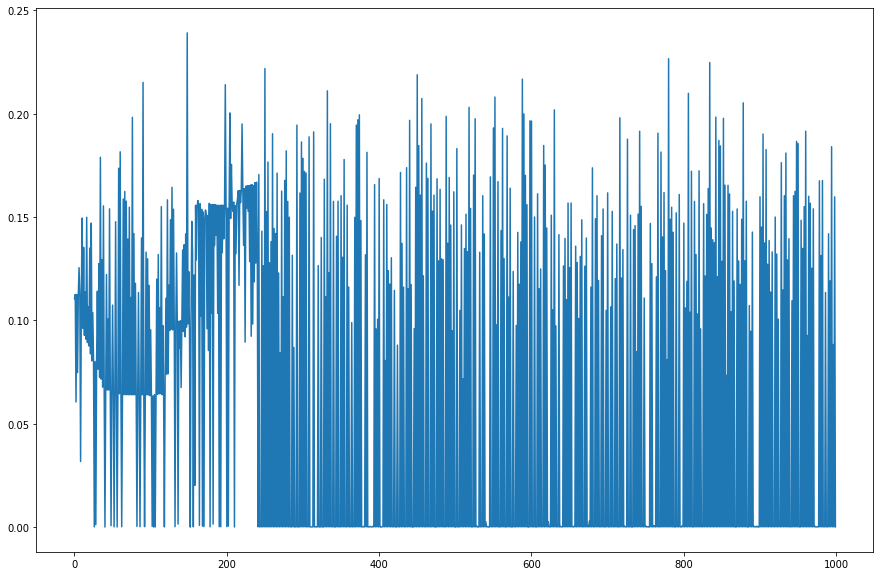

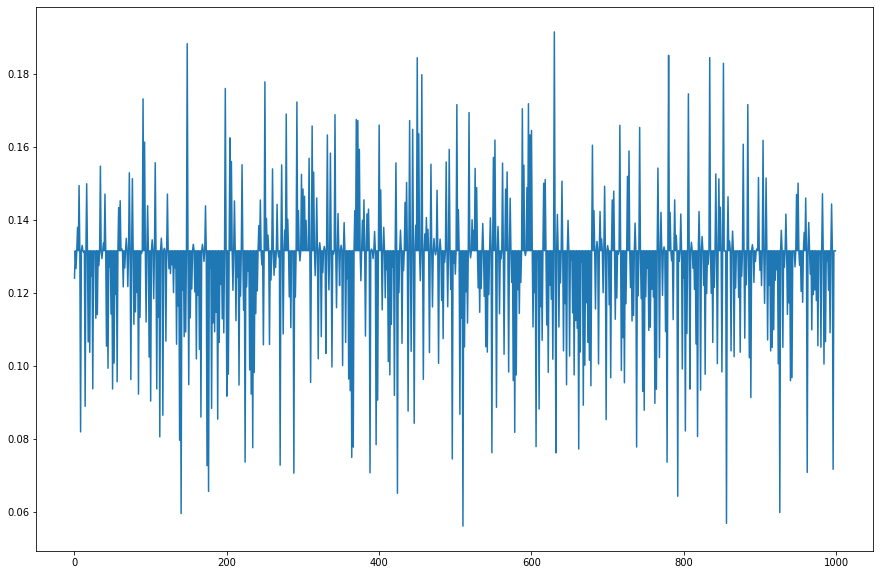

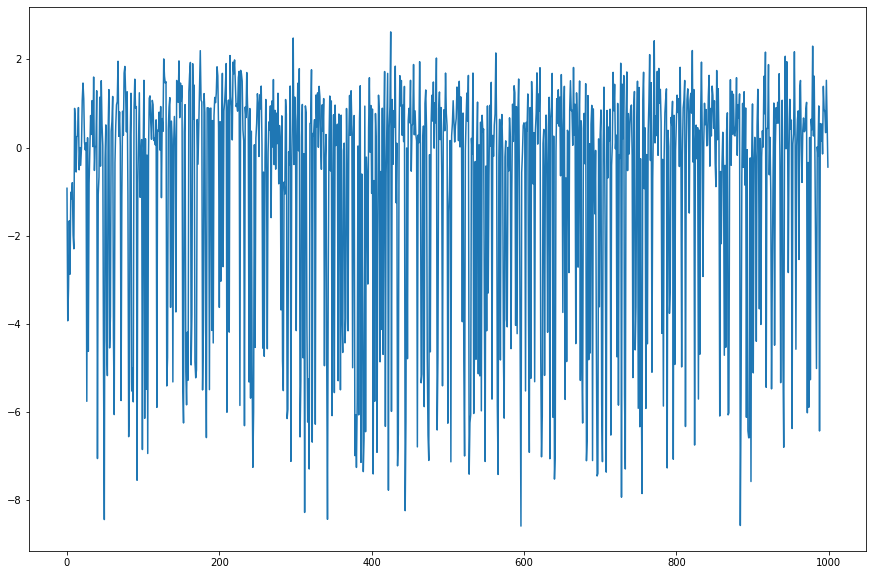

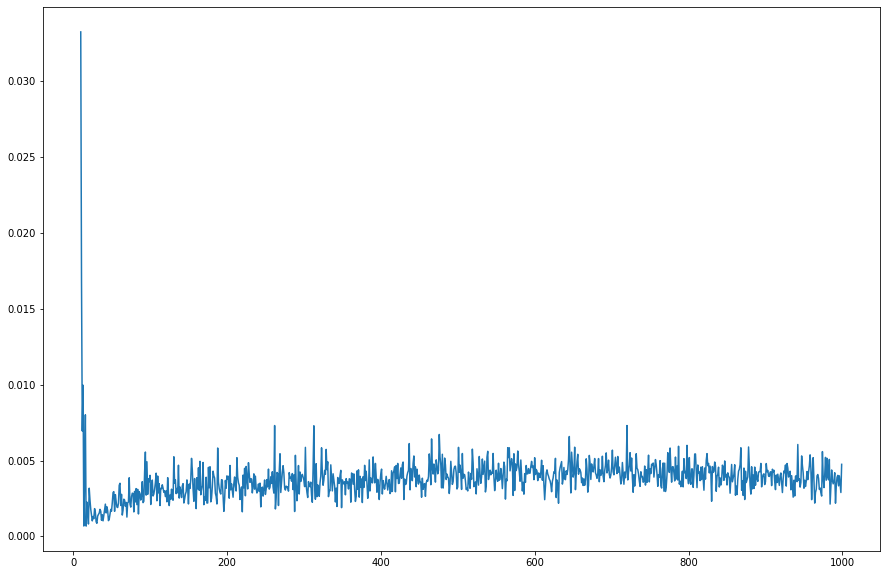

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.7)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

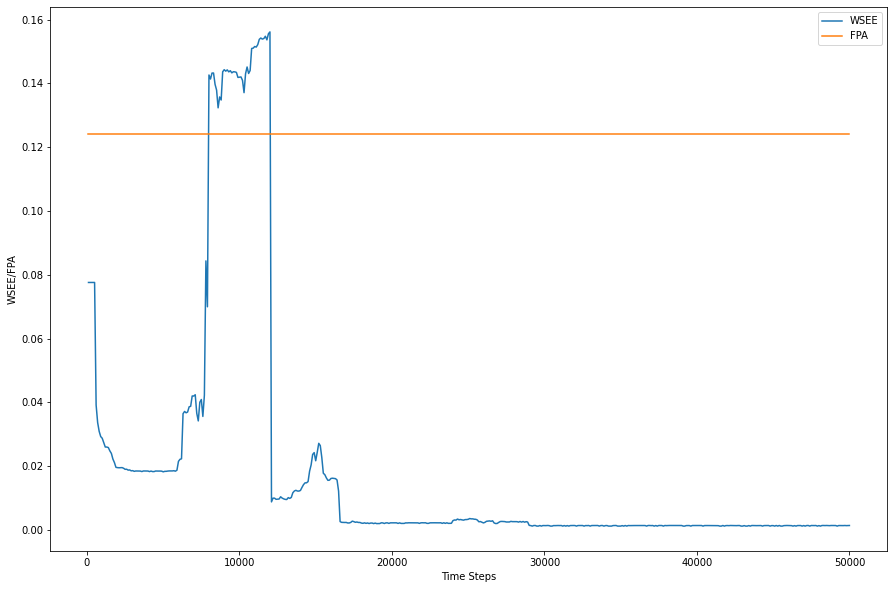

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

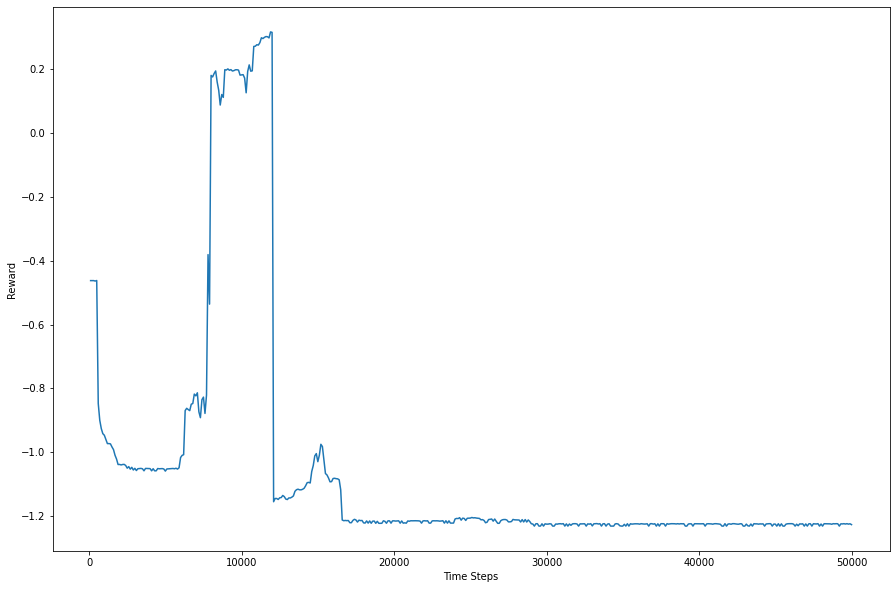

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
